Epoch 1/200


C:\Users\emily\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0286
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0038
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0031
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0029
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0025
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0024
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0023
Epoch 8/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0025
Epoch 9/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0020
Epoch 10/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0021
Epoch 11/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0024
Epoch 12/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0021
Epoch 13/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0019
Epoch 14/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0015
Epoch 15/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0019
E

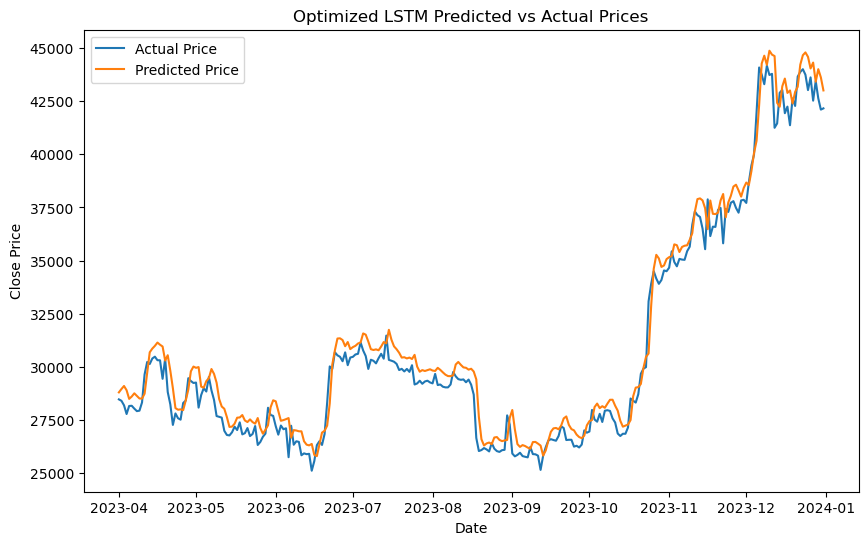

In [3]:
# BTC LSTM model 1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# 1. Load data
data = pd.read_csv(r"C:\Users\emily\Desktop\BTC-USD.csv", parse_dates=['Date'], index_col='Date')

# 2. Data preprocessing (using multiple features)
data = data[['Close', 'Volume', 'Open', 'High', 'Low']]  # Include multiple features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3. Create training and testing datasets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create LSTM dataset
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])  # Use multiple features
        Y.append(dataset[i + time_step, 0])  # Predict 'Close' price
    return np.array(X), np.array(Y)

# Adjust time step, try 30 or 90 days
time_step = 90
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# Reshape data to 3D format required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# 4. Build optimized LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer to predict 'Close' price

# 5. Compile the model, using a lower learning rate
model.compile(loss='mean_squared_error', optimizer='adam')

# 6. Train the model, increase epoch count
model.fit(X_train, Y_train, epochs=200, batch_size=64, verbose=1)

# 7. Predict and inverse transform
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]

Y_train = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
Y_test = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]

# 8. Calculate optimized MSE, RMSE, MAE, R², and AIC
mse_train = mean_squared_error(Y_train, train_predict)
rmse_train = np.sqrt(mse_train)

mse_test = mean_squared_error(Y_test, test_predict)
rmse_test = np.sqrt(mse_test)

mae_train = mean_absolute_error(Y_train, train_predict)
mae_test = mean_absolute_error(Y_test, test_predict)

r2_train = r2_score(Y_train, train_predict)
r2_test = r2_score(Y_test, test_predict)

# AIC Calculation
# Here, we use the formula AIC = n * log(MSE) + 2k, where n is the number of observations, and k is the number of parameters
n_train = len(Y_train)
k_train = len(model.trainable_weights)  # Number of parameters in the model
aic_train = n_train * np.log(mse_train) + 2 * k_train

n_test = len(Y_test)
k_test = len(model.trainable_weights)  # Number of parameters in the model
aic_test = n_test * np.log(mse_test) + 2 * k_test

# Print the performance metrics
print(f"Optimized Train MSE: {mse_train}, RMSE: {rmse_train}, MAE: {mae_train}, R²: {r2_train}, AIC: {aic_train}")
print(f"Optimized Test MSE: {mse_test}, RMSE: {rmse_test}, MAE: {mae_test}, R²: {r2_test}, AIC: {aic_test}")

# 9. Visualize prediction results
plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(Y_test):], Y_test, label="Actual Price")
plt.plot(data.index[-len(Y_test):], test_predict, label="Predicted Price")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Optimized LSTM Predicted vs Actual Prices')
plt.legend()
plt.show()


Epoch 1/200


C:\Users\emily\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0293
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0047
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0030
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0026
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0026
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0020
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0024
Epoch 8/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0025
Epoch 9/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0023
Epoch 10/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0020
Epoch 11/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0020
Epoch 12/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0020
Epoch 13/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0020
Epoch 14/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0018
Epoch 15/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0018
E

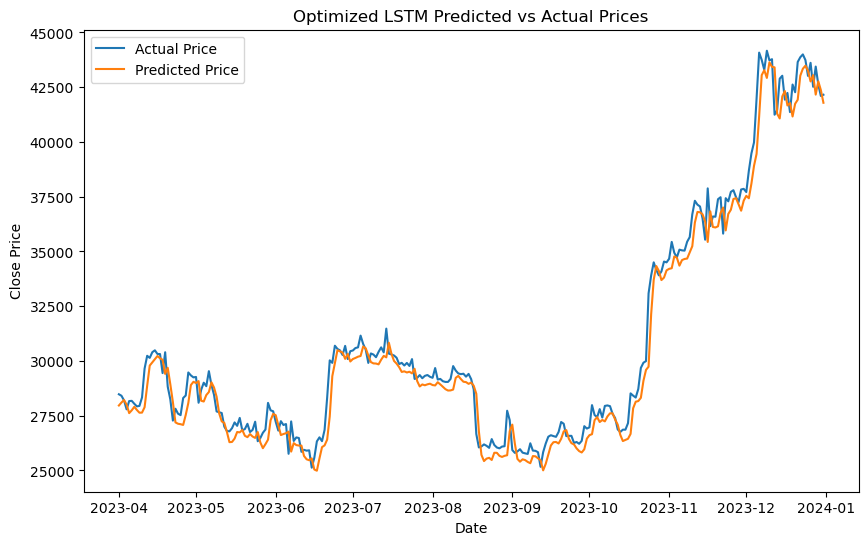

In [4]:
# BTC LSTM model 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# 1. Load the data
data = pd.read_csv(r"C:\Users\emily\Desktop\BTC-USD.csv", parse_dates=['Date'], index_col='Date')

# 2. Data preprocessing (using multiple features)
data = data[['Close', 'Volume', 'Open', 'High', 'Low']]  # Include multiple features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3. Create training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create LSTM dataset
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])  # Use multiple features
        Y.append(dataset[i + time_step, 0])  # Predict 'Close' price
    return np.array(X), np.array(Y)

# Adjust the time step; try 30 or 90 days
time_step = 90
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# Reshape the data to the 3D format required by LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# 4. Build the optimized LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer to predict 'Close' price

# 5. Compile the model, using a lower learning rate
model.compile(loss='mean_squared_error', optimizer='adam')

# 6. Train the model, increasing the number of epochs
model.fit(X_train, Y_train, epochs=200, batch_size=64, verbose=1)

# 7. Make predictions and inverse transform
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]

Y_train = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
Y_test = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]

# 8. Calculate optimized MSE, RMSE, MAE, R², and AIC
mse_train = mean_squared_error(Y_train, train_predict)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(Y_train, train_predict)
r2_train = r2_score(Y_train, train_predict)
aic_train = len(Y_train) * np.log(mse_train) + 2 * (2)  # 2 parameters for the model

mse_test = mean_squared_error(Y_test, test_predict)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(Y_test, test_predict)
r2_test = r2_score(Y_test, test_predict)
aic_test = len(Y_test) * np.log(mse_test) + 2 * (2)  # 2 parameters for the model

print(f"Optimized Train MSE: {mse_train}, RMSE: {rmse_train}, MAE: {mae_train}, R²: {r2_train}, AIC: {aic_train}")
print(f"Optimized Test MSE: {mse_test}, RMSE: {rmse_test}, MAE: {mae_test}, R²: {r2_test}, AIC: {aic_test}")

# 9. Visualize the prediction results
plt.figure(figsize=(10,6))
plt.plot(data.index[-len(Y_test):], Y_test, label="Actual Price")
plt.plot(data.index[-len(Y_test):], test_predict, label="Predicted Price")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Optimized LSTM Predicted vs Actual Prices')
plt.legend()
plt.show()


Epoch 1/250


C:\Users\emily\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 0.0558
Epoch 2/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - loss: 0.0040
Epoch 3/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 0.0035
Epoch 4/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 0.0024
Epoch 5/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - loss: 0.0029
Epoch 6/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - loss: 0.0027
Epoch 7/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - loss: 0.0026
Epoch 8/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 0.0023
Epoch 9/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - loss: 0.0022
Epoch 10/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - loss: 0.0024
Epoch 11/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - loss: 0.0018
Epoch 12/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - loss: 0.0022
Epoch 13/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: 0.0017
Epoch 14/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: 0.0021
Epoch 15/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step -

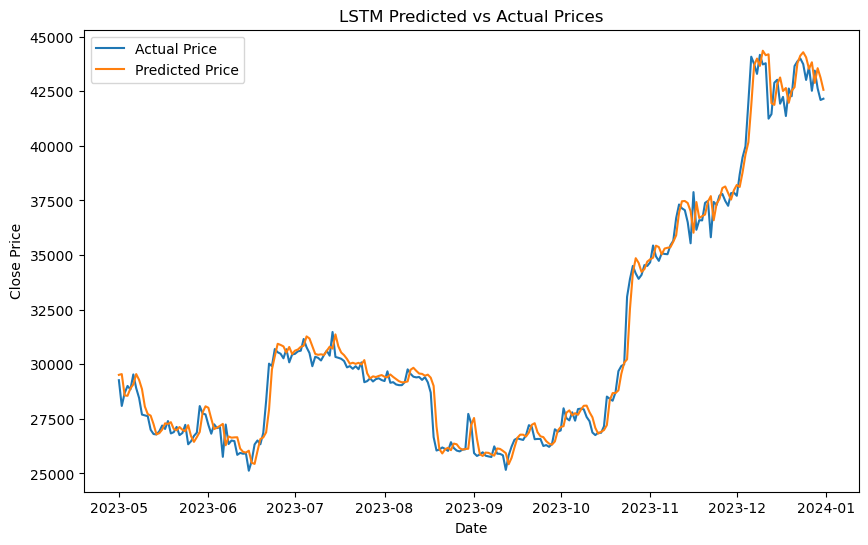

In [90]:
# BTC LSTM model 3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# 1. Load the data
data = pd.read_csv(r"C:\Users\emily\Desktop\BTC-USD.csv", parse_dates=['Date'], index_col='Date')

# 2. Data preprocessing (using multiple features)
data = data[['Close', 'Volume', 'Open', 'High', 'Low']]  # Use multiple features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3. Create training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create LSTM dataset
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])  # Use multiple features
        Y.append(dataset[i + time_step, 0])  # Predict 'Close' price
    return np.array(X), np.array(Y)

# Adjust the time step
time_step = 120  # You can adjust this based on your experiments
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# Reshape the data to the 3D format required by LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# 4. Build the LSTM model
model = Sequential()
model.add(LSTM(units=150, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(Dropout(0.3))  # Dropout for regularization
model.add(LSTM(units=150))  # Another LSTM layer
model.add(Dropout(0.3))  # Another Dropout layer
model.add(Dense(1))  # Output layer to predict 'Close' price

# 5. Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# 6. Train the model
model.fit(X_train, Y_train, epochs=250, batch_size=64, verbose=1)

# 7. Make predictions and inverse transform
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Rescale predicted data back to original scale
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

# Rescale actual data back to original scale
Y_train = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]
Y_test = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

# 8. Calculate performance metrics: MSE, RMSE, MAE, R², and AIC
mse_train = mean_squared_error(Y_train, train_predict)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(Y_train, train_predict)
r2_train = r2_score(Y_train, train_predict)
aic_train = len(Y_train) * np.log(mse_train) + 2 * (2)  # AIC calculation

mse_test = mean_squared_error(Y_test, test_predict)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(Y_test, test_predict)
r2_test = r2_score(Y_test, test_predict)
aic_test = len(Y_test) * np.log(mse_test) + 2 * (2)  # AIC calculation

# Print results
print(f"Train MSE: {mse_train}, RMSE: {rmse_train}, MAE: {mae_train}, R²: {r2_train}, AIC: {aic_train}")
print(f"Test MSE: {mse_test}, RMSE: {rmse_test}, MAE: {mae_test}, R²: {r2_test}, AIC: {aic_test}")

# 9. Visualize the prediction results
plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(Y_test):], Y_test, label="Actual Price")
plt.plot(data.index[-len(Y_test):], test_predict, label="Predicted Price")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('LSTM Predicted vs Actual Prices')
plt.legend()
plt.show()


Epoch 1/300


C:\Users\emily\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 305ms/step - loss: 0.0617
Epoch 2/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 305ms/step - loss: 0.0035
Epoch 3/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 307ms/step - loss: 0.0028
Epoch 4/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 308ms/step - loss: 0.0028
Epoch 5/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 308ms/step - loss: 0.0023
Epoch 6/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 308ms/step - loss: 0.0023
Epoch 7/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 310ms/step - loss: 0.0023
Epoch 8/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 305ms/step - loss: 0.0024
Epoch 9/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 307ms/step - loss: 0.0022
Epoch 10/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step - loss: 0.0023
Epoch 11/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 306ms/step - loss: 0.0022
Epoch 12/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 307ms/step - loss: 0.0019
Epoch 13/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 308ms/step - loss: 0.0023
Epoch 14/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 308ms/step - loss: 0.0023
Epoch 15/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 311ms/step 

C:\Users\emily\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\emily\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30424 (\N{CJK UNIFIED IDEOGRAPH-76D8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\emily\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\emily\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\emily\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20248 (\N{CJK UNIFIED IDEOGRAPH-4F18}) missing from current font.
  fig.canvas.print_figure(bytes_

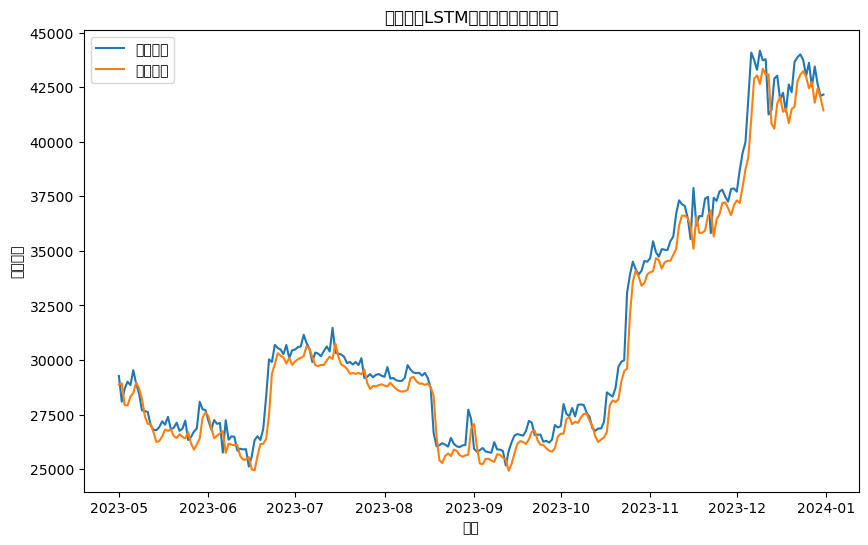

In [58]:
#BTC LSTM model 4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# 1. Load the data
data = pd.read_csv(r"C:\Users\emily\Desktop\BTC-USD.csv", parse_dates=['Date'], index_col='Date')

# 2. Data preprocessing (using multiple features)
data = data[['Close', 'Volume', 'Open', 'High', 'Low']]  # Using multiple features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3. Create training and testing datasets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create LSTM dataset
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])  # Using multiple features
        Y.append(dataset[i + time_step, 0])  # Predicting 'Close' price
    return np.array(X), np.array(Y)

# Set the time step to 120 days
time_step = 120
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# Reshape the data to the 3D format required by LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# 4. Build the optimized LSTM model
model = Sequential()
model.add(LSTM(units=150, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(Dropout(0.3))  # Increase Dropout to 0.3
model.add(LSTM(units=150))
model.add(Dropout(0.3))
model.add(Dense(1))  # Output layer predicting 'Close' price

# 5. Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# 6. Train the model, increasing epochs to 300
model.fit(X_train, Y_train, epochs=300, batch_size=64, verbose=1)

# 7. Make predictions and inverse transform the results
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predicted values back to the original scale
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]

# Inverse transform the actual values
Y_train = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
Y_test = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]

# 8. Calculate optimized MSE, RMSE, MAE, R², and AIC
mse_train = mean_squared_error(Y_train, train_predict)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(Y_train, train_predict)
r2_train = r2_score(Y_train, train_predict)
aic_train = len(Y_train) * np.log(mse_train) + 2 * (2)  # AIC calculation

mse_test = mean_squared_error(Y_test, test_predict)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(Y_test, test_predict)
r2_test = r2_score(Y_test, test_predict)
aic_test = len(Y_test) * np.log(mse_test) + 2 * (2)

print(f"Further Optimized Train MSE: {mse_train}, RMSE: {rmse_train}, MAE: {mae_train}, R²: {r2_train}, AIC: {aic_train}")
print(f"Further Optimized Test MSE: {mse_test}, RMSE: {rmse_test}, MAE: {mae_test}, R²: {r2_test}, AIC: {aic_test}")

# 9. Visualize the predicted vs actual results
plt.figure(figsize=(10,6))
plt.plot(data.index[-len(Y_test):], Y_test, label="Actual Price")
plt.plot(data.index[-len(Y_test):], test_predict, label="Predicted Price")
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Optimized LSTM Model: Predicted vs Actual Prices')
plt.legend()
plt.show()



In [91]:
#BTC LSTM models comparison
import pandas as pd
from tabulate import tabulate

# Define performance metrics
metrics = ["Train MSE", "Train RMSE", "Train MAE", "Train R²", "Train AIC",
           "Test MSE", "Test RMSE", "Test MAE", "Test R²", "Test AIC"]

# Performance metrics for Model 1
model_1 = [1652860.84, 1285.64, 806.30, 0.9945, 19617.37,
           702476.43, 838.14, 676.52, 0.9739, 3718.15]

# Performance metrics for Model 2
model_2 = [1577444.09, 1255.96, 807.93, 0.9948, 19541.43,
           608052.21, 779.78, 587.86, 0.9775, 3666.45]

# Updated performance metrics for Model 3
model_3 = [1462104.46, 1209.18, 735.49, 0.9951, 19011.62,
           449685.90, 670.59, 458.73, 0.9848, 3192.99]

# Performance metrics for Model 4
model_4 = [1768959.61, 1330.02, 821.51, 0.9941, 19266.72,
           745123.77, 863.21, 663.70, 0.9749, 3316.72]

# Create DataFrame to organize data
comparison_df = pd.DataFrame({
    'Metrics': metrics,
    'Model 1': model_1,
    'Model 2': model_2,
    'Model 3': model_3,
    'Model 4': model_4
})

# Print the comparison table
print(tabulate(comparison_df, headers='keys', tablefmt='grid'))


+----+------------+------------------+------------------+-----------------+------------------+
|    | Metrics    |          Model 1 |          Model 2 |         Model 3 |          Model 4 |
+====+============+==================+==================+=================+==================+
|  0 | Train MSE  |      1.65286e+06 |      1.57744e+06 |      1.4621e+06 |      1.76896e+06 |
+----+------------+------------------+------------------+-----------------+------------------+
|  1 | Train RMSE |   1285.64        |   1255.96        |   1209.18       |   1330.02        |
+----+------------+------------------+------------------+-----------------+------------------+
|  2 | Train MAE  |    806.3         |    807.93        |    735.49       |    821.51        |
+----+------------+------------------+------------------+-----------------+------------------+
|  3 | Train R²   |      0.9945      |      0.9948      |      0.9951     |      0.9941      |
+----+------------+------------------+------------

Epoch 1/250


C:\Users\emily\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - loss: 0.0453
Epoch 2/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - loss: 0.0040
Epoch 3/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - loss: 0.0030
Epoch 4/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - loss: 0.0025
Epoch 5/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - loss: 0.0025
Epoch 6/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - loss: 0.0022
Epoch 7/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - loss: 0.0025
Epoch 8/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - loss: 0.0022
Epoch 9/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - loss: 0.0025
Epoch 10/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - loss: 0.0025
Epoch 11/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - loss: 0.0023
Epoch 12/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - loss: 0.0020
Epoch 13/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - loss: 0.0017
Epoch 14/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - loss: 0.0018
Epoch 15/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step -

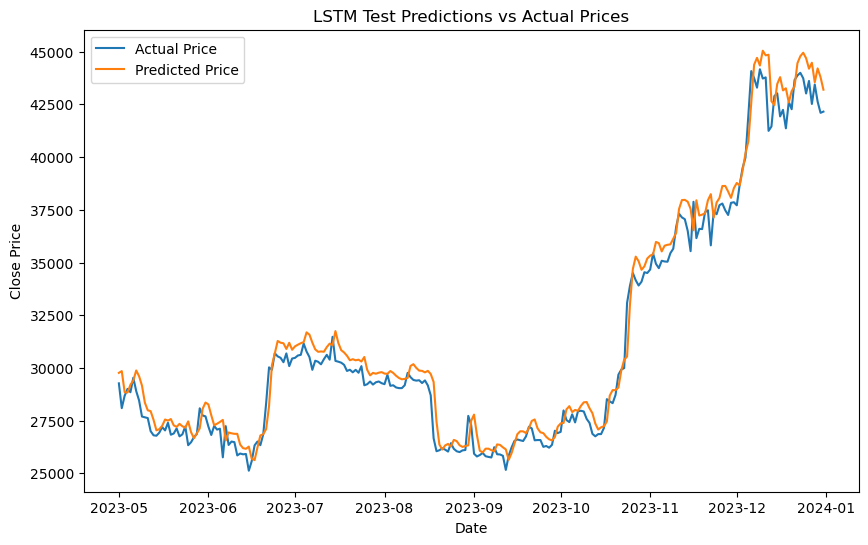

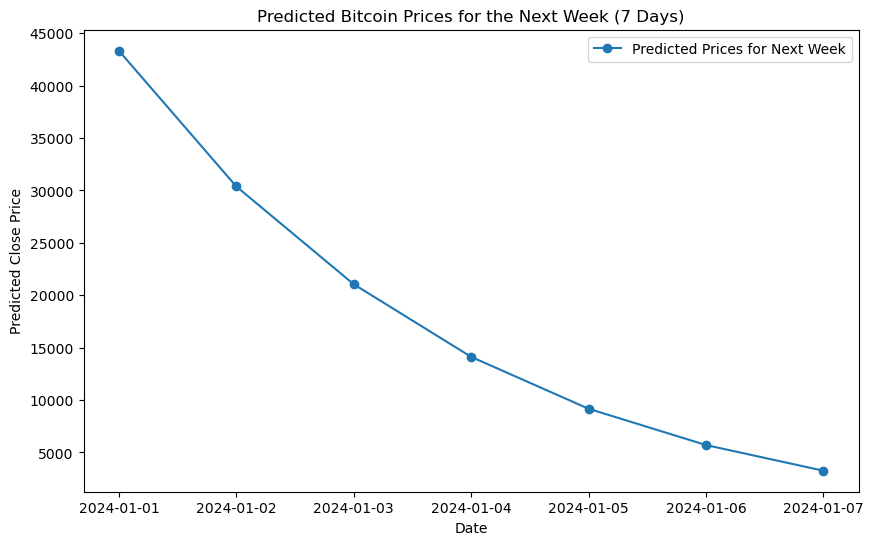

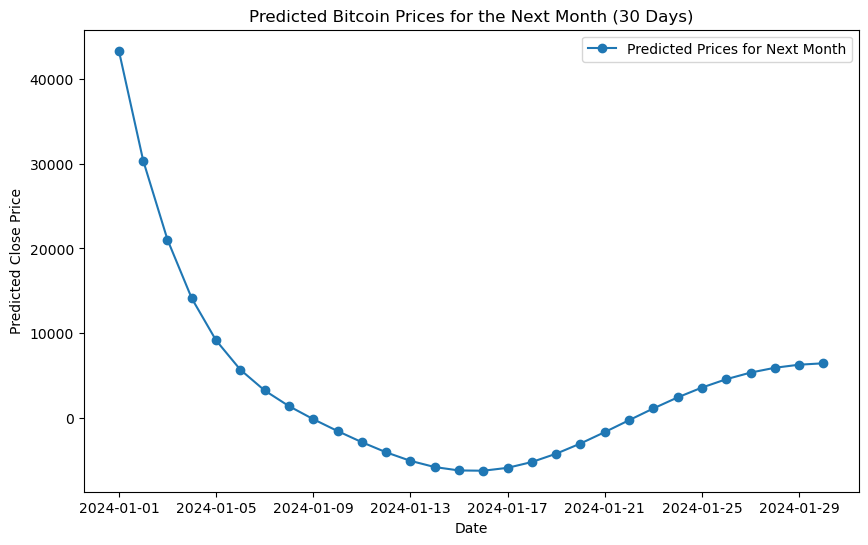

In [64]:
# Bitcoin 7 days and 30 days price prediction using LSTM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# 1. Load the data
data = pd.read_csv(r"C:\Users\emily\Desktop\BTC-USD.csv", parse_dates=['Date'], index_col='Date')

# 2. Data preprocessing (using multiple features)
data = data[['Close', 'Volume', 'Open', 'High', 'Low']]  # Use multiple features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3. Create training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create LSTM dataset
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])  # Use multiple features
        Y.append(dataset[i + time_step, 0])  # Predict 'Close' price
    return np.array(X), np.array(Y)

# Adjust the time step; increase or decrease based on experiment
time_step = 120  # Adjust to 120 days (can try other values such as 60, 90)
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# Reshape the data to the 3D format required by LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# 4. Build the LSTM model
model = Sequential()
model.add(LSTM(units=150, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=150))
model.add(Dropout(0.3))
model.add(Dense(1))

# 5. Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# 6. Train the model
model.fit(X_train, Y_train, epochs=250, batch_size=64, verbose=1)

# 7. Make predictions and inverse transform
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Rescale predicted data back to original scale
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]

# Rescale actual data back to original scale
Y_train = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
Y_test = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]

# 8. Calculate performance metrics
mse_test = mean_squared_error(Y_test, test_predict)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(Y_test, test_predict)
r2_test = r2_score(Y_test, test_predict)

# Print test results
print(f"Test MSE: {mse_test}, RMSE: {rmse_test}, MAE: {mae_test}, R²: {r2_test}")

# 9. Function to predict future prices
def predict_future_prices(n_future_days, future_input, model, scaler, time_step):
    future_predictions = []
    
    # Ensure future_input has the correct shape before starting prediction
    if future_input.shape[0] != time_step:
        raise ValueError(f"Expected future_input of length {time_step}, but got {future_input.shape[0]}")

    for _ in range(n_future_days):
        future_input_reshaped = future_input.reshape(1, time_step, future_input.shape[1])  # Reshape for LSTM input
        next_day_pred = model.predict(future_input_reshaped)
        future_predictions.append(next_day_pred[0, 0])

        # Prepare the next input
        next_day_pred_full = np.concatenate((next_day_pred, np.zeros((1, scaled_data.shape[1] - 1))), axis=1)
        future_input = np.concatenate((future_input[1:], next_day_pred_full), axis=0)  # Slide window

    # Rescale predictions back to original scale
    future_predictions = scaler.inverse_transform(np.concatenate((np.array(future_predictions).reshape(-1, 1),
                                                                  np.zeros((n_future_days, scaled_data.shape[1] - 1))), axis=1))[:, 0]
    return future_predictions

# 10. Predict the first week of 2024 (7 days)
n_future_days_week = 7  # Number of days to predict for a week
future_input_week = test_data[-time_step:]  # Last 'time_step' days from test data

predicted_week = predict_future_prices(n_future_days_week, future_input_week, model, scaler, time_step)

# 11. Predict the first month of 2024 (30 days)
n_future_days_month = 30  # Number of days to predict for a month
future_input_month = test_data[-time_step:]  # Last 'time_step' days from test data

predicted_month = predict_future_prices(n_future_days_month, future_input_month, model, scaler, time_step)

# 12. Visualize the prediction results for the week
plt.figure(figsize=(10,6))
plt.plot(data.index[-len(Y_test):], Y_test, label="Actual Price")
plt.plot(data.index[-len(Y_test):], test_predict, label="Predicted Price")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('LSTM Test Predictions vs Actual Prices')
plt.legend()
plt.show()

# 13. Visualize the predicted prices for the first week of 2024
future_dates_week = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n_future_days_week)
plt.figure(figsize=(10, 6))
plt.plot(future_dates_week, predicted_week, marker='o', label='Predicted Prices for Next Week')
plt.xlabel('Date')
plt.ylabel('Predicted Close Price')
plt.title('Predicted Bitcoin Prices for the Next Week (7 Days)')
plt.legend()
plt.show()

# 14. Visualize the predicted prices for the first month of 2024
future_dates_month = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n_future_days_month)
plt.figure(figsize=(10, 6))
plt.plot(future_dates_month, predicted_month, marker='o', label='Predicted Prices for Next Month')
plt.xlabel('Date')
plt.ylabel('Predicted Close Price')
plt.title('Predicted Bitcoin Prices for the Next Month (30 Days)')
plt.legend()
plt.show()


C:\Users\emily\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - loss: 0.0441
Epoch 2/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - loss: 0.0036
Epoch 3/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - loss: 0.0024
Epoch 4/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - loss: 0.0025
Epoch 5/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - loss: 0.0024
Epoch 6/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - loss: 0.0028
Epoch 7/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - loss: 0.0023
Epoch 8/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - loss: 0.0024
Epoch 9/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - loss: 0.0020
Epoch 10/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - loss: 0.0023
Epoch 11/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - loss: 0.0019
Epoch 12/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - loss: 0.0020
Epoch 13/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - loss: 0.0023
Epoch 14/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - loss: 0.0023
Epoch 15/250
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 

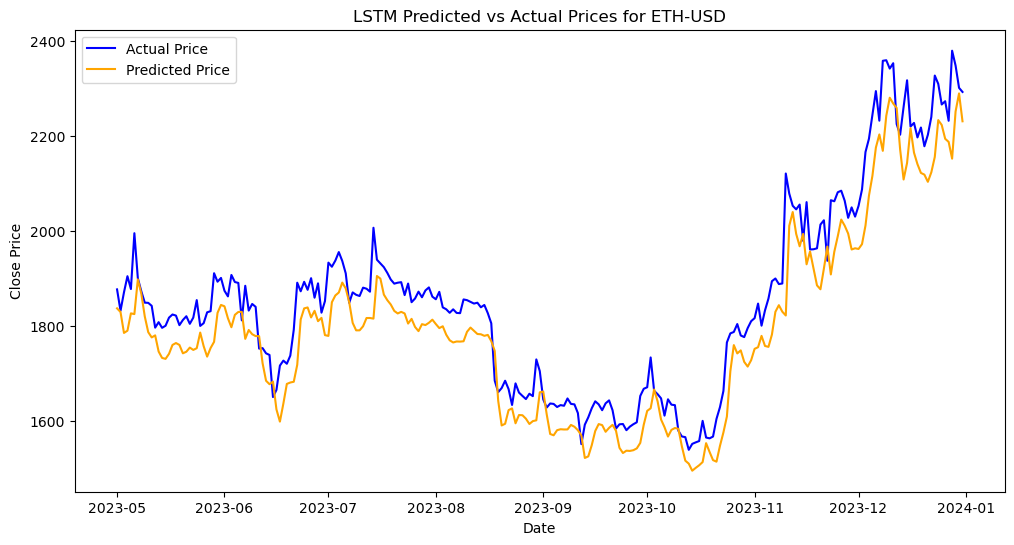

In [65]:
# ETH price prediction model 1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# 1. Load the data
data = pd.read_csv(r"C:\Users\emily\Desktop\ETH-USD.csv", parse_dates=['Date'], index_col='Date')

# 2. Data preprocessing (using multiple features)
data = data[['Close', 'Volume', 'Open', 'High', 'Low']]  # Use multiple features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3. Create training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create LSTM dataset
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])  # Use multiple features
        Y.append(dataset[i + time_step, 0])  # Predict 'Close' price
    return np.array(X), np.array(Y)

# Adjust the time step; increase or decrease based on experiment
time_step = 120  # Adjust to 120 days
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# Reshape the data to the 3D format required by LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# 4. Build the LSTM model
model = Sequential()
model.add(LSTM(units=150, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=150))
model.add(Dropout(0.3))
model.add(Dense(1))  # Output layer to predict 'Close' price

# 5. Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# 6. Train the model
model.fit(X_train, Y_train, epochs=250, batch_size=64, verbose=1)

# 7. Make predictions and inverse transform
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Rescale predicted data back to original scale
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]

# Rescale actual data back to original scale
Y_train = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
Y_test = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]

# 8. Calculate performance metrics: MSE, RMSE, MAE, R², and AIC
mse_train = mean_squared_error(Y_train, train_predict)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(Y_train, train_predict)
r2_train = r2_score(Y_train, train_predict)
aic_train = len(Y_train) * np.log(mse_train) + 2 * (2)  # AIC calculation

mse_test = mean_squared_error(Y_test, test_predict)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(Y_test, test_predict)
r2_test = r2_score(Y_test, test_predict)
aic_test = len(Y_test) * np.log(mse_test) + 2 * (2)  # AIC calculation

# Print results
print(f"Train MSE: {mse_train:.4f}, RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}, AIC: {aic_train:.4f}")
print(f"Test MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}, AIC: {aic_test:.4f}")

# 9. Visualize the prediction results
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(Y_test):], Y_test, label="Actual Price", color='blue')
plt.plot(data.index[-len(Y_test):], test_predict, label="Predicted Price", color='orange')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('LSTM Predicted vs Actual Prices for ETH-USD')
plt.legend()
plt.show()


Epoch 1/100


C:\Users\emily\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - loss: 0.0352
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 0.0036
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 0.0037
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - loss: 0.0033
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0031
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - loss: 0.0025
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 0.0031
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 0.0028
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - loss: 0.0024
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.0024
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 0.0024
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - loss: 0.0030
Epoch 13/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.0023
Epoch 14/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.0022
Epoch 15/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step 

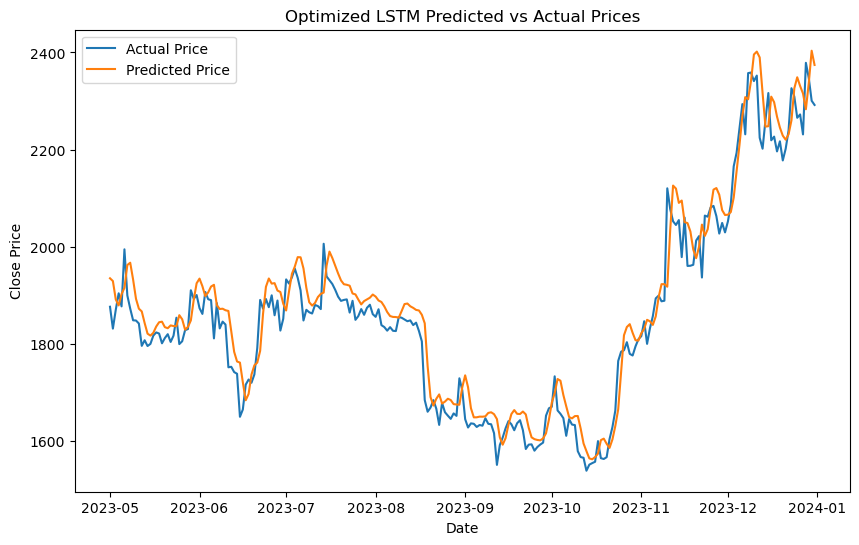

In [66]:
# ETH price prediction model 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# 1. Load the data
data = pd.read_csv(r"C:\Users\emily\Desktop\ETH-USD.csv", parse_dates=['Date'], index_col='Date')

# 2. Data preprocessing
data = data[['Close', 'Volume', 'Open', 'High', 'Low']]  # Use multiple features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3. Create training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create LSTM dataset
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])  # Use multiple features
        Y.append(dataset[i + time_step, 0])  # Predict 'Close' price
    return np.array(X), np.array(Y)

# Adjust the time step
time_step = 120  # Keep this value for consistency
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# Reshape the data to the 3D format required by LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# 4. Build the optimized LSTM model
model = Sequential()

# Add LSTM layers with increased units and dropout for regularization
model.add(LSTM(units=100, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(LSTM(units=100, return_sequences=True))  # Another LSTM layer
model.add(Dropout(0.2))  # Another Dropout layer
model.add(LSTM(units=100))  # Another LSTM layer
model.add(Dropout(0.2))  # Another Dropout layer
model.add(Dense(1))  # Output layer to predict 'Close' price

# 5. Compile the model with a lower learning rate optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

# 6. Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)  # Adjusted epochs and batch size

# 7. Make predictions and inverse transform
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Rescale predicted data back to original scale
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]

# Rescale actual data back to original scale
Y_train = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
Y_test = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]

# 8. Calculate performance metrics: MSE, RMSE, MAE, R², and AIC
mse_train = mean_squared_error(Y_train, train_predict)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(Y_train, train_predict)
r2_train = r2_score(Y_train, train_predict)
aic_train = len(Y_train) * np.log(mse_train) + 2 * (4)  # AIC calculation

mse_test = mean_squared_error(Y_test, test_predict)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(Y_test, test_predict)
r2_test = r2_score(Y_test, test_predict)
aic_test = len(Y_test) * np.log(mse_test) + 2 * (4)  # AIC calculation

# Print results
print(f"Optimized Train MSE: {mse_train}, RMSE: {rmse_train}, MAE: {mae_train}, R²: {r2_train}, AIC: {aic_train}")
print(f"Optimized Test MSE: {mse_test}, RMSE: {rmse_test}, MAE: {mae_test}, R²: {r2_test}, AIC: {aic_test}")

# 9. Visualize the prediction results
plt.figure(figsize=(10,6))
plt.plot(data.index[-len(Y_test):], Y_test, label="Actual Price")
plt.plot(data.index[-len(Y_test):], test_predict, label="Predicted Price")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Optimized LSTM Predicted vs Actual Prices')
plt.legend()
plt.show()


C:\Users\emily\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 202ms/step - loss: 2.6194
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - loss: 0.7441
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - loss: 0.1830
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - loss: 0.0496
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - loss: 0.0217
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - loss: 0.0155
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - loss: 0.0127
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - loss: 0.0108
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - loss: 0.0105
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - loss: 0.0089
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - loss: 0.0089
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - loss: 0.0088
Epoch 13/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - loss: 0.0095
Epoch 14/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - loss: 0.0086
Epoch 15/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s

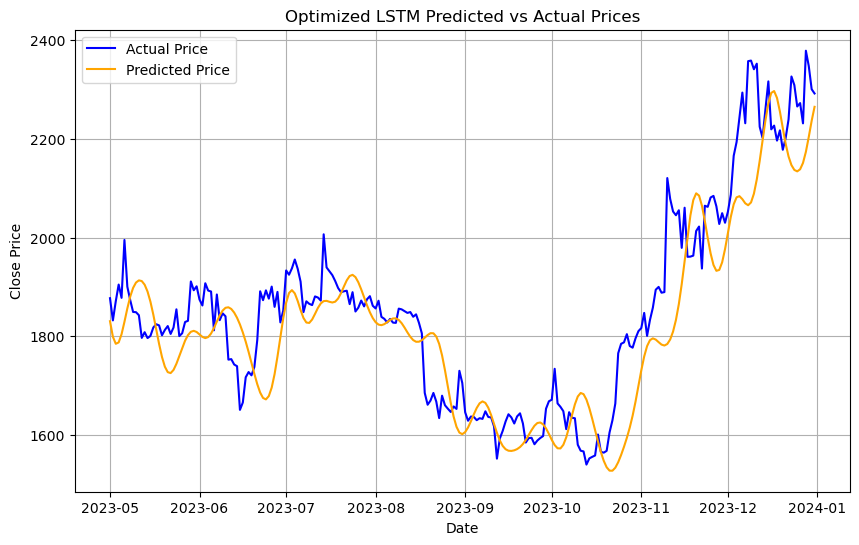

In [73]:
# ETH price prediction model 3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2

# 1. Load the data
data = pd.read_csv(r"C:\Users\emily\Desktop\ETH-USD.csv", parse_dates=['Date'], index_col='Date')

# 2. Data preprocessing
data = data[['Close', 'Volume', 'Open', 'High', 'Low']]  # Use multiple features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3. Create training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create LSTM dataset
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])  # Use multiple features
        Y.append(dataset[i + time_step, 0])  # Predict 'Close' price
    return np.array(X), np.array(Y)

# Adjust the time step
time_step = 120  # Keep this value for consistency
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# Reshape the data to the 3D format required by LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# 4. Build the optimized LSTM model with L2 regularization
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(time_step, X_train.shape[2])))
model.add(Dropout(0.3))  # Increased dropout rate
model.add(LSTM(units=100, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(LSTM(units=100, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(1))  # Output layer to predict 'Close' price

# 5. Compile the model with a lower learning rate optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

# 6. Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)  # Adjusted epochs and batch size

# 7. Make predictions and inverse transform
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Rescale predicted data back to original scale
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]

# Rescale actual data back to original scale
Y_train = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
Y_test = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]

# 8. Calculate performance metrics: MSE, RMSE, MAE, R², and AIC
mse_train = mean_squared_error(Y_train, train_predict)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(Y_train, train_predict)
r2_train = r2_score(Y_train, train_predict)
aic_train = len(Y_train) * np.log(mse_train) + 2 * (4)  # AIC calculation

mse_test = mean_squared_error(Y_test, test_predict)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(Y_test, test_predict)
r2_test = r2_score(Y_test, test_predict)
aic_test = len(Y_test) * np.log(mse_test) + 2 * (4)  # AIC calculation

# Print results
print(f"Optimized Train MSE: {mse_train}, RMSE: {rmse_train}, MAE: {mae_train}, R²: {r2_train}, AIC: {aic_train}")
print(f"Optimized Test MSE: {mse_test}, RMSE: {rmse_test}, MAE: {mae_test}, R²: {r2_test}, AIC: {aic_test}")

# 9. Visualize the prediction results
plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(Y_test):], Y_test, label="Actual Price", color='blue')
plt.plot(data.index[-len(Y_test):], test_predict, label="Predicted Price", color='orange')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Optimized LSTM Predicted vs Actual Prices')
plt.legend()
plt.grid()
plt.show()


Epoch 1/100


C:\Users\emily\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - loss: 2.5976
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 0.7382
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.1827
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.0517
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.0200
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 0.0132
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 0.0115
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.0098
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0092
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 0.0118
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0086
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.0083
Epoch 13/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 0.0080
Epoch 14/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 0.0085
Epoch 15/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - l

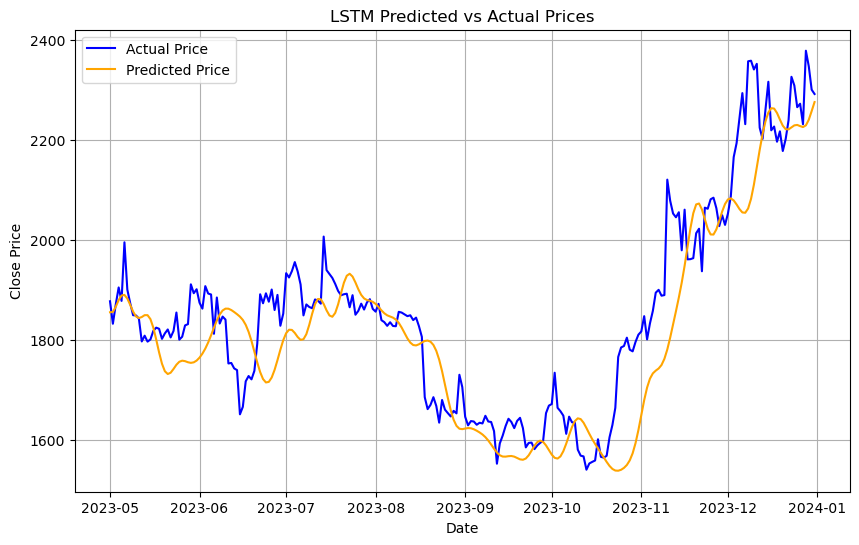

In [78]:
# ETH price prediction model 4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2

# 1. Load the data
data = pd.read_csv(r"C:\Users\emily\Desktop\ETH-USD.csv", parse_dates=['Date'], index_col='Date')

# 2. Data preprocessing
data = data[['Close', 'Volume', 'Open', 'High', 'Low']]  # Use multiple features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3. Create training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create LSTM dataset
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])  # Use multiple features
        Y.append(dataset[i + time_step, 0])  # Predict 'Close' price
    return np.array(X), np.array(Y)

# Adjust the time step
time_step = 120  # Keep this value for consistency
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# Reshape the data to the 3D format required by LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# 4. Build the optimized LSTM model with L2 regularization
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(time_step, X_train.shape[2])))
model.add(Dropout(0.3))  # Increased dropout rate
model.add(LSTM(units=100, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(LSTM(units=100, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(1))  # Output layer to predict 'Close' price

# 5. Compile the model with a lower learning rate optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

# 6. Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)  # Adjusted epochs and batch size

# 7. Make predictions and inverse transform
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Rescale predicted data back to original scale
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]

# Rescale actual data back to original scale
Y_train = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
Y_test = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]

# 8. Calculate performance metrics: MSE, RMSE, MAE, R², and AIC
mse_train = mean_squared_error(Y_train, train_predict)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(Y_train, train_predict)
r2_train = r2_score(Y_train, train_predict)
aic_train = len(Y_train) * np.log(mse_train) + 2 * (4)  # AIC calculation

mse_test = mean_squared_error(Y_test, test_predict)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(Y_test, test_predict)
r2_test = r2_score(Y_test, test_predict)
aic_test = len(Y_test) * np.log(mse_test) + 2 * (4)  # AIC calculation

# Print results
print(f"Train MSE: {mse_train}, RMSE: {rmse_train}, MAE: {mae_train}, R²: {r2_train}, AIC: {aic_train}")
print(f"Test MSE: {mse_test}, RMSE: {rmse_test}, MAE: {mae_test}, R²: {r2_test}, AIC: {aic_test}")

# 9. Visualize the prediction results
plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(Y_test):], Y_test, label="Actual Price", color='blue')
plt.plot(data.index[-len(Y_test):], test_predict, label="Predicted Price", color='orange')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('LSTM Predicted vs Actual Prices')
plt.legend()
plt.grid()
plt.show()


In [81]:
#ETH Lstm model comparison
import pandas as pd
from tabulate import tabulate

# Define performance metrics
metrics = ["Train MSE", "Train RMSE", "Train MAE", "Train R²", "Train AIC",
           "Test MSE", "Test RMSE", "Test MAE", "Test R²", "Test AIC"]

# Performance metrics for Model 1
model_1 = [15747.2285, 125.4880, 82.1896, 0.9905, 12944.6579,
           5952.6054, 77.1531, 65.8651, 0.8523, 2133.4381]

# Performance metrics for Model 2
model_2 = [10099.3103, 100.4953, 61.7919, 0.9939, 12353.8778,
           2608.5767, 51.0742, 40.4298, 0.9353, 1935.3072]

# Performance metrics for Model 3
model_3 = [56138.6841, 236.9360, 171.9027, 0.9661, 14650.7422,
           9989.1854, 99.9459, 77.3241, 0.7521, 2264.2683]

# Performance metrics for Model 4
model_4 = [62448.9749, 249.8979, 174.3510, 0.9623, 14793.3787,
           9839.3202, 99.1933, 74.3919, 0.7558, 2260.5648]

# Create DataFrame to organize data
comparison_df = pd.DataFrame({
    'Metrics': metrics,
    'Model 1': model_1,
    'Model 2': model_2,
    'Model 3': model_3,
    'Model 4': model_4
})

# Print the comparison table
print(tabulate(comparison_df, headers='keys', tablefmt='pretty'))


+---+------------+------------+------------+------------+------------+
|   |  Metrics   |  Model 1   |  Model 2   |  Model 3   |  Model 4   |
+---+------------+------------+------------+------------+------------+
| 0 | Train MSE  | 15747.2285 | 10099.3103 | 56138.6841 | 62448.9749 |
| 1 | Train RMSE |  125.488   |  100.4953  |  236.936   |  249.8979  |
| 2 | Train MAE  |  82.1896   |  61.7919   |  171.9027  |  174.351   |
| 3 |  Train R²  |   0.9905   |   0.9939   |   0.9661   |   0.9623   |
| 4 | Train AIC  | 12944.6579 | 12353.8778 | 14650.7422 | 14793.3787 |
| 5 |  Test MSE  | 5952.6054  | 2608.5767  | 9989.1854  | 9839.3202  |
| 6 | Test RMSE  |  77.1531   |  51.0742   |  99.9459   |  99.1933   |
| 7 |  Test MAE  |  65.8651   |  40.4298   |  77.3241   |  74.3919   |
| 8 |  Test R²   |   0.8523   |   0.9353   |   0.7521   |   0.7558   |
| 9 |  Test AIC  | 2133.4381  | 1935.3072  | 2264.2683  | 2260.5648  |
+---+------------+------------+------------+------------+------------+


C:\Users\emily\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - loss: 0.0176
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0029
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0029
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0032
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.0034
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 0.0021
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - loss: 0.0020
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - loss: 0.0025
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - loss: 0.0017
Epoch 10/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 0.0019
Epoch 11/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - loss: 0.0020
Epoch 12/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - loss: 0.0015
Epoch 13/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 0.0017
Epoch 14/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - loss: 0.0018
Epoch 15/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 

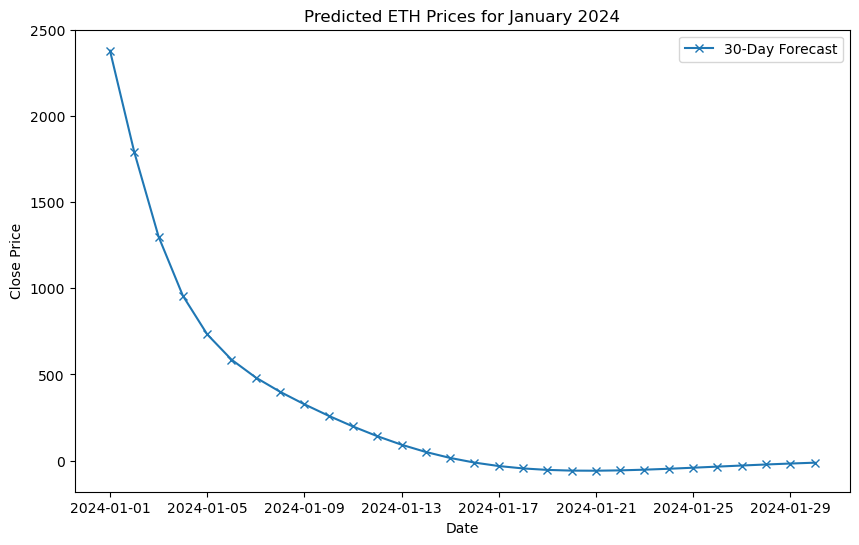

In [77]:
#ETH price prediction using LSTM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# 1. Load the data
data = pd.read_csv(r"C:\Users\emily\Desktop\ETH-USD.csv", parse_dates=['Date'], index_col='Date')

# 2. Data preprocessing
# Select relevant features: 'Close', 'Volume', 'Open', 'High', 'Low'
data = data[['Close', 'Volume', 'Open', 'High', 'Low']]

# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3. Create training and testing sets
train_size = len(scaled_data)  # Use all data for training
train_data = scaled_data[:train_size]

# Function to create dataset for LSTM
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), :])  # Use multiple features
        Y.append(dataset[i + time_step, 0])  # Predict 'Close' price
    return np.array(X), np.array(Y)

# Set time step (sequence length)
time_step = 120

# Prepare training dataset
X_train, Y_train = create_dataset(train_data, time_step)

# Reshape the input to 3D format for LSTM (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])

# 4. Build the LSTM model (same as Model 2)
model = Sequential()

# Add LSTM layers with Dropout for regularization
model.add(LSTM(units=100, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer to predict 'Close' price

# 5. Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# 6. Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

# 7. Predict the future prices for the next 7 and 30 days (forecasting)

# Get the last 120 time steps from the data (end of 2023)
last_120_days = scaled_data[-time_step:]

# Reshape the last 120 days to match the LSTM input shape
last_120_days = last_120_days.reshape(1, time_step, last_120_days.shape[1])

# 7-day prediction
seven_day_forecast = []
current_input = last_120_days.copy()

for i in range(7):
    predicted_price = model.predict(current_input)[0]
    
    # Append the predicted price to the forecast list
    seven_day_forecast.append(predicted_price[0])
    
    # Update the current input to include the predicted price and shift window
    new_input = np.concatenate([predicted_price.reshape(1, -1), np.zeros((1, current_input.shape[2] - 1))], axis=1)
    current_input = np.concatenate([current_input[:, 1:, :], new_input.reshape(1, 1, current_input.shape[2])], axis=1)

# 30-day prediction (for the first month)
thirty_day_forecast = []
current_input = last_120_days.copy()

for i in range(30):
    predicted_price = model.predict(current_input)[0]
    
    # Append the predicted price to the forecast list
    thirty_day_forecast.append(predicted_price[0])
    
    # Update the current input to include the predicted price and shift window
    new_input = np.concatenate([predicted_price.reshape(1, -1), np.zeros((1, current_input.shape[2] - 1))], axis=1)
    current_input = np.concatenate([current_input[:, 1:, :], new_input.reshape(1, 1, current_input.shape[2])], axis=1)

# 8. Inverse transform the predicted values back to original scale
seven_day_forecast = scaler.inverse_transform(np.concatenate([np.array(seven_day_forecast).reshape(-1, 1), np.zeros((7, scaled_data.shape[1] - 1))], axis=1))[:,0]
thirty_day_forecast = scaler.inverse_transform(np.concatenate([np.array(thirty_day_forecast).reshape(-1, 1), np.zeros((30, scaled_data.shape[1] - 1))], axis=1))[:,0]

# 9. Visualize the future predictions
dates_2024 = pd.date_range(start='2024-01-01', periods=30, freq='D')  # Generate future dates for plotting

plt.figure(figsize=(10,6))
plt.plot(dates_2024[:7], seven_day_forecast, label="7-Day Forecast", marker='o')
plt.plot(dates_2024, thirty_day_forecast, label="30-Day Forecast", marker='x')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Predicted ETH Prices for January 2024')
plt.legend()
plt.show()


C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                 1460
Model:                    AutoReg(10)   Log Likelihood              -12218.042
Method:               Conditional MLE   S.D. of innovations           1104.665
Date:                Mon, 14 Oct 2024   AIC                          24460.085
Time:                        18:50:58   BIC                          24523.437
Sample:                    01-11-2019   HQIC                         24483.726
                         - 12-30-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         67.4374     48.757      1.383      0.167     -28.125     163.000
Close.L1       0.9682      0.026     37.004      0.000       0.917       1.019
Close.L2       0.0407      0.036      1.119      0.2

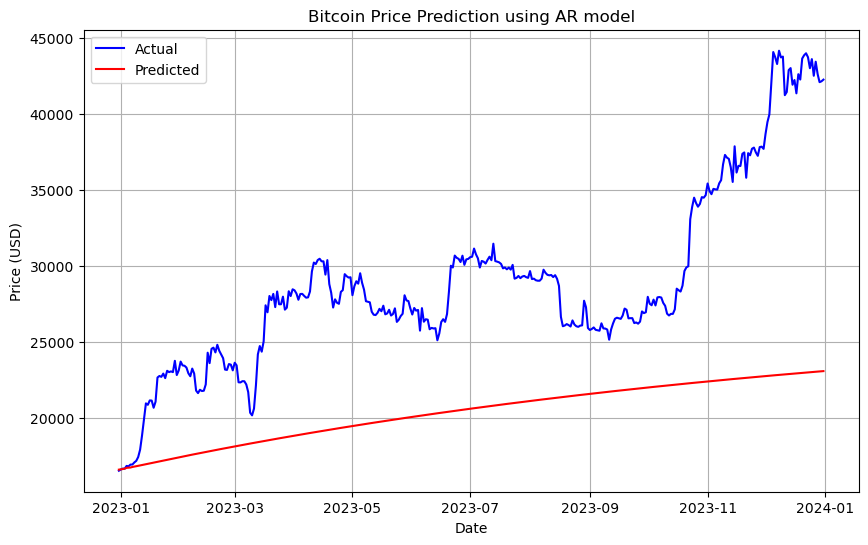

C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


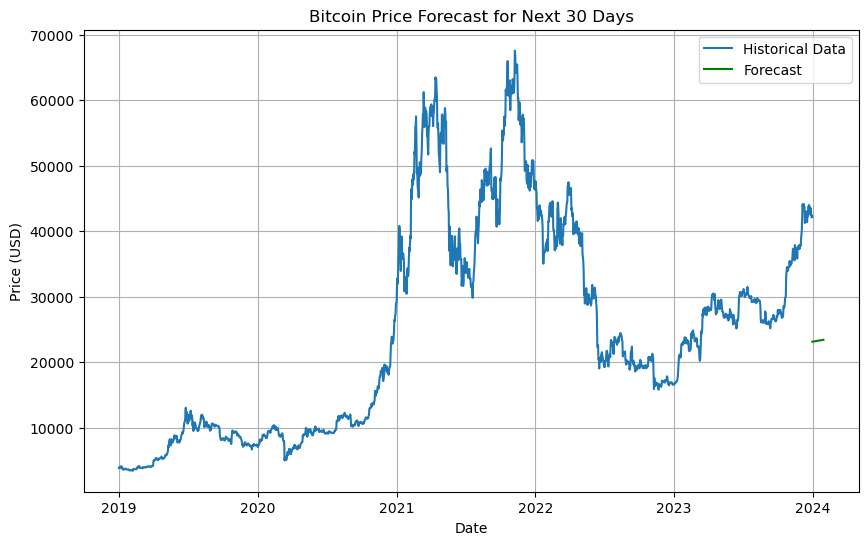

In [1]:
# Time series analysis
# AR model 1 for Bitcoin
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Read the data from CSV file
data_btc = pd.read_csv(r"C:\Users\emily\Desktop\BTC-USD.csv", parse_dates=['Date'], index_col='Date')

# Ensure the 'Close' column is numeric
data_btc['Close'] = pd.to_numeric(data_btc['Close'], errors='coerce')

# Drop missing values if any
data_btc = data_btc.dropna()

# Split the data into training and test sets
train_size = int(len(data_btc) * 0.8)  # 80% training data
train, test = data_btc['Close'][:train_size], data_btc['Close'][train_size:]

# Fit the AutoRegressive (AR) model on training data
model = AutoReg(train, lags=10)  # Using 10 lags as an example
model_fitted = model.fit()

# Print the model summary (includes AIC)
print(model_fitted.summary())

# Predict future values on the test set
predictions = model_fitted.predict(start=len(train), end=len(data_btc)-1, dynamic=False)

# Calculate MSE, RMSE, MAE, R²
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predictions)
r2 = r2_score(test, predictions)

# AIC is already included in the fitted model summary
aic = model_fitted.aic

# Print performance metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")
print(f"Akaike Information Criterion (AIC): {aic}")

# Visualize the actual vs predicted
plt.figure(figsize=(10,6))
plt.plot(data_btc.index[train_size:], test, label='Actual', color='blue')
plt.plot(data_btc.index[train_size:], predictions, label='Predicted', color='red')
plt.title('Bitcoin Price Prediction using AR model')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Forecast future prices (e.g., 30 days ahead)
forecast_steps = 30
forecast = model_fitted.predict(start=len(data_btc), end=len(data_btc)+forecast_steps-1, dynamic=False)

# Visualize the forecast
plt.figure(figsize=(10,6))
plt.plot(data_btc.index, data_btc['Close'], label='Historical Data')
plt.plot(pd.date_range(data_btc.index[-1], periods=forecast_steps, freq='D'), forecast, label='Forecast', color='green')
plt.title('Bitcoin Price Forecast for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\emily\AppData\Local\Temp\ipykernel_21328\4261110125.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions_cumsum = predictions.cumsum() + data_btc['Close'][train_size]
C:\Users\emily\AppData\Local\Temp\ipykernel_21328\4261110125.py:

Mean Squared Error (MSE): 141514830.89903507
Root Mean Squared Error (RMSE): 11896.000626220355
Mean Absolute Error (MAE): 10713.76516266256
R-squared (R²): -3.076544417250929
Akaike Information Criterion (AIC): 24461.56326800982


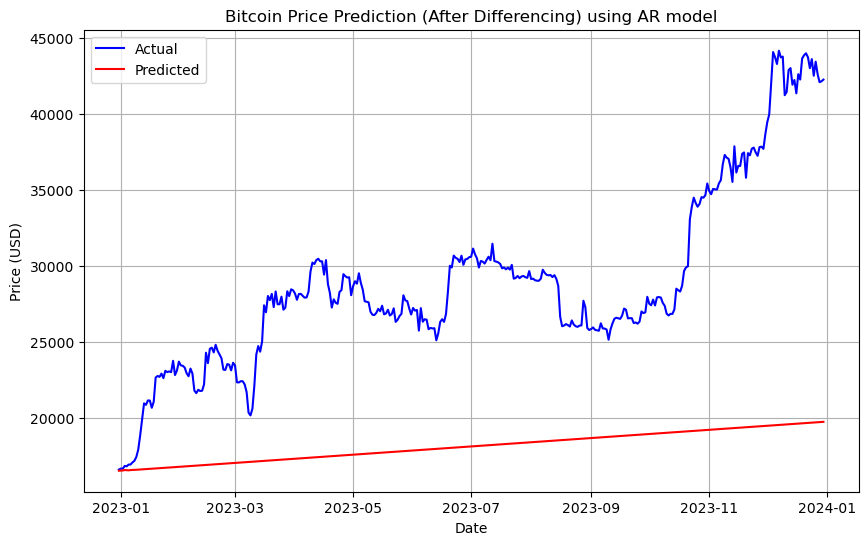

In [4]:
#AR Model 2 for Bitcoin
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Read the data from CSV file
data_btc = pd.read_csv(r"C:\Users\emily\Desktop\BTC-USD.csv", parse_dates=['Date'], index_col='Date')

# Ensure the 'Close' column is numeric and drop any non-numeric data
data_btc['Close'] = pd.to_numeric(data_btc['Close'], errors='coerce')
data_btc = data_btc.dropna()

# Differencing the data to remove trend
data_btc_diff = data_btc['Close'].diff().dropna()

# Split the dataset: 80% for training, 20% for testing
train_size = int(len(data_btc_diff) * 0.8)
train, test = data_btc_diff[:train_size], data_btc_diff[train_size:]

# Fit the AutoReg model with an optimal lag (you can also use grid search here)
best_lag = 10  # Adjust based on model tuning or cross-validation
model = AutoReg(train, lags=best_lag)
model_fitted = model.fit()

# Make predictions for the test set
predictions = model_fitted.predict(start=len(train), end=len(data_btc_diff)-1, dynamic=False)

# Inverse differencing: converting differenced predictions back to original prices
predictions_cumsum = predictions.cumsum() + data_btc['Close'][train_size]
test_cumsum = test.cumsum() + data_btc['Close'][train_size]

# Make sure both test_cumsum and predictions_cumsum have the same number of points
test_cumsum = test_cumsum[:len(predictions_cumsum)]  # Truncate test data to match predictions length

# Calculate performance metrics
mse = mean_squared_error(test_cumsum, predictions_cumsum)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_cumsum, predictions_cumsum)
r2 = r2_score(test_cumsum, predictions_cumsum)
aic = model_fitted.aic

# Output performance metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")
print(f"Akaike Information Criterion (AIC): {aic}")

# Plot the actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(data_btc.index[train_size:train_size+len(test_cumsum)], test_cumsum, label='Actual', color='blue')
plt.plot(data_btc.index[train_size:train_size+len(predictions_cumsum)], predictions_cumsum, label='Predicted', color='red')
plt.title('Bitcoin Price Prediction (After Differencing) using AR model')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

Best Lag: 1
Best AIC: -5401.914019035728
Mean Squared Error (MSE): 111260073.65219712
Root Mean Squared Error (RMSE): 10547.989080966909
Mean Absolute Error (MAE): 9384.041073651957
R-squared (R²): -2.175901679850153
Akaike Information Criterion (AIC): -5401.914019035728


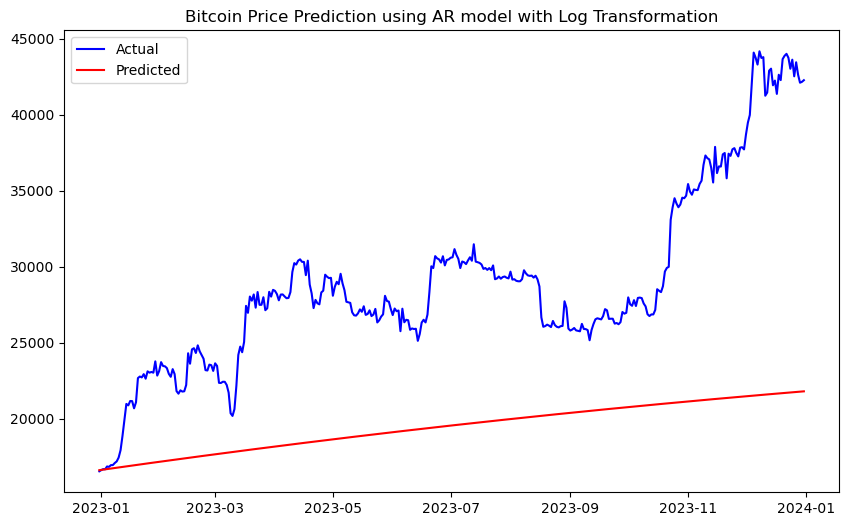

In [5]:
# AR Model 3 for Bitcoin
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.eval_measures import aic
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Read data
data_btc = pd.read_csv(r"C:\Users\emily\Desktop\BTC-USD.csv", parse_dates=['Date'], index_col='Date')

# Apply logarithmic transformation to stabilize variance
data_btc['LogPrice'] = np.log(data_btc['Close'])

# Split data into training and testing sets
train_size = int(len(data_btc) * 0.8)
train, test = data_btc['LogPrice'][:train_size], data_btc['LogPrice'][train_size:]

# Try different lag parameters and evaluate the model
best_aic = np.inf
best_lag = None
best_model = None

for lag in range(1, 11):  # Test lag values from 1 to 10
    model = AutoReg(train, lags=lag).fit()
    # Calculate AIC
    if model.aic < best_aic:
        best_aic = model.aic
        best_lag = lag
        best_model = model

print(f"Best Lag: {best_lag}")
print(f"Best AIC: {best_aic}")

# Make predictions
predictions = best_model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# Prepare actual and predicted values for error calculation
test_cumsum = test.values
predictions_cumsum = predictions.values

# Apply exponential transformation to revert the log transformation
test_cumsum_exp = np.exp(test_cumsum)
predictions_exp = np.exp(predictions_cumsum)

# Calculate error metrics
mse = mean_squared_error(test_cumsum_exp, predictions_exp)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_cumsum_exp, predictions_exp)
r_squared = r2_score(test_cumsum_exp, predictions_exp)
aic_value = best_model.aic

# Output results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r_squared}")
print(f"Akaike Information Criterion (AIC): {aic_value}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(data_btc.index[train_size:], test_cumsum_exp, label='Actual', color='blue')
plt.plot(data_btc.index[train_size:], predictions_exp, label='Predicted', color='red')
plt.title('Bitcoin Price Prediction using AR Model with Log Transformation')
plt.legend()
plt.show()


In [17]:
# BTD AR MOdel Comparison
import pandas as pd

# Assume actual values (in this example, actual values are randomly generated; replace with real data)
actual_values = [10000] * 365  # Replace with your actual data

# Model performance metrics
metrics = {
    "Model 1": {
        "Mean Squared Error (MSE)": 92741845.0172839,
        "Root Mean Squared Error (RMSE)": 9630.2567472152,
        "Mean Absolute Error (MAE)": 8455.969606038367,
        "R²": -1.6473016933597746,
        "Akaike Information Criterion (AIC)": 24460.084680996843
    },
    "Model 2": {
        "Mean Squared Error (MSE)": 141514830.89903507,
        "Root Mean Squared Error (RMSE)": 11896.000626220355,
        "Mean Absolute Error (MAE)": 10688.389637344058,
        "R²": -3.0583618156431243,
        "Akaike Information Criterion (AIC)": 24461.56326800982
    },
    "Model 3": {
        "Mean Squared Error (MSE)": 111260073.65219712,
        "Root Mean Squared Error (RMSE)": 10547.989080966909,
        "Mean Absolute Error (MAE)": 9384.041073651957,
        "R²": -2.175901679850153,
        "Akaike Information Criterion (AIC)": -5401.914019035728
    }
   
}

# Create a DataFrame for comparison
metrics_df = pd.DataFrame(metrics)

# Display the DataFrame as a table
print(metrics_df.to_string(index=True))


                                         Model 1       Model 2       Model 3
Mean Squared Error (MSE)            9.274185e+07  1.415148e+08  1.112601e+08
Root Mean Squared Error (RMSE)      9.630257e+03  1.189600e+04  1.054799e+04
Mean Absolute Error (MAE)           8.455970e+03  1.068839e+04  9.384041e+03
R²                                 -1.647302e+00 -3.058362e+00 -2.175902e+00
Akaike Information Criterion (AIC)  2.446008e+04  2.446156e+04 -5.401914e+03


C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

Best Lag: 2
Best AIC: -4034.4245747958403
Mean Squared Error (MSE): 160692.70373277285
Root Mean Squared Error (RMSE): 400.86494450472077
Mean Absolute Error (MAE): 343.9946105426597
R-squared (R²): -1.005541710135684
Akaike Information Criterion (AIC): -4034.4245747958403


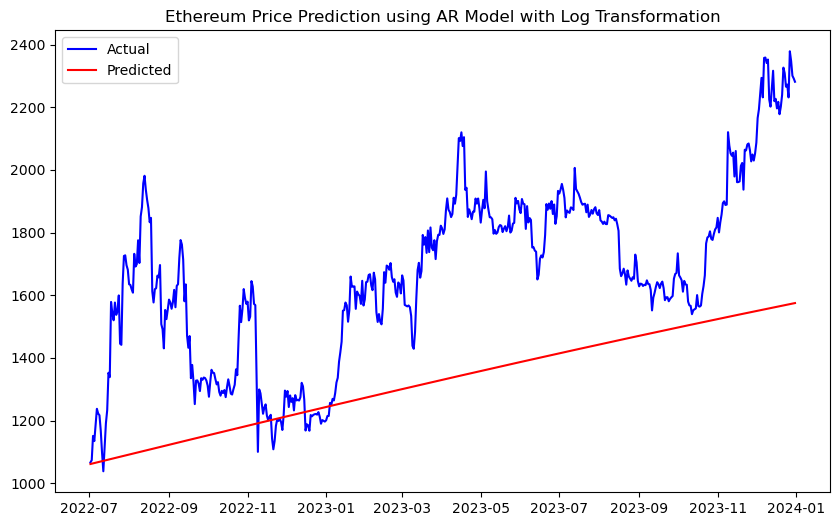

In [67]:
# AR Model 1 for Ethereum
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.eval_measures import aic
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Read the Ethereum data
data_eth = pd.read_csv(r"C:\Users\emily\Desktop\ETH-USD.csv", parse_dates=['Date'], index_col='Date')

# Take the logarithm to stabilize variance
data_eth['LogPrice'] = np.log(data_eth['Close'])

# Split into training and testing sets
train_size = int(len(data_eth) * 0.7)
train, test = data_eth['LogPrice'][:train_size], data_eth['LogPrice'][train_size:]

# Evaluate different lag parameters for the AR model
best_aic = np.inf
best_lag = None
best_model = None

for lag in range(1, 11):  # Testing lag values from 1 to 10
    model = AutoReg(train, lags=lag).fit()
    # Calculate AIC
    if model.aic < best_aic:
        best_aic = model.aic
        best_lag = lag
        best_model = model

print(f"Best Lag: {best_lag}")
print(f"Best AIC: {best_aic}")

# Make predictions
predictions = best_model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# Calculate performance metrics
test_cumsum = test.values
predictions_cumsum = predictions.values

# Reverse log transformation
test_cumsum_exp = np.exp(test_cumsum)
predictions_exp = np.exp(predictions_cumsum)

# Calculate error metrics
mse = mean_squared_error(test_cumsum_exp, predictions_exp)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_cumsum_exp, predictions_exp)
r_squared = r2_score(test_cumsum_exp, predictions_exp)
aic_value = best_model.aic

# Output results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r_squared}")
print(f"Akaike Information Criterion (AIC): {aic_value}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(data_eth.index[train_size:], test_cumsum_exp, label='Actual', color='blue')
plt.plot(data_eth.index[train_size:], predictions_exp, label='Predicted', color='red')
plt.title('Ethereum Price Prediction using AR Model with Log Transformation')
plt.legend()
plt.show()


C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

Best Lag: 2
Best AIC: -4643.7837177611755
Mean Squared Error (MSE): 220989.3770173892
Root Mean Squared Error (RMSE): 470.09507231770596
Mean Absolute Error (MAE): 432.5205760812852
R-squared (R²): -3.5297656234442085
Akaike Information Criterion (AIC): -4643.7837177611755


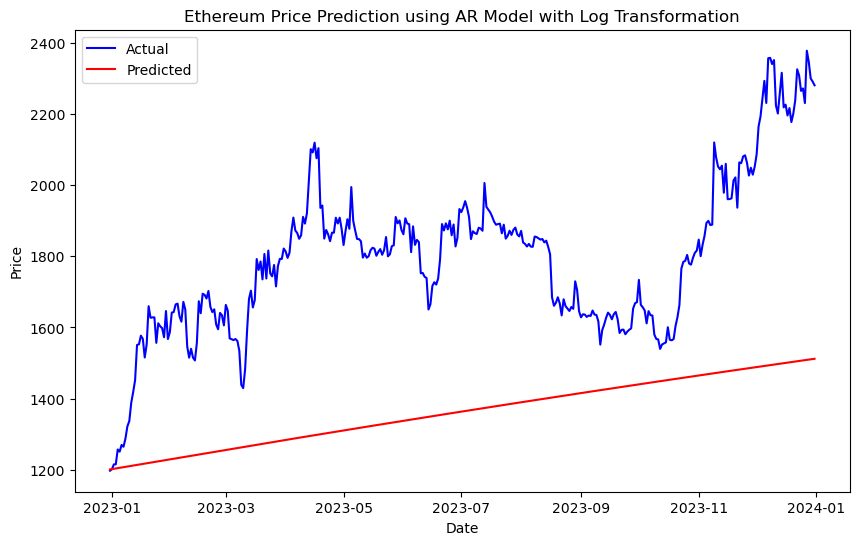

In [78]:
# AR Model 2 for Ethereum
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.eval_measures import aic
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def load_data(filepath):
    """Load Ethereum data and return a DataFrame with logarithm of prices."""
    data_eth = pd.read_csv(filepath, parse_dates=['Date'], index_col='Date')
    data_eth['LogPrice'] = np.log(data_eth['Close'])
    return data_eth

def split_data(data, train_size=0.8):
    """Split data into training and testing sets."""
    train_index = int(len(data) * train_size)
    return data['LogPrice'][:train_index], data['LogPrice'][train_index:]

def evaluate_models(train, max_lag=20):
    """Evaluate AR models with different lags and return the best model."""
    best_aic = np.inf
    best_lag = None
    best_model = None
    
    for lag in range(1, max_lag + 1):
        model = AutoReg(train, lags=lag).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_lag = lag
            best_model = model
            
    return best_model, best_lag, best_aic

def calculate_metrics(test, predictions):
    """Calculate performance metrics."""
    test_cumsum_exp = np.exp(test.values)
    predictions_exp = np.exp(predictions.values)

    mse = mean_squared_error(test_cumsum_exp, predictions_exp)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_cumsum_exp, predictions_exp)
    r_squared = r2_score(test_cumsum_exp, predictions_exp)

    return mse, rmse, mae, r_squared

def plot_results(test, predictions, train_size):
    """Plot actual vs predicted values."""
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, np.exp(test.values), label='Actual', color='blue')
    plt.plot(test.index, np.exp(predictions.values), label='Predicted', color='red')
    plt.title('Ethereum Price Prediction using AR Model with Log Transformation')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def main():
    # Load and prepare data
    data_eth = load_data(r"C:\Users\emily\Desktop\ETH-USD.csv")
    train, test = split_data(data_eth)

    # Evaluate models
    best_model, best_lag, best_aic = evaluate_models(train)
    print(f"Best Lag: {best_lag}")
    print(f"Best AIC: {best_aic}")

    # Make predictions
    predictions = best_model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

    # Calculate and display performance metrics
    mse, rmse, mae, r_squared = calculate_metrics(test, predictions)
    aic_value = best_model.aic

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R²): {r_squared}")
    print(f"Akaike Information Criterion (AIC): {aic_value}")

    # Plot results
    plot_results(test, predictions, len(train))

if __name__ == "__main__":
    main()


C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emily\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

Best Lag: 2
Best AIC: -4643.7837177611755
Mean Squared Error (MSE): 220989.3770173892
Root Mean Squared Error (RMSE): 470.09507231770596
Mean Absolute Error (MAE): 432.5205760812852
R-squared (R²): -3.5297656234442085
Akaike Information Criterion (AIC): -4013.551993564472


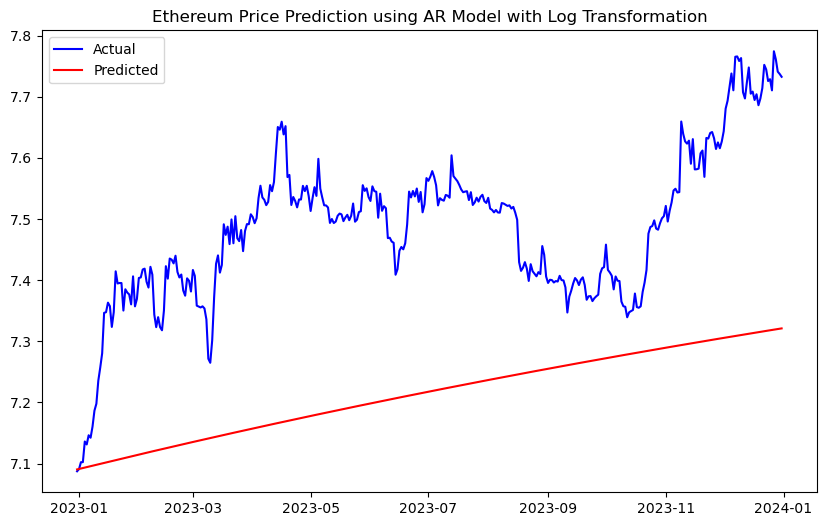

In [71]:
# ETH AR Model 3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def load_data(file_path):
    """Load Ethereum data from CSV."""
    return pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

def preprocess_data(data):
    """Apply log transformation to stabilize variance."""
    data['LogPrice'] = np.log(data['Close'])
    return data

def split_data(data, train_ratio=0.8):
    """Split data into training and testing sets."""
    train_size = int(len(data) * train_ratio)
    return data['LogPrice'][:train_size], data['LogPrice'][train_size:]

def find_best_lag(train, max_lag=10):
    """Evaluate different lag parameters for the AR model and return the best model."""
    best_aic = np.inf
    best_lag = None
    best_model = None

    for lag in range(1, max_lag + 1):
        model = AutoReg(train, lags=lag).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_lag = lag
            best_model = model

    return best_model, best_lag, best_aic

def evaluate_model(model, train_size, test_size):
    """Make predictions and calculate performance metrics."""
    predictions = model.predict(start=len(train), end=len(train) + test_size - 1, dynamic=False)
    
    return predictions

def calculate_metrics(test, predictions):
    """Calculate and return error metrics."""
    test_exp = np.exp(test.values)
    predictions_exp = np.exp(predictions.values)

    mse = mean_squared_error(test_exp, predictions_exp)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_exp, predictions_exp)
    r_squared = r2_score(test_exp, predictions_exp)
    aic_value = model.aic

    return mse, rmse, mae, r_squared, aic_value

def plot_results(actual, predicted, train_size):
    """Plot actual vs predicted values."""
    plt.figure(figsize=(10, 6))
    plt.plot(actual.index[train_size:], actual.values[train_size:], label='Actual', color='blue')
    plt.plot(actual.index[train_size:], predicted.values, label='Predicted', color='red')
    plt.title('Ethereum Price Prediction using AR Model with Log Transformation')
    plt.legend()
    plt.show()

# Main execution flow
file_path = r"C:\Users\emily\Desktop\ETH-USD.csv"
data_eth = load_data(file_path)
data_eth = preprocess_data(data_eth)
train, test = split_data(data_eth)

best_model, best_lag, best_aic = find_best_lag(train)
print(f"Best Lag: {best_lag}")
print(f"Best AIC: {best_aic}")

predictions = evaluate_model(best_model, len(train), len(test))

mse, rmse, mae, r_squared, aic_value = calculate_metrics(test, predictions)

# Output results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r_squared}")
print(f"Akaike Information Criterion (AIC): {aic_value}")

plot_results(data_eth['LogPrice'], predictions, len(train))


In [8]:
# ETH AR Model Comparison

import pandas as pd
from tabulate import tabulate

# Data for the three models
data = {
    "Metric": ["Best Lag", "Best AIC", "MSE", "RMSE", "MAE", "R-squared", "AIC"],
    "Model 1": [2, -4034.42, 160692.70, 400.86, 343.99, -1.01, -4034.42],
    "Model 2": [2, -4643.78, 220989.38, 470.10, 432.52, -3.53, -4643.78],
    "Model 3": [2, -4643.78, 220989.38, 470.10, 432.52, -3.53, -4013.55]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the table with grid lines
print(tabulate(df, headers='keys', tablefmt='grid'))


+----+-----------+-----------+-----------+-----------+
|    | Metric    |   Model 1 |   Model 2 |   Model 3 |
+====+===========+===========+===========+===========+
|  0 | Best Lag  |      2    |      2    |      2    |
+----+-----------+-----------+-----------+-----------+
|  1 | Best AIC  |  -4034.42 |  -4643.78 |  -4643.78 |
+----+-----------+-----------+-----------+-----------+
|  2 | MSE       | 160693    | 220989    | 220989    |
+----+-----------+-----------+-----------+-----------+
|  3 | RMSE      |    400.86 |    470.1  |    470.1  |
+----+-----------+-----------+-----------+-----------+
|  4 | MAE       |    343.99 |    432.52 |    432.52 |
+----+-----------+-----------+-----------+-----------+
|  5 | R-squared |     -1.01 |     -3.53 |     -3.53 |
+----+-----------+-----------+-----------+-----------+
|  6 | AIC       |  -4034.42 |  -4643.78 |  -4013.55 |
+----+-----------+-----------+-----------+-----------+


SMA Performance Metrics:
MSE: 7088760.40
RMSE: 2662.47
MAE: 1662.60
R²: 0.97
AIC: 28507.66

EMA Performance Metrics:
MSE: 5256381.19
RMSE: 2292.68
MAE: 1458.99
R²: 0.98
AIC: 27967.24


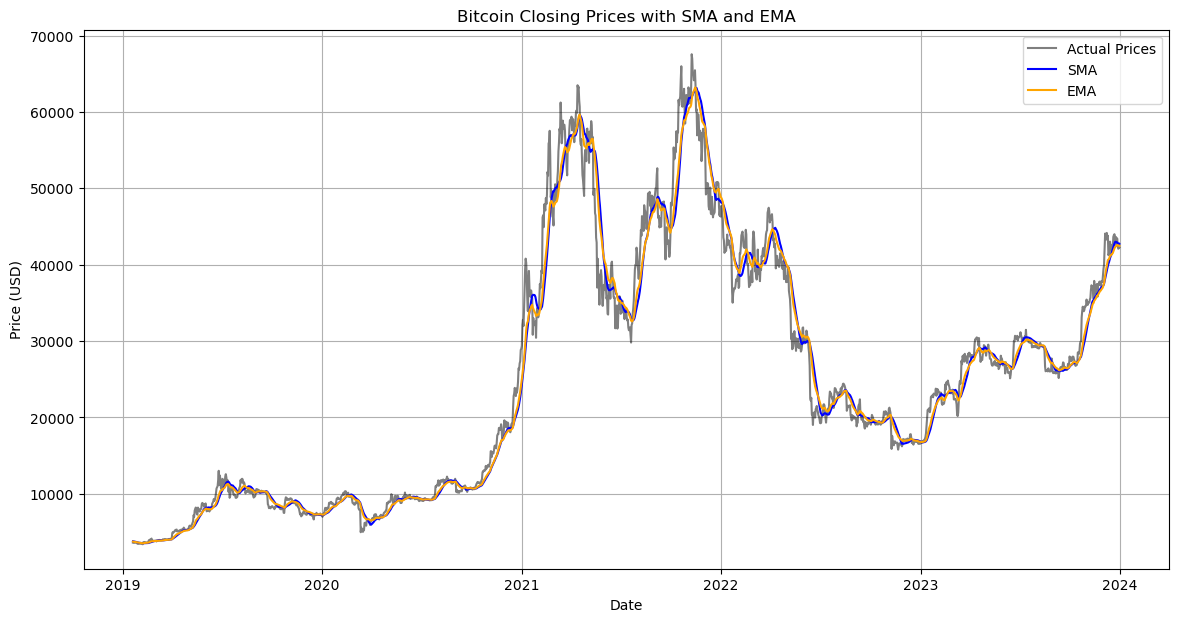

In [15]:
#Time series analysis
#BTC SMA,EMA Model 1
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the dataset
file_path = r"C:\Users\emily\Desktop\BTC-USD.csv"
data = pd.read_csv(file_path)

# Ensure the date column is in datetime format and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Use the 'Close' price for predictions
prices = data['Close']

# Calculate SMA and EMA
sma_window = 20  # You can adjust the window size
ema_window = 20  # You can adjust the window size
data['SMA'] = prices.rolling(window=sma_window).mean()
data['EMA'] = prices.ewm(span=ema_window, adjust=False).mean()

# Remove NaN values created by rolling calculations
data.dropna(inplace=True)

# Recreate the prices Series after dropping NaN values to ensure alignment
prices_aligned = prices[data.index]

# Compute performance metrics for SMA
sma_predictions = data['SMA']
mse_sma = mean_squared_error(prices_aligned, sma_predictions)
rmse_sma = np.sqrt(mse_sma)
mae_sma = mean_absolute_error(prices_aligned, sma_predictions)
r2_sma = r2_score(prices_aligned, sma_predictions)

# Compute performance metrics for EMA
ema_predictions = data['EMA']
mse_ema = mean_squared_error(prices_aligned, ema_predictions)
rmse_ema = np.sqrt(mse_ema)
mae_ema = mean_absolute_error(prices_aligned, ema_predictions)
r2_ema = r2_score(prices_aligned, ema_predictions)

# Calculate AIC for SMA and EMA models
def calculate_aic(n, mse):
    return n * np.log(mse) + 2 * 2  # 2 for the two parameters (SMA and EMA)

n = len(data)

aic_sma = calculate_aic(n, mse_sma)
aic_ema = calculate_aic(n, mse_ema)

# Print results
print("SMA Performance Metrics:")
print(f"MSE: {mse_sma:.2f}")
print(f"RMSE: {rmse_sma:.2f}")
print(f"MAE: {mae_sma:.2f}")
print(f"R²: {r2_sma:.2f}")
print(f"AIC: {aic_sma:.2f}")

print("\nEMA Performance Metrics:")
print(f"MSE: {mse_ema:.2f}")
print(f"RMSE: {rmse_ema:.2f}")
print(f"MAE: {mae_ema:.2f}")
print(f"R²: {r2_ema:.2f}")
print(f"AIC: {aic_ema:.2f}")

# Visualization
plt.figure(figsize=(14, 7))

# Use only the rows where SMA and EMA are not NaN for plotting
valid_data = data.dropna(subset=['SMA', 'EMA'])

plt.plot(valid_data.index, valid_data['Close'], label='Actual Prices', color='black', alpha=0.5)
plt.plot(valid_data.index, valid_data['SMA'], label='SMA', color='blue', linewidth=1.5)
plt.plot(valid_data.index, valid_data['EMA'], label='EMA', color='orange', linewidth=1.5)

plt.title('Bitcoin Closing Prices with SMA and EMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()




Best SMA Performance Metrics:
Window      5.000000e+00
SMA_MSE     1.253171e+06
SMA_RMSE    1.119451e+03
SMA_MAE     6.787339e+02
SMA_R2      9.951343e-01
SMA_AIC     2.558704e+04
EMA_MSE     8.578298e+05
EMA_RMSE    9.261910e+02
EMA_MAE     5.600509e+02
EMA_R2      9.966693e-01
EMA_AIC     2.489646e+04
Name: 0, dtype: float64

Best EMA Performance Metrics:
Window      5.000000e+00
SMA_MSE     1.253171e+06
SMA_RMSE    1.119451e+03
SMA_MAE     6.787339e+02
SMA_R2      9.951343e-01
SMA_AIC     2.558704e+04
EMA_MSE     8.578298e+05
EMA_RMSE    9.261910e+02
EMA_MAE     5.600509e+02
EMA_R2      9.966693e-01
EMA_AIC     2.489646e+04
Name: 0, dtype: float64


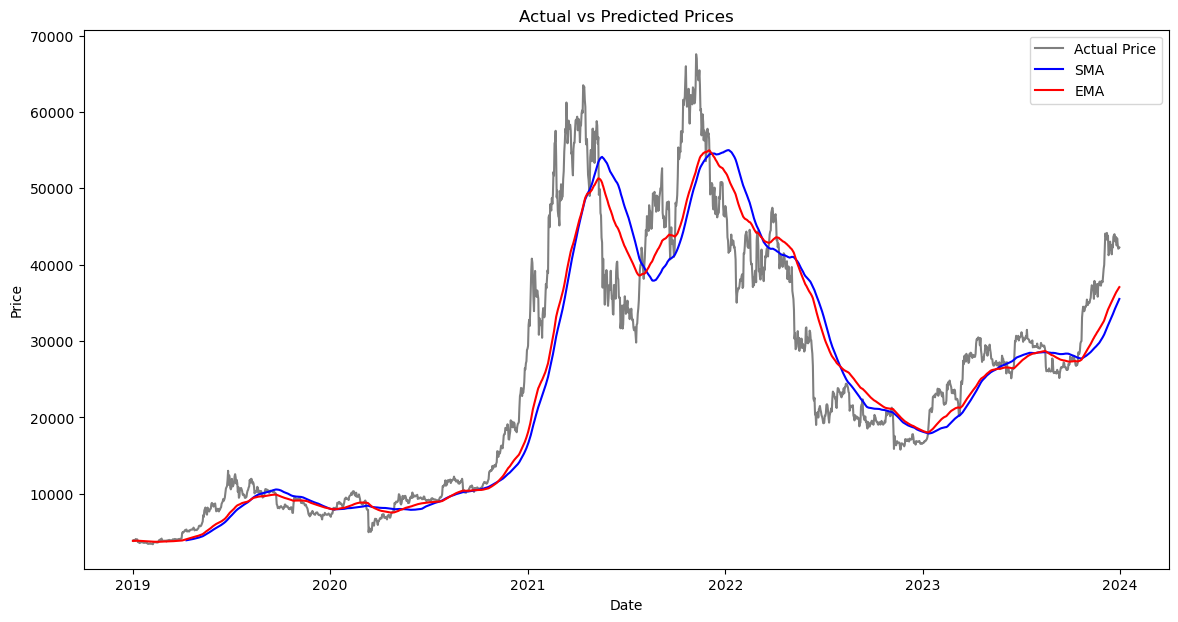

In [11]:
#BTC SMA,EMA Model 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
data = pd.read_csv(r'C:\Users\emily\Desktop\BTC-USD.csv')

# Convert the date column to datetime if necessary and set it as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Choose a range of window sizes to optimize
window_sizes = range(5, 101, 5)  # From 5 to 100 with a step of 5
performance_metrics = []

for window in window_sizes:
    # Calculate SMA
    data['SMA'] = data['Close'].rolling(window=window).mean()
    
    # Calculate EMA
    data['EMA'] = data['Close'].ewm(span=window, adjust=False).mean()
    
    # Remove NaN values for metrics calculation
    sma_valid = data['SMA'][window-1:]  # start from the first valid SMA
    ema_valid = data['EMA'][window-1:]  # start from the first valid EMA
    prices_valid = data['Close'][window-1:]  # corresponding valid prices

    # Calculate performance metrics for SMA
    mse_sma = mean_squared_error(prices_valid, sma_valid)
    rmse_sma = np.sqrt(mse_sma)
    mae_sma = mean_absolute_error(prices_valid, sma_valid)
    r2_sma = r2_score(prices_valid, sma_valid)
    aic_sma = len(prices_valid) * np.log(mse_sma) + 2 * 2  # 2 parameters (mean and variance)

    # Calculate performance metrics for EMA
    mse_ema = mean_squared_error(prices_valid, ema_valid)
    rmse_ema = np.sqrt(mse_ema)
    mae_ema = mean_absolute_error(prices_valid, ema_valid)
    r2_ema = r2_score(prices_valid, ema_valid)
    aic_ema = len(prices_valid) * np.log(mse_ema) + 2 * 2  # 2 parameters (mean and variance)

    # Store performance metrics
    performance_metrics.append({
        'Window': window,
        'SMA_MSE': mse_sma,
        'SMA_RMSE': rmse_sma,
        'SMA_MAE': mae_sma,
        'SMA_R2': r2_sma,
        'SMA_AIC': aic_sma,
        'EMA_MSE': mse_ema,
        'EMA_RMSE': rmse_ema,
        'EMA_MAE': mae_ema,
        'EMA_R2': r2_ema,
        'EMA_AIC': aic_ema
    })

# Convert to DataFrame
performance_df = pd.DataFrame(performance_metrics)

# Find the best window size for both SMA and EMA based on MSE
best_sma = performance_df.loc[performance_df['SMA_MSE'].idxmin()]
best_ema = performance_df.loc[performance_df['EMA_MSE'].idxmin()]

print("Best SMA Performance Metrics:")
print(best_sma)

print("\nBest EMA Performance Metrics:")
print(best_ema)

# Visualization of actual vs predicted
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Actual Price', color='black', alpha=0.5)
plt.plot(data.index, data['SMA'], label='SMA', color='blue')
plt.plot(data.index, data['EMA'], label='EMA', color='red')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


  Metric           SMA            EMA
0    MSE  1.253171e+06  857829.756838
1   RMSE  1.119451e+03     926.190994
2    MAE  6.787339e+02     560.050932
3     R²  9.951424e-01       0.996677
4    AIC  3.074965e+04   30054.817219


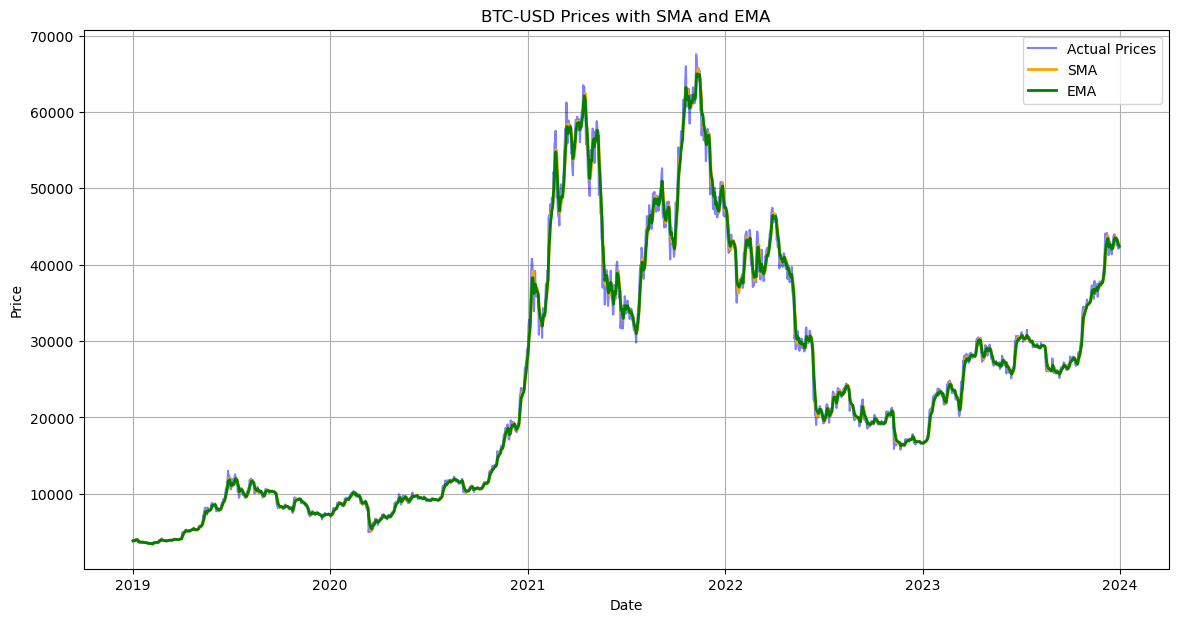

In [13]:
#BTC SMA,EMA Model 3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm

# Load the dataset
data = pd.read_csv(r'C:\Users\emily\Desktop\BTC-USD.csv')

# Ensure the date column is in datetime format and sort the data
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Calculate SMA and EMA
window_size = 5
data['SMA'] = data['Close'].rolling(window=window_size).mean()
data['EMA'] = data['Close'].ewm(span=window_size, adjust=False).mean()

# Drop NaN values for metrics calculation
valid_data = data[['Close', 'SMA', 'EMA']].dropna()

# Define a function to calculate performance metrics
def calculate_metrics(true_values, predictions):
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predictions)
    # Fit model for R² and AIC
    model = sm.OLS(predictions, sm.add_constant(true_values)).fit()
    r_squared = model.rsquared
    aic = model.aic
    return mse, rmse, mae, r_squared, aic

# Calculate performance metrics for SMA and EMA
sma_metrics = calculate_metrics(valid_data['Close'], valid_data['SMA'])
ema_metrics = calculate_metrics(valid_data['Close'], valid_data['EMA'])

# Prepare a summary of results
metrics_summary = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²', 'AIC'],
    'SMA': sma_metrics,
    'EMA': ema_metrics
})

# Print the summary
print(metrics_summary)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Close'], label='Actual Prices', color='blue', alpha=0.5)
plt.plot(data['Date'], data['SMA'], label='SMA', color='orange', linewidth=2)
plt.plot(data['Date'], data['EMA'], label='EMA', color='green', linewidth=2)
plt.title('BTC-USD Prices with SMA and EMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()



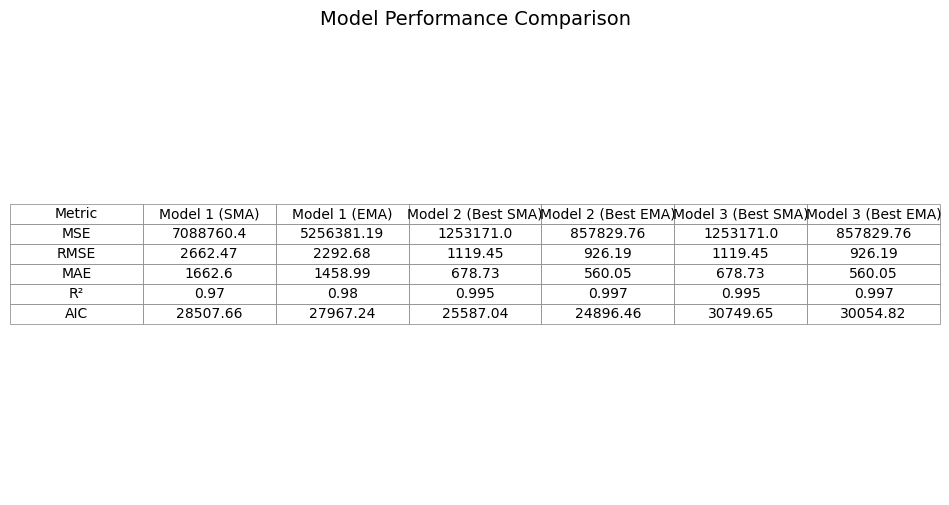

In [16]:
# BTC SMA&EMA Model Performance Comparison
import matplotlib.pyplot as plt
import pandas as pd

# Create a dictionary of model performance metrics
data = {
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²', 'AIC'],
    'Model 1 (SMA)': [7088760.40, 2662.47, 1662.60, 0.97, 28507.66],
    'Model 1 (EMA)': [5256381.19, 2292.68, 1458.99, 0.98, 27967.24],
    'Model 2 (Best SMA)': [1253171.00, 1119.45, 678.73, 0.995, 25587.04],
    'Model 2 (Best EMA)': [857829.76, 926.19, 560.05, 0.997, 24896.46],
    'Model 3 (Best SMA)': [1253171.00, 1119.45, 678.73, 0.995, 30749.65],
    'Model 3 (Best EMA)': [857829.76, 926.19, 560.05, 0.997, 30054.82]
}

# Convert the data to a DataFrame
df = pd.DataFrame(data)

# Create the table
plt.figure(figsize=(10, 6))
plt.axis('tight')
plt.axis('off')
table = plt.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Add grid lines to the table
for key, cell in table.get_celld().items():
    cell.set_edgecolor('gray')
    cell.set_linewidth(0.5)

plt.title('Model Performance Comparison', fontsize=14)
plt.show()


SMA Performance Metrics:
MSE: 38303.79
RMSE: 195.71
MAE: 115.49
R²: 0.97
AIC: 19073.82

EMA Performance Metrics:
MSE: 27756.17
RMSE: 166.60
MAE: 98.83
R²: 0.98
AIC: 18491.80


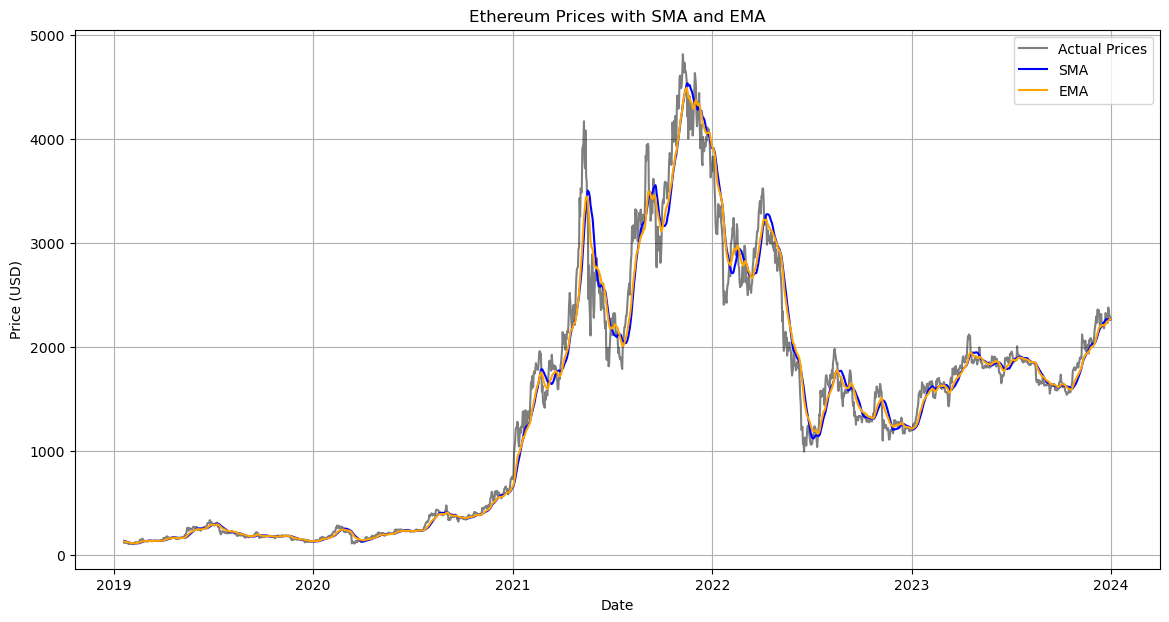

In [18]:
# ETH SMA&EMA Model 1
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the dataset
file_path = r"C:\Users\emily\Desktop\ETH-USD.csv"
data = pd.read_csv(file_path)

# Ensure the date column is in datetime format and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Use the 'Close' price for predictions
prices = data['Close']

# Set window size for SMA and EMA
sma_window = 20
ema_window = 20

# Calculate SMA and EMA
data['SMA'] = prices.rolling(window=sma_window).mean()
data['EMA'] = prices.ewm(span=ema_window, adjust=False).mean()

# Remove NaN values created by rolling calculations
data.dropna(inplace=True)

# Recreate the prices Series after dropping NaN values to ensure alignment
prices_aligned = prices[data.index]

# Compute performance metrics for SMA
sma_predictions = data['SMA']
mse_sma = mean_squared_error(prices_aligned, sma_predictions)
rmse_sma = np.sqrt(mse_sma)
mae_sma = mean_absolute_error(prices_aligned, sma_predictions)
r2_sma = r2_score(prices_aligned, sma_predictions)

# Compute performance metrics for EMA
ema_predictions = data['EMA']
mse_ema = mean_squared_error(prices_aligned, ema_predictions)
rmse_ema = np.sqrt(mse_ema)
mae_ema = mean_absolute_error(prices_aligned, ema_predictions)
r2_ema = r2_score(prices_aligned, ema_predictions)

# Calculate AIC for SMA and EMA models
def calculate_aic(n, mse):
    return n * np.log(mse) + 2 * 2  # 2 for the two parameters (SMA and EMA)

n = len(data)

aic_sma = calculate_aic(n, mse_sma)
aic_ema = calculate_aic(n, mse_ema)

# Print results
print("SMA Performance Metrics:")
print(f"MSE: {mse_sma:.2f}")
print(f"RMSE: {rmse_sma:.2f}")
print(f"MAE: {mae_sma:.2f}")
print(f"R²: {r2_sma:.2f}")
print(f"AIC: {aic_sma:.2f}")

print("\nEMA Performance Metrics:")
print(f"MSE: {mse_ema:.2f}")
print(f"RMSE: {rmse_ema:.2f}")
print(f"MAE: {mae_ema:.2f}")
print(f"R²: {r2_ema:.2f}")
print(f"AIC: {aic_ema:.2f}")

# Visualization
plt.figure(figsize=(14, 7))
plt.plot(data.index, prices[data.index], label='Actual Prices', color='black', alpha=0.5)  # Use only aligned prices
plt.plot(data.index, data['SMA'], label='SMA', color='blue', linewidth=1.5)
plt.plot(data.index, data['EMA'], label='EMA', color='orange', linewidth=1.5)
plt.title('Ethereum Prices with SMA and EMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()


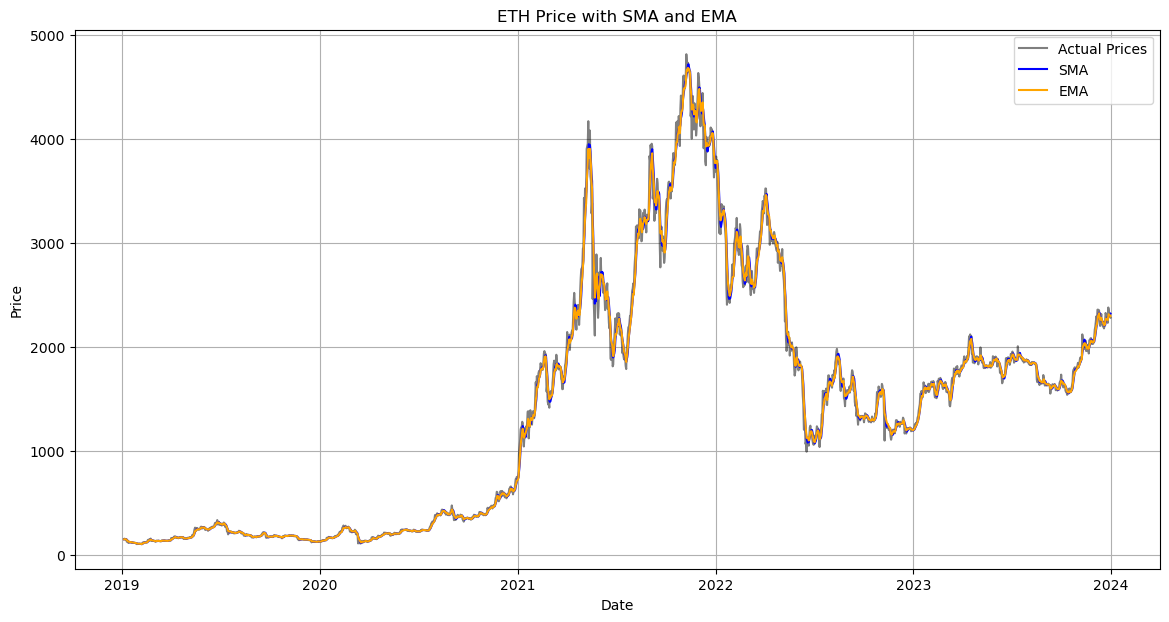

  Metric           SMA           EMA
0    MSE   7222.486887   4907.624871
1   RMSE     84.985216     70.054442
2    MAE     47.534160     39.043277
3     R²      0.994682      0.996386
4    AIC  21361.121195  20656.728137


In [20]:
# ETH SMA&EMA model 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the data
data = pd.read_csv(r'C:\Users\emily\Desktop\ETH-USD.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Define function to calculate SMA and EMA
def calculate_sma_ema(data, sma_window=5):
    data['SMA'] = data['Close'].rolling(window=sma_window).mean()
    data['EMA'] = data['Close'].ewm(span=sma_window, adjust=False).mean()
    return data

# Define function to calculate performance metrics
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    # Note: AIC calculation needs a model, using sm.OLS here to demonstrate
    model = sm.OLS(actual, sm.add_constant(predicted)).fit()
    aic = model.aic
    return mse, rmse, mae, r2, aic

# Calculate SMA and EMA
data = calculate_sma_ema(data)

# Ensure we have enough data for metrics (drop NaNs)
data.dropna(subset=['SMA', 'EMA'], inplace=True)

# Performance metrics for SMA
sma_metrics = calculate_metrics(data['Close'], data['SMA'])

# Performance metrics for EMA
ema_metrics = calculate_metrics(data['Close'], data['EMA'])

# Store results in a DataFrame
results_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²', 'AIC'],
    'SMA': sma_metrics,
    'EMA': ema_metrics
})

# Visualization
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Actual Prices', color='black', alpha=0.5)
plt.plot(data.index, data['SMA'], label='SMA', color='blue', linewidth=1.5)
plt.plot(data.index, data['EMA'], label='EMA', color='orange', linewidth=1.5)
plt.title('ETH Price with SMA and EMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Display results
print(results_df)



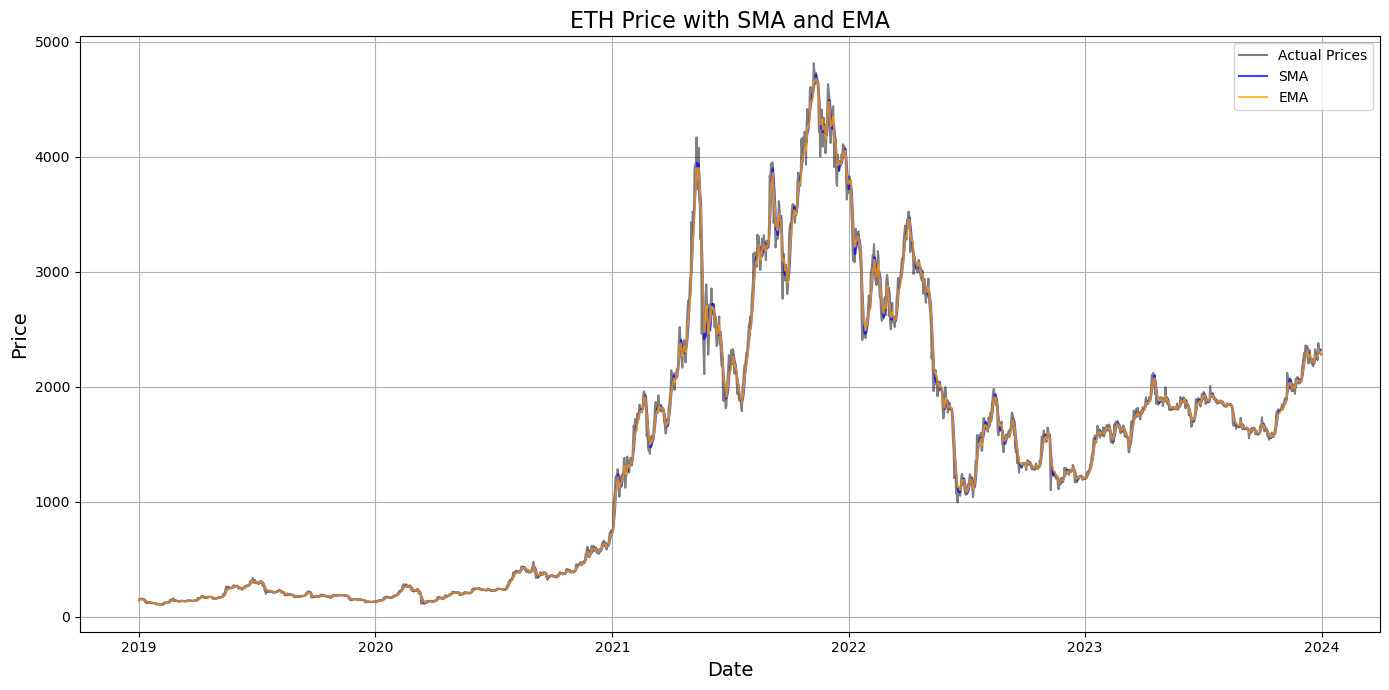

  Metric           SMA           EMA
0    MSE   7222.486887   4896.941623
1   RMSE     84.985216     69.978151
2    MAE     47.534160     38.967107
3     R²      0.994682      0.996396
4    AIC  16192.387312  15518.364555


In [22]:
#ETH SMA&EMA Model 3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the data
data = pd.read_csv(r'C:\Users\emily\Desktop\ETH-USD.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Configurable parameters
SMA_WINDOW = 5
EMA_WINDOW = 5

# Function to calculate SMA and EMA
def calculate_sma_ema(data, sma_window=SMA_WINDOW, ema_window=EMA_WINDOW):
    data['SMA'] = data['Close'].rolling(window=sma_window).mean()
    data['EMA'] = data['Close'].ewm(span=ema_window, adjust=False).mean()
    return data

# Function to calculate performance metrics
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    n = len(actual)
    aic = n * np.log(mse) + 2 * (2)  # Number of parameters = 2 (SMA/EMA and intercept)
    return mse, rmse, mae, r2, aic

# Calculate SMA and EMA
data = calculate_sma_ema(data)

# Drop NaN values for actual and predicted data for metrics calculation
sma_actual = data['Close'].dropna()
sma_predicted = data['SMA'].dropna()
ema_actual = data['Close'].dropna()
ema_predicted = data['EMA'].dropna()

# Align actual and predicted data
min_length_sma = min(len(sma_actual), len(sma_predicted))
min_length_ema = min(len(ema_actual), len(ema_predicted))

# Performance metrics for SMA and EMA
sma_metrics = calculate_metrics(sma_actual[-min_length_sma:], sma_predicted[-min_length_sma:])
ema_metrics = calculate_metrics(ema_actual[-min_length_ema:], ema_predicted[-min_length_ema:])

# Store results in a DataFrame
results_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²', 'AIC'],
    'SMA': sma_metrics,
    'EMA': ema_metrics
})

# Visualization
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Actual Prices', color='black', alpha=0.5)
plt.plot(data.index, data['SMA'], label='SMA', color='blue', linewidth=1.5, alpha=0.75)
plt.plot(data.index, data['EMA'], label='EMA', color='orange', linewidth=1.5, alpha=0.75)
plt.title('ETH Price with SMA and EMA', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()  # Ensure everything fits well
plt.show()

# Display results
print(results_df)


In [27]:
# Comparison for ETH SMA&EMA Model
import pandas as pd

# Data for the performance metrics
data = {
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²', 'AIC'],
    'Model 1 SMA': [38303.79, 195.71, 115.49, 0.97, 19073.82],
    'Model 1 EMA': [27756.17, 166.60, 98.83, 0.98, 18491.80],
    'Model 2 SMA': [7222.49, 84.99, 47.53, 0.994682, 21361.12],
    'Model 2 EMA': [4907.62, 70.05, 39.04, 0.996396, 20656.73],
    'Model 3 SMA': [7222.49, 84.99, 47.53, 0.994682, 16192.39],
    'Model 3 EMA': [4896.94, 69.98, 38.97, 0.996396, 15518.36],
}

# Create DataFrame
df = pd.DataFrame(data)

# Set the Metric column as the index
df.set_index('Metric', inplace=True)

# Display the comparison table
print("Performance Metrics Comparison Table:")
print(df.to_string(index=True))


Performance Metrics Comparison Table:
        Model 1 SMA  Model 1 EMA   Model 2 SMA   Model 2 EMA   Model 3 SMA   Model 3 EMA
Metric                                                                                  
MSE        38303.79     27756.17   7222.490000   4907.620000   7222.490000   4896.940000
RMSE         195.71       166.60     84.990000     70.050000     84.990000     69.980000
MAE          115.49        98.83     47.530000     39.040000     47.530000     38.970000
R²             0.97         0.98      0.994682      0.996396      0.994682      0.996396
AIC        19073.82     18491.80  21361.120000  20656.730000  16192.390000  15518.360000


         Date         Open         High          Low        Close  \
0  2019-01-01  3746.713379  3850.913818  3707.231201  3843.520020   
1  2019-01-02  3849.216309  3947.981201  3817.409424  3943.409424   
2  2019-01-03  3931.048584  3935.685059  3826.222900  3836.741211   
3  2019-01-04  3832.040039  3865.934570  3783.853760  3857.717529   
4  2019-01-05  3851.973877  3904.903076  3836.900146  3845.194580   

     Adj Close      Volume  
0  3843.520020  4324200990  
1  3943.409424  5244856836  
2  3836.741211  4530215219  
3  3857.717529  4847965467  
4  3845.194580  5137609824  


20:55:45 - cmdstanpy - INFO - Chain [1] start processing
20:55:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\emily\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\emily\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


MSE: 14531688.1504761
RMSE: 3812.045140141457
MAE: 2883.2522060999777
R²: 0.943660932789692
AIC: 30118.10388018598
             ds          yhat    yhat_lower    yhat_upper
1826 2024-01-01  39264.278852  34336.523505  44454.142237
1827 2024-01-02  39444.895503  34781.131831  44551.762935
1828 2024-01-03  39677.085170  34563.287209  44526.910313
1829 2024-01-04  39700.238214  35025.370108  44337.531768
1830 2024-01-05  39842.974395  34893.138683  44736.843873
1831 2024-01-06  39949.061333  35437.166449  44434.493172
1832 2024-01-07  40023.896880  34939.363212  44970.586233
1833 2024-01-08  40082.455432  35410.014141  45016.291445
1834 2024-01-09  40124.522324  35325.283805  45319.897079
1835 2024-01-10  40213.016086  35010.882695  44911.987775
1836 2024-01-11  40090.816951  34863.299731  45251.910842
1837 2024-01-12  40090.152170  35050.886741  44607.438568
1838 2024-01-13  40058.424163  35027.861250  45168.277338
1839 2024-01-14  40004.600321  35030.091310  44951.051048
1840 2024-01-15

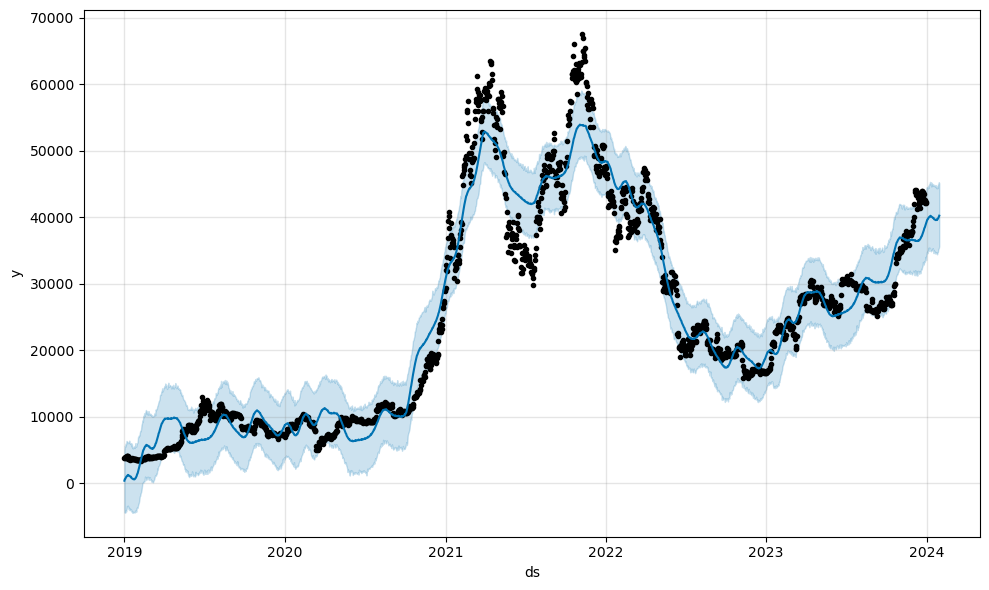

In [28]:
# BTC Prophet Model 1
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1. Load the data
file_path = r'C:\Users\emily\Desktop\BTC-USD.csv'
data = pd.read_csv(file_path)

# 2. Check the data
print(data.head())

# 3. Prepare the data (Prophet requires 'ds' and 'y' columns)
data['Date'] = pd.to_datetime(data['Date'])  # Ensure date format
data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)  # Use closing price
data = data[['ds', 'y']]  # Keep only the necessary columns

# 4. Train the Prophet model
model = Prophet()
model.fit(data)

# 5. Create a dataframe for future dates
future = model.make_future_dataframe(periods=30)  # Predict the next 30 days
forecast = model.predict(future)

# 6. Visualize the forecast results
model.plot(forecast)

# 7. Calculate performance metrics
# Only take the predictions part for performance calculations
predictions = forecast[['ds', 'yhat']].merge(data, on='ds', how='left').dropna()

mse = mean_squared_error(predictions['y'], predictions['yhat'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(predictions['y'], predictions['yhat'])
r_squared = r2_score(predictions['y'], predictions['yhat'])
n = len(predictions)
k = 2  # Number of free parameters (including intercept and slope)
aic = n * np.log(mse) + 2 * k

# 8. Print the performance metrics
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r_squared}")
print(f"AIC: {aic}")

# 9. Print the future predictions
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30))  # Print the forecast for the next 30 days


         Date         Open         High          Low        Close  \
0  2019-01-01  3746.713379  3850.913818  3707.231201  3843.520020   
1  2019-01-02  3849.216309  3947.981201  3817.409424  3943.409424   
2  2019-01-03  3931.048584  3935.685059  3826.222900  3836.741211   
3  2019-01-04  3832.040039  3865.934570  3783.853760  3857.717529   
4  2019-01-05  3851.973877  3904.903076  3836.900146  3845.194580   

     Adj Close      Volume  
0  3843.520020  4324200990  
1  3943.409424  5244856836  
2  3836.741211  4530215219  
3  3857.717529  4847965467  
4  3845.194580  5137609824  


20:57:59 - cmdstanpy - INFO - Chain [1] start processing
20:58:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\emily\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\emily\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


MSE: 6978845.425808422
RMSE: 2641.750447299749
MAE: 2015.062524791689
R²: 0.9729431544756836
AIC: 28778.82753398751


  0%|          | 0/48 [00:00<?, ?it/s]

20:58:01 - cmdstanpy - INFO - Chain [1] start processing
20:58:01 - cmdstanpy - INFO - Chain [1] done processing
20:58:01 - cmdstanpy - INFO - Chain [1] start processing
20:58:01 - cmdstanpy - INFO - Chain [1] done processing
20:58:01 - cmdstanpy - INFO - Chain [1] start processing
20:58:02 - cmdstanpy - INFO - Chain [1] done processing
20:58:02 - cmdstanpy - INFO - Chain [1] start processing
20:58:02 - cmdstanpy - INFO - Chain [1] done processing
20:58:02 - cmdstanpy - INFO - Chain [1] start processing
20:58:03 - cmdstanpy - INFO - Chain [1] done processing
20:58:03 - cmdstanpy - INFO - Chain [1] start processing
20:58:03 - cmdstanpy - INFO - Chain [1] done processing
20:58:03 - cmdstanpy - INFO - Chain [1] start processing
20:58:03 - cmdstanpy - INFO - Chain [1] done processing
20:58:04 - cmdstanpy - INFO - Chain [1] start processing
20:58:04 - cmdstanpy - INFO - Chain [1] done processing
20:58:04 - cmdstanpy - INFO - Chain [1] start processing
20:58:04 - cmdstanpy - INFO - Chain [1]

          ds         yhat   yhat_lower   yhat_upper            y     cutoff
0 2020-01-22  8540.515554  8069.570189  8997.475048  8680.875977 2020-01-21
1 2020-01-23  8470.961401  8000.714455  8910.196515  8406.515625 2020-01-21
2 2020-01-24  8561.528460  8100.200148  9035.503511  8445.434570 2020-01-21
3 2020-01-25  8580.989634  8130.878066  9040.599066  8367.847656 2020-01-21
4 2020-01-26  8580.220737  8112.062528  9092.052187  8596.830078 2020-01-21
             ds          yhat    yhat_lower    yhat_upper
1826 2024-01-01  39965.531637  36564.242709  43074.904539
1827 2024-01-02  40855.885170  37543.224960  44618.140630
1828 2024-01-03  41317.595567  38205.525091  44747.178647
1829 2024-01-04  41386.974550  38023.783225  44761.460981
1830 2024-01-05  41578.672537  38299.984950  44864.519257
1831 2024-01-06  41721.179304  38330.572791  45105.439762
1832 2024-01-07  41831.672630  38672.897455  45249.023535
1833 2024-01-08  41934.560830  38509.375519  45163.616242
1834 2024-01-09  42016

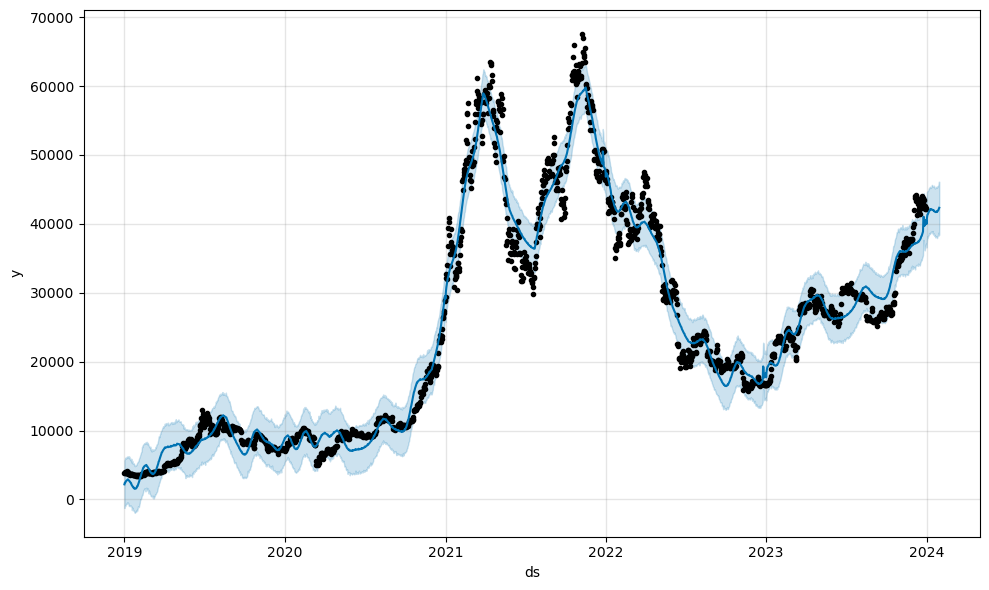

In [30]:
# BTC Prophet Model 2
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet.diagnostics import cross_validation

# 1. Load the data
file_path = r'C:\Users\emily\Desktop\BTC-USD.csv'
data = pd.read_csv(file_path)

# 2. Check the data
print(data.head())

# 3. Prepare the data (Prophet requires 'ds' and 'y' columns)
data['Date'] = pd.to_datetime(data['Date'])  # Ensure date format
data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)  # Use closing price
data = data[['ds', 'y']]  # Keep only the necessary columns

# 4. Manually create a holidays DataFrame
holidays = pd.DataFrame({
    'holiday': 'new_year',
    'ds': pd.to_datetime(['2021-01-01', '2022-01-01', '2023-01-01', '2024-01-01']),
    'lower_window': 0,
    'upper_window': 1,
})

# You can add more holidays as needed
additional_holidays = pd.DataFrame({
    'holiday': 'christmas',
    'ds': pd.to_datetime(['2021-12-25', '2022-12-25', '2023-12-25', '2024-12-25']),
    'lower_window': 0,
    'upper_window': 1,
})

holidays = pd.concat([holidays, additional_holidays])

# 5. Define and fit the Prophet model with optimizations
model = Prophet(
    growth='linear',  # You can change to 'logistic' if necessary with a cap
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=holidays,
    changepoint_prior_scale=0.1,  # Default is 0.05
    seasonality_prior_scale=10.0,  # Default is 10
    holidays_prior_scale=10.0  # Default is 10
)

model.fit(data)

# 6. Create a dataframe for future dates
future = model.make_future_dataframe(periods=30)  # Predict the next 30 days
forecast = model.predict(future)

# 7. Visualize the forecast results
model.plot(forecast)

# 8. Calculate performance metrics
# Only take the predictions part for performance calculations
predictions = forecast[['ds', 'yhat']].merge(data, on='ds', how='left').dropna()

mse = mean_squared_error(predictions['y'], predictions['yhat'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(predictions['y'], predictions['yhat'])
r_squared = r2_score(predictions['y'], predictions['yhat'])

n = len(predictions)
k = 2  # Number of free parameters (including intercept and slope)
aic = n * np.log(mse) + 2 * k

# 9. Print the performance metrics
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r_squared}")
print(f"AIC: {aic}")

# 10. Cross-validation
df_cv = cross_validation(model, initial='365 days', period='30 days', horizon='30 days')
print(df_cv.head())  # Check the cross-validation results

# 11. Print the future predictions
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30))  # Print the forecast for the next 30 days


21:04:13 - cmdstanpy - INFO - Chain [1] start processing
21:04:14 - cmdstanpy - INFO - Chain [1] done processing


Optimized Model Performance Metrics:
MSE: 14968380.461417526
RMSE: 3868.8991278421213
MAE: 2918.167562125611
R²: 0.9419678853473308
AIC: 30172.16873156816


C:\Users\emily\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\emily\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


<Figure size 1000x600 with 0 Axes>

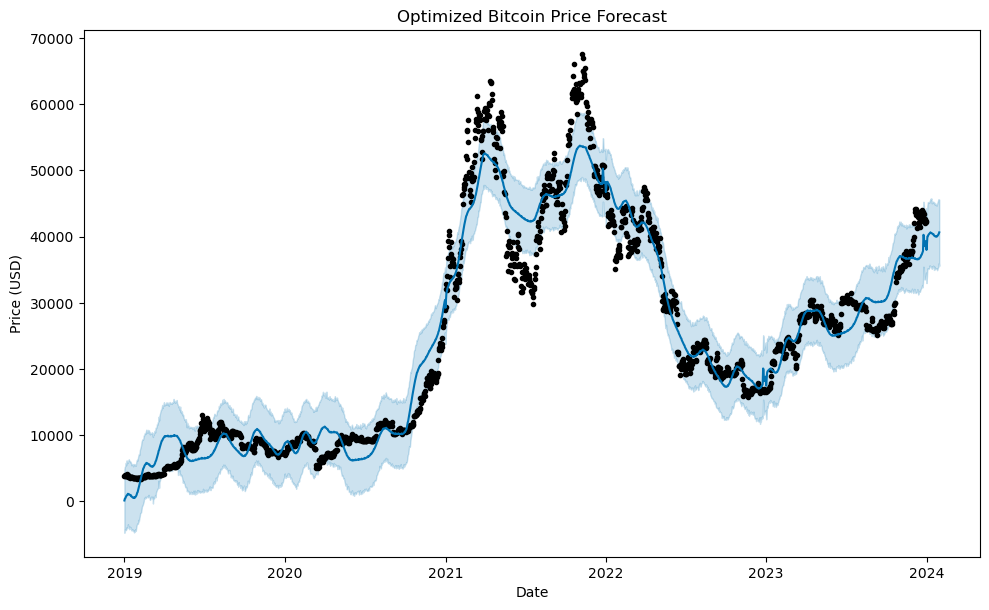

In [32]:
# BTC Prophet Model 3
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1. Load the data
file_path = r'C:\Users\emily\Desktop\BTC-USD.csv'
data = pd.read_csv(file_path)

# 2. Prepare the data (Prophet requires 'ds' and 'y' columns)
data['Date'] = pd.to_datetime(data['Date'])  # Ensure date format
data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)  # Use closing price
data = data[['ds', 'y']]  # Keep only the necessary columns

# 3. Create a holidays DataFrame
holidays = pd.DataFrame({
    'holiday': 'new_year',
    'ds': pd.to_datetime(['2021-01-01', '2022-01-01', '2023-01-01', '2024-01-01']),
    'lower_window': 0,
    'upper_window': 1,
})

additional_holidays = pd.DataFrame({
    'holiday': 'christmas',
    'ds': pd.to_datetime(['2021-12-25', '2022-12-25', '2023-12-25', '2024-12-25']),
    'lower_window': 0,
    'upper_window': 1,
})

holidays = pd.concat([holidays, additional_holidays])

# 4. Define and fit the optimized Prophet model
model_optimized = Prophet(
    growth='linear',  # Change to 'logistic' if necessary
    weekly_seasonality=True,
    yearly_seasonality=True,  # Adding yearly seasonality
    daily_seasonality=False,
    holidays=holidays,
    changepoint_prior_scale=0.05,  # Tuning this value can help capture trends
    seasonality_prior_scale=5.0,  # Default is 10
    holidays_prior_scale=10.0  # Default is 10
)

# Fit the model
model_optimized.fit(data)

# 5. Create a dataframe for future dates
future_optimized = model_optimized.make_future_dataframe(periods=30)  # Predict the next 30 days
forecast_optimized = model_optimized.predict(future_optimized)

# 6. Calculate performance metrics
# Only take the predictions part for performance calculations
predictions_optimized = forecast_optimized[['ds', 'yhat']].merge(data, on='ds', how='left').dropna()

# Calculate metrics
mse_optimized = mean_squared_error(predictions_optimized['y'], predictions_optimized['yhat'])
rmse_optimized = np.sqrt(mse_optimized)
mae_optimized = mean_absolute_error(predictions_optimized['y'], predictions_optimized['yhat'])
r_squared_optimized = r2_score(predictions_optimized['y'], predictions_optimized['yhat'])

# AIC Calculation
n_optimized = len(predictions_optimized)
k_optimized = 2  # Number of free parameters (intercept and slope)
aic_optimized = n_optimized * np.log(mse_optimized) + 2 * k_optimized

# 7. Print the performance metrics for the optimized model
print("Optimized Model Performance Metrics:")
print(f"MSE: {mse_optimized}")
print(f"RMSE: {rmse_optimized}")
print(f"MAE: {mae_optimized}")
print(f"R²: {r_squared_optimized}")
print(f"AIC: {aic_optimized}")

# 8. Visualize the forecast results
plt.figure(figsize=(10, 6))
model_optimized.plot(forecast_optimized)
plt.title('Optimized Bitcoin Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid()
plt.show()


In [33]:
# BTC Prophet Model Comparison
import pandas as pd

# Define the metrics for each model
model_metrics = {
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²', 'AIC'],
    'Model 1': [14531688.1504761, 3812.045140141457, 2883.2522060999777, 0.943660932789692, 30118.10388018598],
    'Model 2': [6978845.425808422, 2641.750447299749, 2015.062524791689, 0.9729431544756836, 28778.82753398751],
    'Model 3 Optimized': [
        14968380.461417526,  # MSE
        3868.8991278421213,  # RMSE
        2918.167562125611,    # MAE
        0.9419678853473308,   # R²
        30172.16873156816     # AIC
    ],
}

# Create a DataFrame
metrics_df = pd.DataFrame(model_metrics)

# Set the 'Metric' column as the index
metrics_df.set_index('Metric', inplace=True)

# Display the DataFrame
print(metrics_df)

# Optional: Save the DataFrame to a CSV file
metrics_df.to_csv('model_comparison_metrics.csv')


             Model 1       Model 2  Model 3 Optimized
Metric                                               
MSE     1.453169e+07  6.978845e+06       1.496838e+07
RMSE    3.812045e+03  2.641750e+03       3.868899e+03
MAE     2.883252e+03  2.015063e+03       2.918168e+03
R²      9.436609e-01  9.729432e-01       9.419679e-01
AIC     3.011810e+04  2.877883e+04       3.017217e+04


21:13:12 - cmdstanpy - INFO - Chain [1] start processing
21:13:12 - cmdstanpy - INFO - Chain [1] done processing


MSE: 6239521.576783837
RMSE: 2497.9034362408484
MAE: 2341.7859757537444
R²: -126.89560623554235
AIC: 5740.5875485289835


C:\Users\emily\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\emily\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


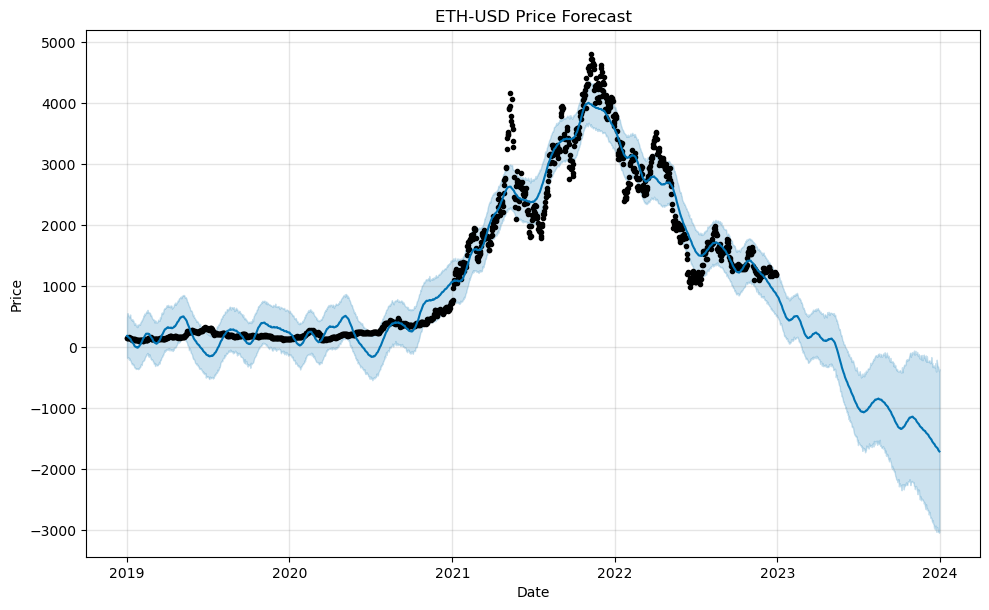

In [34]:
# ETH Prophet model 1
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Load the ETH-USD data
df = pd.read_csv('C:\\Users\\emily\\Desktop\\ETH-USD.csv')

# Prepare the data for Prophet
# Ensure the date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

# Define and fit the Prophet model
model = Prophet()
model.fit(train)

# Make predictions
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

# Merge the forecast with the test set
predictions = forecast[['ds', 'yhat']].set_index('ds')
predictions = predictions.loc[test['ds']]

# Calculate performance metrics
mse = mean_squared_error(test['y'], predictions['yhat'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['y'], predictions['yhat'])
r2 = r2_score(test['y'], predictions['yhat'])

# Calculate AIC (Akaike Information Criterion)
n = len(test)
k = len(model.params)  # Number of parameters in the model
aic = n * np.log(mse) + 2 * k

# Print performance metrics
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")
print(f"AIC: {aic}")

# Optional: Plot the forecast
import matplotlib.pyplot as plt

fig = model.plot(forecast)
plt.title('ETH-USD Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


21:15:21 - cmdstanpy - INFO - Chain [1] start processing
21:15:23 - cmdstanpy - INFO - Chain [1] done processing


MSE: 3830735.5862540365
RMSE: 1957.2265035641726
MAE: 1743.5390398751715
R²: -77.52112443283872
AIC: 5562.0356690551425


C:\Users\emily\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\emily\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


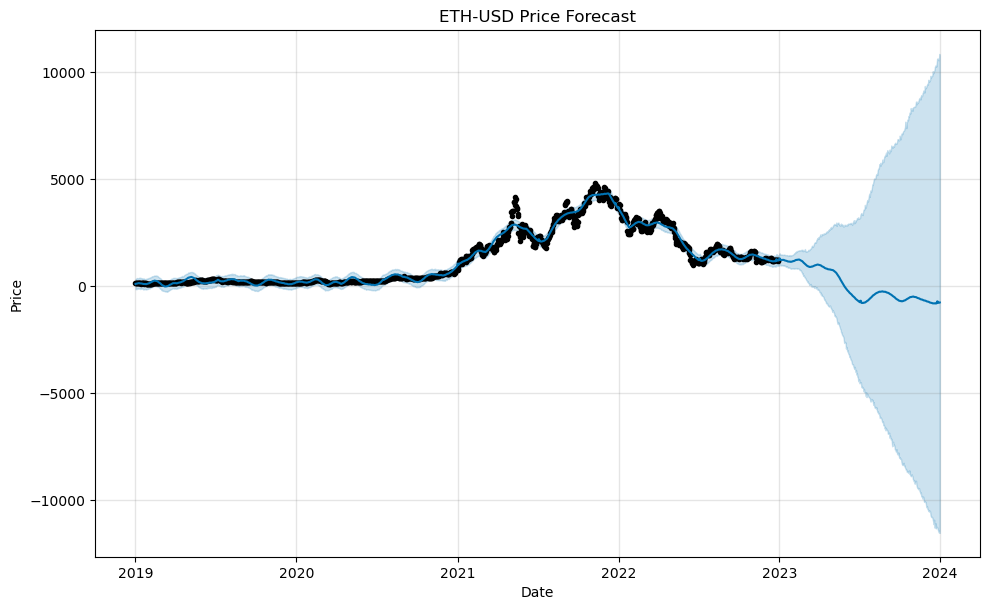

In [36]:
# ETH Prophet model 2
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Load the ETH-USD data
df = pd.read_csv('C:\\Users\\emily\\Desktop\\ETH-USD.csv')

# Prepare the data for Prophet
df['Date'] = pd.to_datetime(df['Date'])
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

# Create a DataFrame with holidays manually (for example, adding some US holidays)
holidays = pd.DataFrame({
    'holiday': 'US_Holidays',
    'ds': pd.to_datetime(['2021-01-01', '2021-07-04', '2021-12-25',  # New Year's Day, Independence Day, Christmas
                          '2022-01-01', '2022-07-04', '2022-12-25',
                          '2023-01-01', '2023-07-04', '2023-12-25',
                          '2024-01-01', '2024-07-04', '2024-12-25']),
    'lower_window': 0,
    'upper_window': 1,
})

# Define and fit the Prophet model with optimizations
model = Prophet(
    growth='linear',
    yearly_seasonality=True,   # Enable yearly seasonality
    weekly_seasonality=True,    # Enable weekly seasonality
    daily_seasonality=False,     # Disable daily seasonality
    holidays=holidays,          # Include holidays
    seasonality_prior_scale=10.0,  # Adjust seasonality prior scale
    holidays_prior_scale=10.0,      # Adjust holidays prior scale
    changepoint_prior_scale=0.5,     # Adjust changepoint prior scale
)

# Fit the model
model.fit(train)

# Make predictions
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

# Merge the forecast with the test set
predictions = forecast[['ds', 'yhat']].set_index('ds')
predictions = predictions.loc[test['ds']]

# Calculate performance metrics
mse = mean_squared_error(test['y'], predictions['yhat'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['y'], predictions['yhat'])
r2 = r2_score(test['y'], predictions['yhat'])

# Calculate AIC (Akaike Information Criterion)
n = len(test)
k = len(model.params)  # Number of parameters in the model
aic = n * np.log(mse) + 2 * k

# Print performance metrics
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")
print(f"AIC: {aic}")

# Optional: Plot the forecast
fig = model.plot(forecast)
plt.title('ETH-USD Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


21:16:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:16:57 - cmdstanpy - INFO - CmdStan done processing.
21:16:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to l


MSE: 493762.692425655
RMSE: 702.6824975945075
MAE: 625.5706538426791
R²: -9.120980928929413
AIC: 4824.1905701826945


C:\Users\emily\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\emily\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


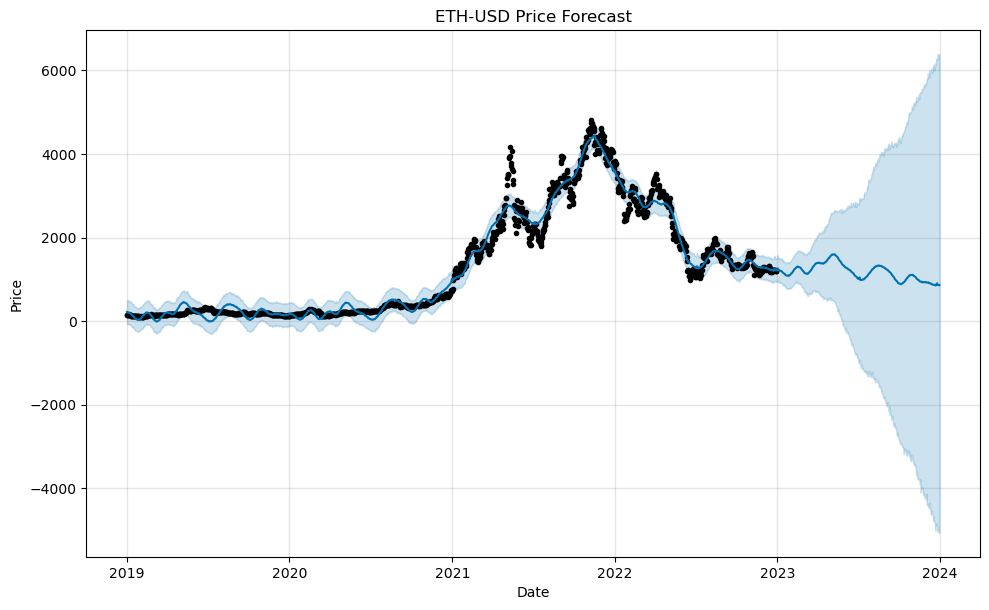

C:\Users\emily\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\emily\anaconda3\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\emily\anaconda3\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np

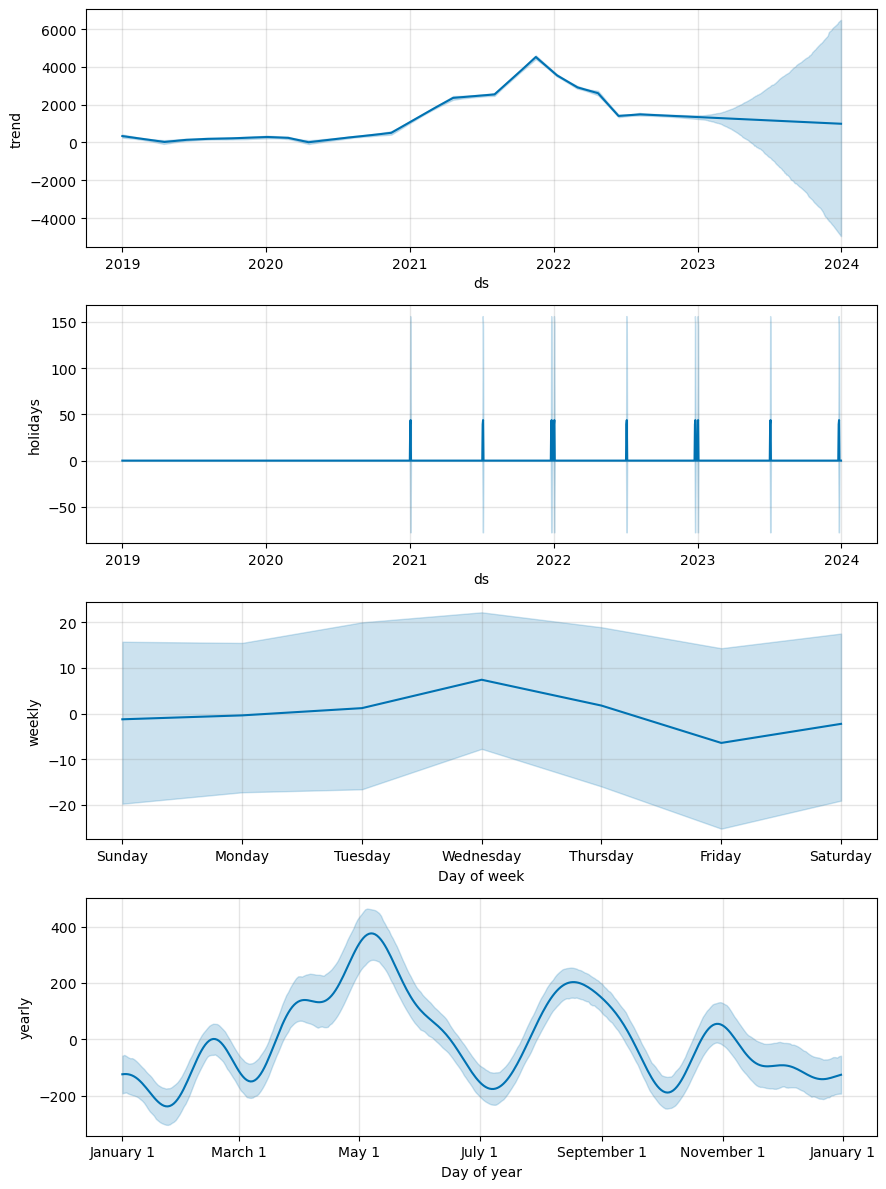

In [37]:
# ETH Prophet model 3
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Load the ETH-USD data
df = pd.read_csv('C:\\Users\\emily\\Desktop\\ETH-USD.csv')

# Prepare the data for Prophet
df['Date'] = pd.to_datetime(df['Date'])
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

# Create a DataFrame with holidays manually (for example, adding some US holidays)
holidays = pd.DataFrame({
    'holiday': 'US_Holidays',
    'ds': pd.to_datetime(['2021-01-01', '2021-07-04', '2021-12-25',  
                          '2022-01-01', '2022-07-04', '2022-12-25',
                          '2023-01-01', '2023-07-04', '2023-12-25',
                          '2024-01-01', '2024-07-04', '2024-12-25']),
    'lower_window': 0,
    'upper_window': 1,
})

# Define and fit the Prophet model with optimizations
model = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=holidays,
    seasonality_prior_scale=15.0,  # Increase seasonality prior scale
    holidays_prior_scale=15.0,      # Increase holidays prior scale
    changepoint_prior_scale=0.2,     # Increase sensitivity to changepoints
    changepoint_range=0.9,            # 90% of the history is used to detect changepoints
    mcmc_samples=100,                 # Increase samples for better estimates
)

# Fit the model
model.fit(train)

# Make predictions
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

# Merge the forecast with the test set
predictions = forecast[['ds', 'yhat']].set_index('ds')
predictions = predictions.loc[test['ds']]

# Calculate performance metrics
mse = mean_squared_error(test['y'], predictions['yhat'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['y'], predictions['yhat'])
r2 = r2_score(test['y'], predictions['yhat'])

# Calculate AIC (Akaike Information Criterion)
n = len(test)
k = len(model.params)  # Number of parameters in the model
aic = n * np.log(mse) + 2 * k

# Print performance metrics
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")
print(f"AIC: {aic}")

# Optional: Plot the forecast and its components
fig = model.plot(forecast)
plt.title('ETH-USD Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Plot the forecast components to analyze seasonality and trend
fig2 = model.plot_components(forecast)
plt.show()


In [40]:
# ETH Prophet model 3 Comparison
import pandas as pd

# Create a dictionary with the performance metrics of the three models
data = {
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'MSE': [
        6239521.576783837, 
        3830735.5862540365, 
        493762.692425655  
    ],
    'RMSE': [
        2497.9034362408484, 
        1957.2265035641726, 
        702.6824975945075  
    ],
    'MAE': [
        2341.7859757537444, 
        1743.5390398751715, 
        625.5706538426791  
    ],
    'R²': [
        -126.89560623554235, 
        -77.52112443283872,  
        -9.120980928929413  
    ],
    'AIC': [
        5740.5875485289835, 
        5562.0356690551425,  
        4824.1905701826945  
    ]
}

# Create a DataFrame
results_df = pd.DataFrame(data)

# Display the DataFrame
print(results_df)


     Model           MSE         RMSE          MAE          R²          AIC
0  Model 1  6.239522e+06  2497.903436  2341.785976 -126.895606  5740.587549
1  Model 2  3.830736e+06  1957.226504  1743.539040  -77.521124  5562.035669
2  Model 3  4.937627e+05   702.682498   625.570654   -9.120981  4824.190570


In [42]:
#BTC GARCH Model 1
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the Bitcoin data
df = pd.read_csv(r'C:\Users\emily\Desktop\BTC-USD.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Ensure the data is sorted by date
df = df.sort_index()

# Use the 'Close' price for the GARCH model
returns = df['Close'].pct_change().dropna()  # Calculate returns

# Rescale the returns
returns *= 10  # Rescale the returns to improve scaling for GARCH

# Fit GARCH model
model = arch_model(returns, vol='Garch', p=1, q=1)  # GARCH(1, 1)
model_fit = model.fit(disp="off")

# Forecast volatility
forecast = model_fit.forecast(horizon=5)  # Predict the next 5 periods
predicted_volatility = forecast.variance.values[-1, :]

# Calculate performance metrics
actual = returns[-5:]  # Actual returns for the last 5 days
predicted = np.sqrt(predicted_volatility)  # Predicted standard deviation (volatility)

# Calculate metrics
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predicted)
r_squared = r2_score(actual, predicted)
aic = model_fit.aic

# Display results
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r_squared}')
print(f'AIC: {aic}')

# Print the forecasted volatility
print("Forecasted Volatility (next 5 periods):", predicted_volatility)


MSE: 0.10403689209710928
RMSE: 0.3225475036287047
MAE: 0.2894764877321915
R²: -4.315450650294534
AIC: 1185.0885607415214
Forecasted Volatility (next 5 periods): [0.0701094  0.07410594 0.0778444  0.08134144 0.08461267]


ADF Statistic: -20.118125527480384
p-value: 0.0
Returns are stationary.
MSE: 0.10193197039173925
RMSE: 0.31926786620601083
MAE: 0.28703399621425696
R²: -4.221359568265818
AIC: 1199.0321000645272
Forecasted Volatility (next 5 periods): [0.0684245  0.06583504 0.07896165 0.07760004 0.08834819]


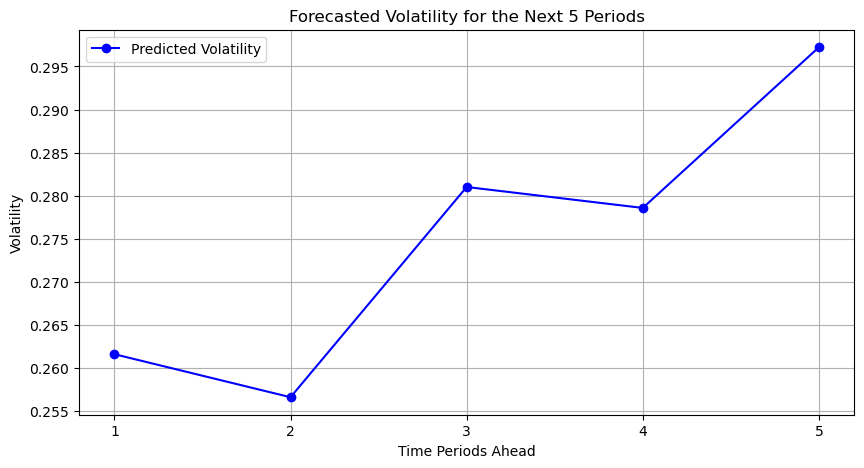

In [6]:
#BTC GARCH Model 2
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Load the Bitcoin data
df = pd.read_csv(r'C:\Users\emily\Desktop\BTC-USD.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Ensure the data is sorted by date
df = df.sort_index()

# Use the 'Close' price for the GARCH model and calculate log-returns
returns = np.log(df['Close']).diff().dropna()

# Check for stationarity using Augmented Dickey-Fuller (ADF) test
adf_test = adfuller(returns)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

if adf_test[1] > 0.05:
    print("Returns are not stationary, consider differencing further or applying transformations.")
else:
    print("Returns are stationary.")

# Optionally rescale the returns (you can experiment with this)
returns *= 10

# Fit GARCH model 
model = arch_model(returns, vol='Garch', p=2, q=2)
model_fit = model.fit(disp="off")

# Forecast volatility for the next 5 periods
forecast = model_fit.forecast(horizon=5)
predicted_volatility = forecast.variance.values[-1, :]  # Predicted variance

# Calculate actual returns for the last 5 days
actual = returns[-5:]

# Calculate predicted standard deviation (volatility)
predicted = np.sqrt(predicted_volatility)

# Calculate performance metrics
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predicted)
r_squared = r2_score(actual, predicted)
aic = model_fit.aic

# Display results
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r_squared}')
print(f'AIC: {aic}')

# Print forecasted volatility
print("Forecasted Volatility (next 5 periods):", predicted_volatility)

# Plot forecasted volatility
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), predicted, marker='o', linestyle='-', color='b', label='Predicted Volatility')
plt.title('Forecasted Volatility for the Next 5 Periods')
plt.xlabel('Time Periods Ahead')
plt.ylabel('Volatility')
plt.xticks(range(1, 6))
plt.legend()
plt.grid()
plt.show()



ADF Statistic: -20.118125527480384
p-value: 0.0
Returns are stationary.
Best GARCH Model: GARCH(2, 2) with AIC: 1199.0321000645272
MSE: 0.13085967981900173
RMSE: 0.361745324529567
MAE: 0.3312110715248203
R²: -5.5433525865024915
AIC: 1199.0321000645272
Log Likelihood: -593.5160500322636
Forecasted Volatility (next 10 periods): [0.0684245  0.06583504 0.07896165 0.07760004 0.08834819 0.08785914
 0.09669671 0.09681472 0.10411203 0.10463995]


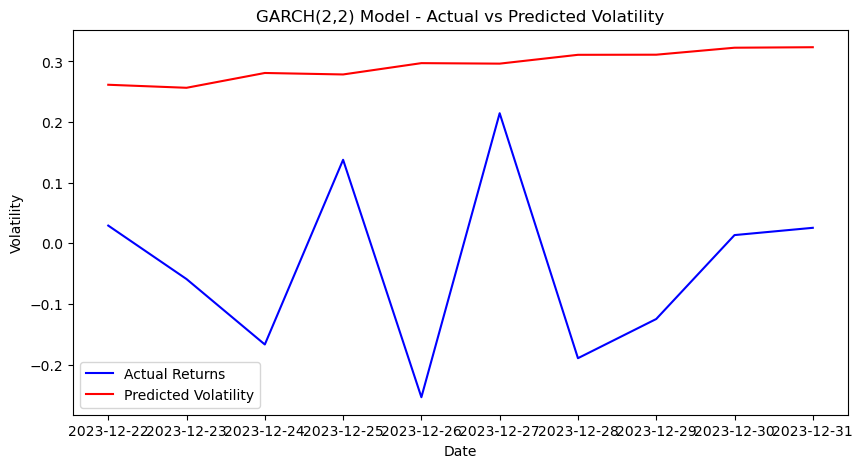

In [4]:
#BTC GARCH Model 3
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller

# Load Bitcoin data
df = pd.read_csv(r'C:\Users\emily\Desktop\BTC-USD.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Ensure the data is sorted by date
df = df.sort_index()

# Calculate log-returns
returns = np.log(df['Close']).diff().dropna()

# Perform ADF test to check for stationarity
adf_test = adfuller(returns)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

if adf_test[1] > 0.05:
    print("Returns are not stationary, consider differencing further or applying transformations.")
else:
    print("Returns are stationary.")

# Optionally rescale returns (to handle large numbers)
returns *= 10

# Try different GARCH models (GARCH(1,1) and GARCH(2,2))
best_aic = np.inf
best_model = None
best_model_fit = None
best_params = None

# Iterate through different model parameters (p, q)
for p in range(1, 3):  # p takes values 1 and 2
    for q in range(1, 3):  # q takes values 1 and 2
        try:
            model = arch_model(returns, vol='Garch', p=p, q=q)
            model_fit = model.fit(disp="off")
            
            # Check AIC and save the best model
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_model = model
                best_model_fit = model_fit
                best_params = (p, q)
                
        except Exception as e:
            print(f"Model GARCH({p},{q}) failed to fit: {e}")

# Output best model information
print(f'Best GARCH Model: GARCH({best_params[0]}, {best_params[1]}) with AIC: {best_aic}')

# Forecast using the best model (forecasting 10 periods ahead)
forecast_horizon = 10
forecast = best_model_fit.forecast(horizon=forecast_horizon)
predicted_volatility = forecast.variance.values[-1, :]  # Predicted variance

# Get actual returns for the last 10 days
actual = returns[-forecast_horizon:]

# Calculate predicted standard deviation (volatility)
predicted = np.sqrt(predicted_volatility)

# Calculate performance metrics
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predicted)
r_squared = r2_score(actual, predicted)
aic = best_model_fit.aic
log_likelihood = best_model_fit.loglikelihood

# Display results
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r_squared}')
print(f'AIC: {aic}')
print(f'Log Likelihood: {log_likelihood}')

# Output predicted volatility
print("Forecasted Volatility (next 10 periods):", predicted_volatility)

# Visualize predicted vs actual volatility (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(actual.index, actual, label='Actual Returns', color='blue')
plt.plot(actual.index, predicted, label='Predicted Volatility', color='red')
plt.title(f'GARCH({best_params[0]},{best_params[1]}) Model - Actual vs Predicted Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


In [5]:
# BTC Volatility Prediction Prophet Models Comparison
import pandas as pd

# Performance metrics for each model
model_results = {
    "Model": ["GARCH(1, 1)", "GARCH(1, 2)", "GARCH(2, 2)"],
    "MSE": [0.10403689209710928, 0.10193197039173925, 0.13085967981900173],
    "RMSE": [0.3225475036287047, 0.31926786620601083, 0.361745324529567],
    "MAE": [0.2894764877321915, 0.28703399621425696, 0.3312110715248203],
    "R²": [-4.315450650294534, -4.221359568265818, -5.5433525865024915],
    "AIC": [1185.0885607415214, 1199.0321000645272, 1199.0321000645272],
    "Forecasted Volatility (5 periods)": [[0.0701094, 0.07410594, 0.0778444, 0.08134144, 0.08461267],
                                          [0.0684245, 0.06583504, 0.07896165, 0.07760004, 0.08834819],
                                          [0.0684245, 0.06583504, 0.07896165, 0.07760004, 0.08834819]]
}

# Create a DataFrame from the model results
results_df = pd.DataFrame(model_results)

# Display the results in a table format
print("GARCH Model Performance Comparison:")
print(results_df.to_string(index=False))


GARCH Model Performance Comparison:
      Model      MSE     RMSE      MAE        R²         AIC                           Forecasted Volatility (5 periods)
GARCH(1, 1) 0.104037 0.322548 0.289476 -4.315451 1185.088561  [0.0701094, 0.07410594, 0.0778444, 0.08134144, 0.08461267]
GARCH(1, 2) 0.101932 0.319268 0.287034 -4.221360 1199.032100 [0.0684245, 0.06583504, 0.07896165, 0.07760004, 0.08834819]
GARCH(2, 2) 0.130860 0.361745 0.331211 -5.543353 1199.032100 [0.0684245, 0.06583504, 0.07896165, 0.07760004, 0.08834819]


ADF Statistic: -12.887138828807796
p-value: 4.528929477082999e-24
Returns are stationary.
MSE: 0.00158058108978924
RMSE: 0.039756522606853334
MAE: 0.03925395605823435
R²: -0.7169086434162018
AIC: -6390.005440546713
Forecasted Volatility (next 5 periods): [0.00086562 0.00087459 0.00089429 0.00090833 0.00092487]


C:\Users\emily\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002058. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


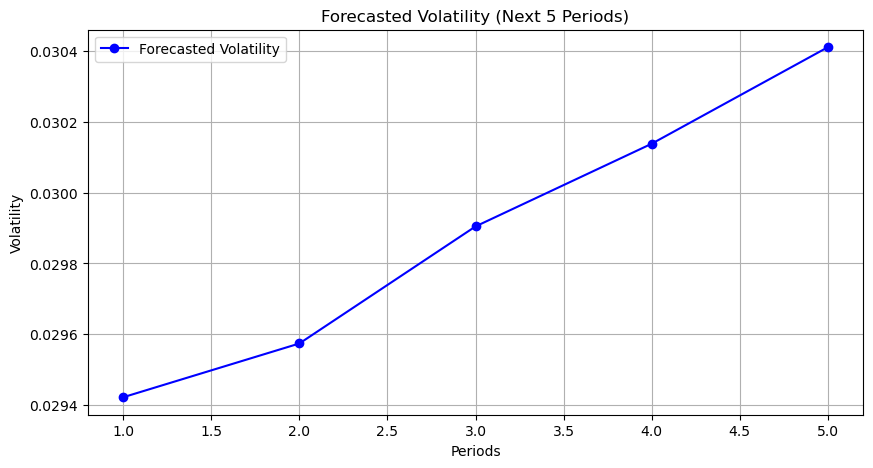

In [20]:
# ETH GARCH Model 1
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Load the Ethereum data
df = pd.read_csv(r'C:\Users\emily\Desktop\ETH-USD.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Ensure the data is sorted by date
df = df.sort_index()

# Use the 'Close' price for the GARCH model and calculate log-returns
returns = np.log(df['Close']).diff().dropna()

# Check for stationarity using Augmented Dickey-Fuller (ADF) test
adf_test = adfuller(returns)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

if adf_test[1] > 0.05:
    print("Returns are not stationary, consider differencing further or applying transformations.")
else:
    print("Returns are stationary.")

# Fit GARCH model (using GARCH(2, 2) as an example)
model = arch_model(returns, vol='Garch', p=2, q=2)
model_fit = model.fit(disp="off")

# Forecast volatility for the next 5 periods
forecast = model_fit.forecast(horizon=5)
predicted_volatility = forecast.variance.values[-1, :]  # Predicted variance

# Calculate actual returns for the last 5 days
actual = returns[-5:]

# Calculate predicted standard deviation (volatility)
predicted = np.sqrt(predicted_volatility)

# Calculate performance metrics
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predicted)
r_squared = r2_score(actual, predicted)
aic = model_fit.aic

# Display results
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r_squared}')
print(f'AIC: {aic}')

# Print forecasted volatility
print("Forecasted Volatility (next 5 periods):", predicted_volatility)

# Visualize the forecasted volatility
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 6), predicted, marker='o', linestyle='-', color='blue', label='Forecasted Volatility')
plt.title('Forecasted Volatility (Next 5 Periods)')
plt.xlabel('Periods')
plt.ylabel('Volatility')
plt.grid(True)
plt.legend()
plt.show()

ADF Statistic: -12.887138828807796
p-value: 4.528929477082999e-24
Returns are stationary.
MSE: 0.001843
RMSE: 0.042932
MAE: 0.042244
R²: -1.002102
AIC: -6380.409962
Forecasted Volatility (next 5 periods): [0.00106259 0.00111693 0.00114755 0.00122903 0.00128174]


C:\Users\emily\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002058. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


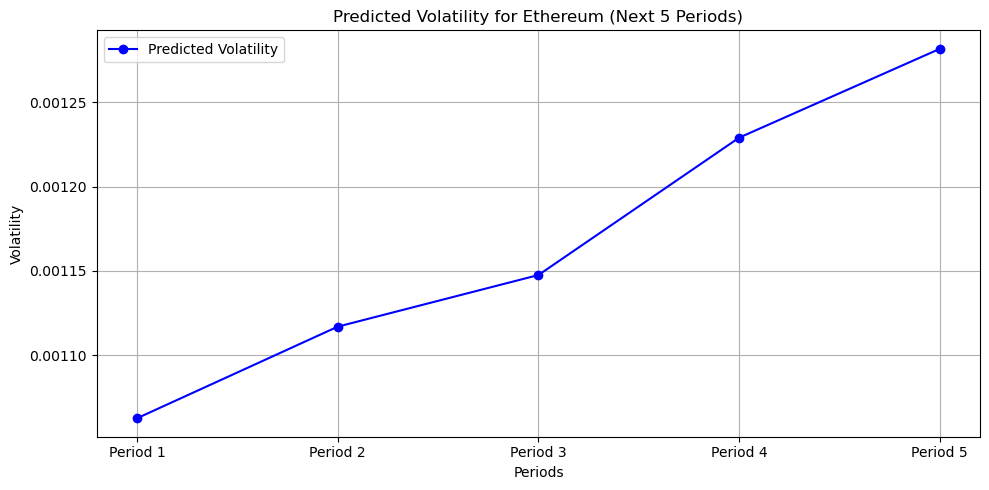

In [15]:
# ETH GARCH Model 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller

# Load the Ethereum data
df = pd.read_csv(r'C:\Users\emily\Desktop\ETH-USD.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Ensure the data is sorted by date
df = df.sort_index()

# Calculate log-returns
returns = np.log(df['Close']).diff().dropna()

# Check for stationarity using Augmented Dickey-Fuller (ADF) test
adf_statistic, p_value, _, _, _, _ = adfuller(returns)
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

if p_value > 0.05:
    print("Returns are not stationary, consider differencing further or applying transformations.")
else:
    print("Returns are stationary.")

# Fit GARCH model (using GARCH(2, 2) as an example)
model = arch_model(returns, vol='Garch', p=3, q=3)
model_fit = model.fit(disp="off")

# Forecast volatility for the next 5 periods
forecast = model_fit.forecast(horizon=5)
predicted_volatility = forecast.variance.values[-1, :]

# Calculate actual returns for the last 5 days
actual = returns[-5:]

# Calculate predicted standard deviation (volatility)
predicted = np.sqrt(predicted_volatility)

# Calculate performance metrics
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predicted)
r_squared = r2_score(actual, predicted)
aic = model_fit.aic

# Display results
print(f'MSE: {mse:.6f}')
print(f'RMSE: {rmse:.6f}')
print(f'MAE: {mae:.6f}')
print(f'R²: {r_squared:.6f}')
print(f'AIC: {aic:.6f}')

# Print forecasted volatility
print("Forecasted Volatility (next 5 periods):", predicted_volatility)

# Plot the predicted volatility
plt.figure(figsize=(10, 5))
plt.plot(predicted_volatility, marker='o', linestyle='-', color='blue', label='Predicted Volatility')
plt.title('Predicted Volatility for Ethereum (Next 5 Periods)')
plt.xlabel('Periods')
plt.ylabel('Volatility')
plt.xticks(ticks=np.arange(len(predicted_volatility)), labels=[f'Period {i+1}' for i in range(len(predicted_volatility))])
plt.legend()
plt.grid()
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


ADF Statistic: -12.887138828807796
p-value: 4.528929477082999e-24
Returns are stationary.
MSE: 0.0015823030367084399
RMSE: 0.039778172867898795
MAE: 0.03930186554585059
R²: -0.7187791109095669
AIC: -6389.0113656572175
BIC: -6366.974024593152
Forecasted Volatility (next 5 periods): [0.00083701 0.00086143 0.00088537 0.00090882 0.00093181]


C:\Users\emily\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002058. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


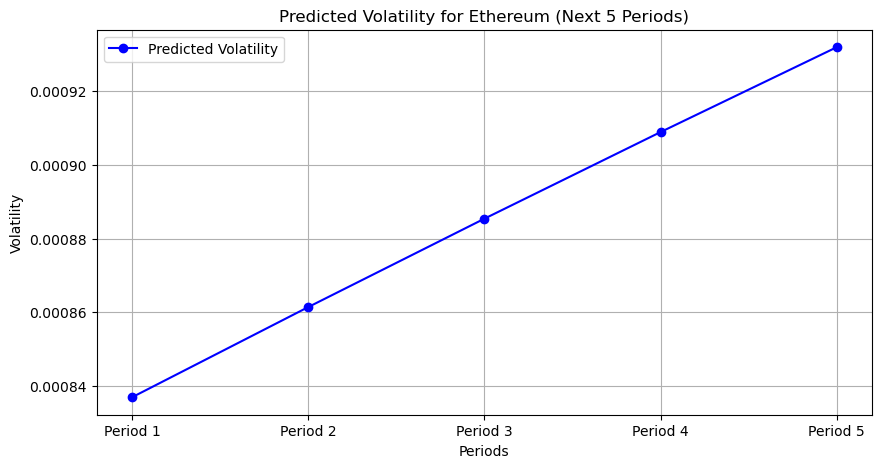

In [10]:
# ETH GARCH Model 3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller

# Load the Ethereum data
df = pd.read_csv(r'C:\Users\emily\Desktop\ETH-USD.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Ensure the data is sorted by date
df = df.sort_index()

# Use the 'Close' price for the GARCH model and calculate log-returns
returns = np.log(df['Close']).diff().dropna()

# Check for stationarity using Augmented Dickey-Fuller (ADF) test
adf_test = adfuller(returns)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

if adf_test[1] > 0.05:
    print("Returns are not stationary, consider differencing further or applying transformations.")
else:
    print("Returns are stationary.")

# Fit GARCH model (using GARCH(1, 1) as an example for testing)
model = arch_model(returns, vol='Garch', p=1, q=1)  # Change p and q values for optimization
model_fit = model.fit(disp="off")

# Forecast volatility for the next 5 periods
forecast = model_fit.forecast(horizon=5)
predicted_volatility = forecast.variance.values[-1, :]  # Predicted variance

# Calculate actual returns for the last 5 days
actual = returns[-5:]

# Calculate predicted standard deviation (volatility)
predicted = np.sqrt(predicted_volatility)

# Calculate performance metrics
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predicted)
r_squared = r2_score(actual, predicted)
aic = model_fit.aic
bic = model_fit.bic  # Add BIC for evaluation

# Display results
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r_squared}')
print(f'AIC: {aic}')
print(f'BIC: {bic}')  # Print BIC

# Print forecasted volatility
print("Forecasted Volatility (next 5 periods):", predicted_volatility)

# Plot the predicted volatility
plt.figure(figsize=(10, 5))
plt.plot(predicted_volatility, marker='o', linestyle='-', color='blue', label='Predicted Volatility')
plt.title('Predicted Volatility for Ethereum (Next 5 Periods)')
plt.xlabel('Periods')
plt.ylabel('Volatility')
plt.xticks(ticks=np.arange(len(predicted_volatility)), labels=[f'Period {i+1}' for i in range(len(predicted_volatility))])
plt.legend()
plt.grid()
plt.show()



In [17]:
# ETH GARCH Model Comparison 
import pandas as pd

# Define the performance metrics for the three models with updated Model 2 values
data = {
    "Model": ["Model 1", "Model 2", "Model 3"],
    "ADF Statistic": [-12.887138828807796, -12.887138828807796, -12.887138828807796],
    "p-value": [4.528929477082999e-24, 4.528929477082999e-24, 4.528929477082999e-24],
    "MSE": [0.00158058108978924, 0.001843, 0.0015823030367084399],
    "RMSE": [0.039756522606853334, 0.042932, 0.039778172867898795],
    "MAE": [0.03925395605823435, 0.042244, 0.03930186554585059],
    "R²": [-0.7169086434162018, -1.002102, -0.7187791109095669],
    "AIC": [-6390.005440546713, -6380.409962, -6389.0113656572175],
    "BIC": [None, None, -6366.974024593152]  # Model 1 and Model 2 do not have BIC
}

# Create a DataFrame
performance_df = pd.DataFrame(data)

# Transpose the DataFrame to show metrics in a single row
performance_df = performance_df.set_index("Model").T

# Display the performance metrics table
print(performance_df)


Model               Model 1       Model 2       Model 3
ADF Statistic -1.288714e+01 -1.288714e+01 -1.288714e+01
p-value        4.528929e-24  4.528929e-24  4.528929e-24
MSE            1.580581e-03  1.843000e-03  1.582303e-03
RMSE           3.975652e-02  4.293200e-02  3.977817e-02
MAE            3.925396e-02  4.224400e-02  3.930187e-02
R²            -7.169086e-01 -1.002102e+00 -7.187791e-01
AIC           -6.390005e+03 -6.380410e+03 -6.389011e+03
BIC                     NaN           NaN -6.366974e+03


In [29]:
# BTC Linear Regression Model 1
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv(r'C:\Users\emily\Desktop\BTC-USD.csv')

# Data preprocessing
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Select features and target variable
X = data[['Open']]
y = data['Close']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions using the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate Adjusted R²
n = X_test.shape[0]  # Number of observations in the test set
p = X.shape[1]       # Number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Output performance metrics
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.2f}')
print(f'Adjusted R²: {adjusted_r2:.2f}')


MSE: 1137364.58
RMSE: 1066.47
MAE: 594.41
R²: 1.00
Adjusted R²: 1.00


In [30]:
# BTC Linear Regression Model 2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv(r'C:\Users\emily\Desktop\BTC-USD.csv')

# Data preprocessing
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Feature engineering
data['High_Low'] = data['High'] - data['Low']  # Feature: High - Low
data['Close_Open'] = data['Close'] - data['Open']  # Feature: Close - Open
data['MA_5'] = data['Close'].rolling(window=5).mean()  # 5-day moving average
data['MA_10'] = data['Close'].rolling(window=10).mean()  # 10-day moving average
data.dropna(inplace=True)  # Drop rows with NaN values after rolling

# Select features and target variable
X = data[['Open', 'High', 'Low', 'Volume', 'High_Low', 'Close_Open', 'MA_5', 'MA_10']]
y = data['Close']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions using the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate Adjusted R²
n = X_test.shape[0]  # Number of observations in the test set
p = X.shape[1]       # Number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Cross-validation for robustness
cv_scores = cross_val_score(model, X_scaled, y, cv=5)
cv_mean = np.mean(cv_scores)

# Output performance metrics
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.2f}')
print(f'Adjusted R²: {adjusted_r2:.2f}')
print(f'Cross-Validation Mean R²: {cv_mean:.2f}')


MSE: 0.00
RMSE: 0.00
MAE: 0.00
R²: 1.00
Adjusted R²: 1.00
Cross-Validation Mean R²: 1.00


MSE: 23958.49
RMSE: 154.79
MAE: 110.70
R²: 1.00
Explained Variance Score: 1.00
Cross-Validation Mean R²: 0.77


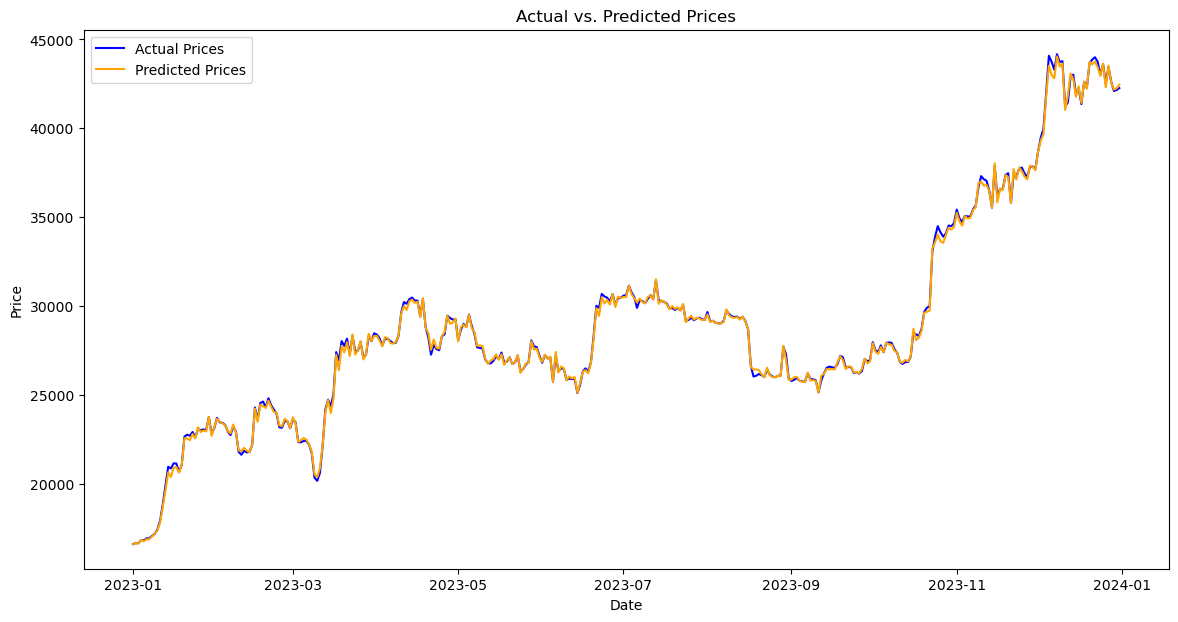

In [32]:
# BTC Linear Regression Model 3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv('C:/Users/emily/Desktop/BTC-USD.csv')

# Convert 'Date' column to datetime format and set it as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Feature engineering
data['High_Low'] = data['High'] - data['Low']
data['Close_Open'] = data['Close'] - data['Open']
data['MA_5'] = data['Close'].rolling(window=5).mean()  # 5-day moving average
data['MA_10'] = data['Close'].rolling(window=10).mean()  # 10-day moving average

# Drop rows with NaN values (created by moving averages)
data.dropna(inplace=True)

# Split the dataset into train and test sets using a time-based split
split_date = '2023-01-01'  # Adjust the date as needed
train_data = data[data.index < split_date]
test_data = data[data.index >= split_date]

# Features and target variable
X_train = train_data[['Open', 'High', 'Low', 'Volume', 'High_Low', 'Close_Open', 'MA_5', 'MA_10']]
y_train = train_data['Close']
X_test = test_data[['Open', 'High', 'Low', 'Volume', 'High_Low', 'Close_Open', 'MA_5', 'MA_10']]
y_test = test_data['Close']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and fit the Ridge regression model with regularization
ridge_model = Ridge(alpha=10.0)  # Experiment with alpha values for regularization
ridge_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = ridge_model.predict(X_test_scaled)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

# Output performance metrics
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.2f}')
print(f'Explained Variance Score: {explained_variance:.2f}')

# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)
cross_val_scores = []

for train_index, test_index in tscv.split(X_train_scaled):
    X_train_cv, X_test_cv = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_cv, y_test_cv = y_train.values[train_index], y_train.values[test_index]
    
    ridge_model.fit(X_train_cv, y_train_cv)
    y_pred_cv = ridge_model.predict(X_test_cv)
    
    cross_val_scores.append(r2_score(y_test_cv, y_pred_cv))

# Output mean cross-validation score
print(f'Cross-Validation Mean R²: {np.mean(cross_val_scores):.2f}')

# Visualize actual vs. predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, color='blue', label='Actual Prices')
plt.plot(y_test.index, y_pred, color='orange', label='Predicted Prices')
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [28]:
# BTC Linear Regression Comparison 
import pandas as pd

# Define the metrics for each model
data = {
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²', 'Adjusted R²', 'Explained Variance Score', 'Cross-Validation Mean R²'],
    'Model 1': [1137364.58, 1066.47, 594.41, 1.00, 1.00, None, None],
    'Model 2': [0.00, 0.00, 0.00, 1.00, 1.00, None, 1.00],
    'Model 3': [23958.49, 154.79, 110.70, 1.00, None, 1.00, 0.77]
}

# Create a DataFrame
metrics_df = pd.DataFrame(data)

# Display the DataFrame
print(metrics_df)



                     Metric     Model 1  Model 2   Model 3
0                       MSE  1137364.58      0.0  23958.49
1                      RMSE     1066.47      0.0    154.79
2                       MAE      594.41      0.0    110.70
3                        R²        1.00      1.0      1.00
4               Adjusted R²        1.00      1.0       NaN
5  Explained Variance Score         NaN      NaN      1.00
6  Cross-Validation Mean R²         NaN      1.0      0.77


In [33]:
# ETH Linear Regression Model 1
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    explained_variance_score
)

# Step 1: Load the Data
file_path = 'C:\\Users\\emily\\Desktop\\ETH-USD.csv'
data = pd.read_csv(file_path)

# Step 2: Preprocess the Data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Select relevant features and target variable
features = data[['Open', 'High', 'Low', 'Volume']]
target = data['Close']

# Step 3: Split the Data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 4: Build the Model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Make Predictions
y_pred = model.predict(X_test)

# Step 6: Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Calculate RMSE
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print the performance metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'R-squared (R²): {r2}')
print(f'Explained Variance Score: {explained_variance}')


Mean Absolute Error (MAE): 17.54388990554157
Mean Squared Error (MSE): 1415.6630893426343
Root Mean Squared Error (RMSE): 37.62529852828592
Mean Absolute Percentage Error (MAPE): 1.17%
R-squared (R²): 0.9988856336746471
Explained Variance Score: 0.9988857607425596


--- Linear Regression Model ---
Mean Absolute Error (MAE): 8.674699682793076
Mean Squared Error (MSE): 141.26669645893145
Root Mean Squared Error (RMSE): 11.88556672855491
R-squared (R²): 0.9970007378633574
Explained Variance Score: 0.9970077947296038


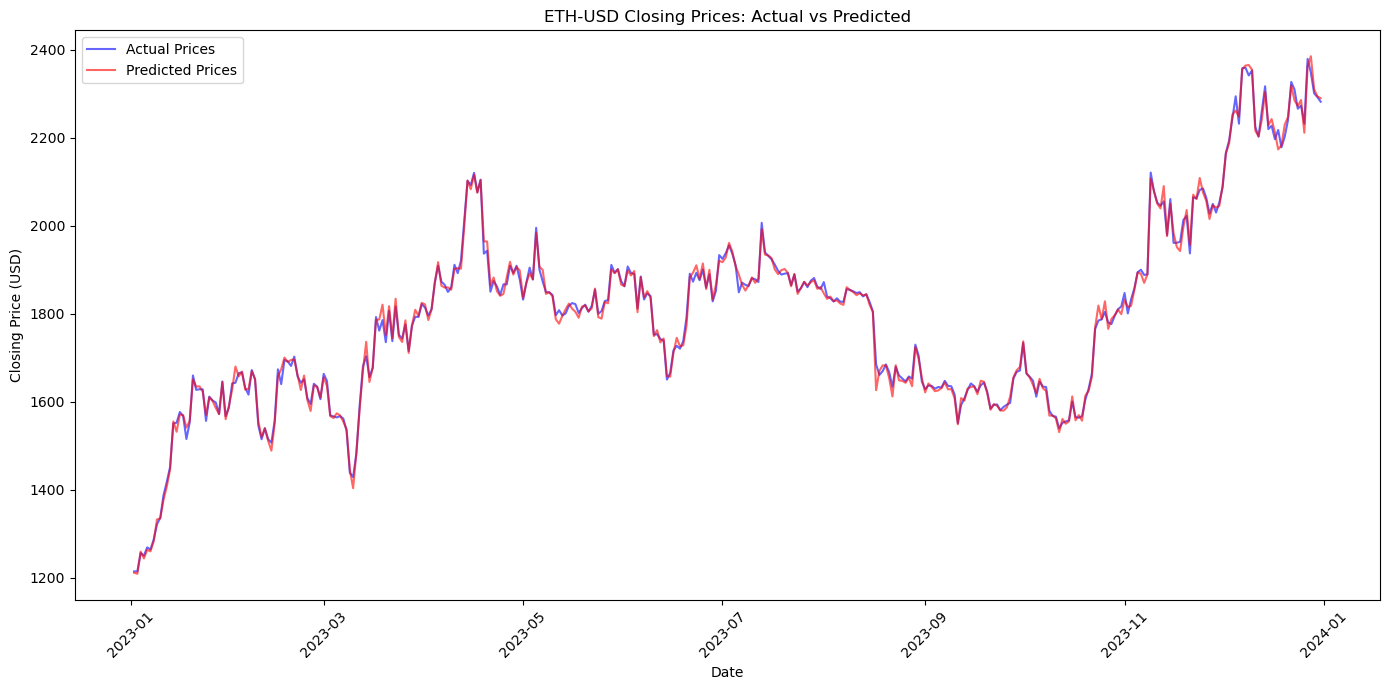

In [2]:
# ETH Linear Regression Model 2
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    explained_variance_score
)
import matplotlib.pyplot as plt

# Step 1: Load the Data
file_path = 'C:\\Users\\emily\\Desktop\\ETH-USD.csv'
data = pd.read_csv(file_path)

# Step 2: Preprocess the Data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Step 3: Feature Engineering - Create lagged features and moving averages
data['Lagged_Close'] = data['Close'].shift(1)  # Previous day's closing price
data['MA_5'] = data['Close'].rolling(window=5).mean()  # 5-day moving average
data['MA_10'] = data['Close'].rolling(window=10).mean()  # 10-day moving average
data['Return_1D'] = data['Close'].pct_change()  # 1-day percentage return
data['Volatility_5'] = data['Close'].rolling(window=5).std()  # 5-day volatility
data.dropna(inplace=True)  # Drop NA values after feature creation

# Select features and target variable
features = data[['Open', 'High', 'Low', 'Volume', 'Lagged_Close', 'MA_5', 'MA_10', 'Return_1D', 'Volatility_5']]
target = data['Close']

# Step 4: Split the Data - Ensuring no randomization and maintaining time order
train_size = int(len(data) * 0.8)
X_train, X_test = features[:train_size], features[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

# Step 5: Build and Evaluate the Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 6: Make Predictions
y_pred = model.predict(X_test)

# Step 7: Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

# Print the performance metrics
print(f'--- Linear Regression Model ---')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')
print(f'Explained Variance Score: {explained_variance}')

# Step 8: Visualization of predictions vs actual prices
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue', alpha=0.6)
plt.plot(y_test.index, y_pred, label='Predicted Prices', color='red', alpha=0.6)
plt.title('ETH-USD Closing Prices: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [36]:
# ETH Linear Regression Model 3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    explained_variance_score
)

# Step 1: Load the Data
file_path = 'C:\\Users\\emily\\Desktop\\ETH-USD.csv'
data = pd.read_csv(file_path)

# Step 2: Preprocess the Data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Step 3: Feature Engineering
# Create multiple lagged features
for lag in range(1, 6):  # Adding lagged features for the last 5 days
    data[f'Lagged_Close_{lag}'] = data['Close'].shift(lag)

# Create moving averages
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_10'] = data['Close'].rolling(window=10).mean()

# Create time features (e.g., day of the week)
data['Day_of_Week'] = data.index.dayofweek

data.dropna(inplace=True)  # Drop NA values after feature creation

# Select features and target variable
features = data[['Open', 'High', 'Low', 'Volume', 'Day_of_Week'] + [f'Lagged_Close_{lag}' for lag in range(1, 6)]]
target = data['Close']

# Step 4: Split the Data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 5: Polynomial Features (Optional)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Step 6: Build and Evaluate the Linear Regression Model
model = LinearRegression()
model.fit(X_train_poly, y_train)  # Using polynomial features

# Perform cross-validation for better performance assessment
cv_scores = cross_val_score(model, X_train_poly, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_mse = -cv_scores.mean()

# Step 7: Make Predictions
y_pred = model.predict(X_test_poly)

# Step 8: Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

# Print the performance metrics
print(f'--- Linear Regression Model (Optimized) ---')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Cross-Validated MSE: {mean_cv_mse}')
print(f'R-squared (R²): {r2}')
print(f'Explained Variance Score: {explained_variance}')


--- Linear Regression Model (Optimized) ---
Mean Absolute Error (MAE): 313.40283193176754
Mean Squared Error (MSE): 126452.46934374828
Root Mean Squared Error (RMSE): 355.6015598162475
Mean Cross-Validated MSE: 148912.7488197533
R-squared (R²): 0.9026162725297795
Explained Variance Score: 0.9026166819358554


In [3]:
# ETH Linear Regression Model Comparison
import pandas as pd

# Define the performance metrics for each model with updated Model 2 data
data = {
    'Metric': [
        'Mean Absolute Error (MAE)',
        'Mean Squared Error (MSE)',
        'Root Mean Squared Error (RMSE)',
        'Mean Cross-Validated MSE',
        'R-squared (R²)',
        'Explained Variance Score'
    ],
    'Model 1': [
        17.54388990554157,
        1415.6630893426343,
        37.62529852828592,
        None,  # No cross-validated MSE available for Model 1
        0.9988856336746471,
        0.9988857607425596
    ],
    'Model 2': [
        8.674699682793076,  # Updated MAE
        141.26669645893145,  # Updated MSE
        11.88556672855491,  # Updated RMSE
        None,  # No cross-validated MSE provided for Model 2
        0.9970007378633574,  # Updated R-squared
        0.9970077947296038   # Updated Explained Variance Score
    ],
    'Model 3': [
        313.40283193176754,
        126452.46934374828,
        355.6015598162475,
        148912.7488197533,
        0.9026162725297795,
        0.9026166819358554
    ]
}

# Create a DataFrame
results_df = pd.DataFrame(data)

# Set the 'Metric' column as the index
results_df.set_index('Metric', inplace=True)

# Display the comparison table
print("--- Model Performance Comparison ---")
print(results_df)


--- Model Performance Comparison ---
                                    Model 1     Model 2        Model 3
Metric                                                                
Mean Absolute Error (MAE)         17.543890    8.674700     313.402832
Mean Squared Error (MSE)        1415.663089  141.266696  126452.469344
Root Mean Squared Error (RMSE)    37.625299   11.885567     355.601560
Mean Cross-Validated MSE                NaN         NaN  148912.748820
R-squared (R²)                     0.998886    0.997001       0.902616
Explained Variance Score           0.998886    0.997008       0.902617


In [7]:
# BTC Decision Trees Model 1
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt

# Read the data
data = pd.read_csv('C:/Users/emily/Desktop/BTC-USD.csv')

# Data preprocessing
# Convert the date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Select features and target variable
# Using Open, High, Low, and Volume as features, Close as the target
X = data[['Open', 'High', 'Low', 'Volume']]
y = data['Close']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the random forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)    # Mean Squared Error
rmse = np.sqrt(mse)                          # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)               # R² Score
evs = explained_variance_score(y_test, y_pred)  # Explained Variance Score

# Print performance metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Explained Variance Score: {evs:.2f}")


Mean Absolute Error (MAE): 302.99
Mean Squared Error (MSE): 323371.15
Root Mean Squared Error (RMSE): 568.66
R² Score: 1.00
Explained Variance Score: 1.00


Mean Absolute Error (MAE): 320.77
Mean Squared Error (MSE): 179904.24
Root Mean Squared Error (RMSE): 424.15
R² Score: 0.99
Explained Variance Score: 0.99
Cross-validation MSE Scores: [ 864812.73451897   63609.23916082  902444.65470255 1186686.00738818
 1746137.28590508]
Average Cross-validation MSE: 952737.98


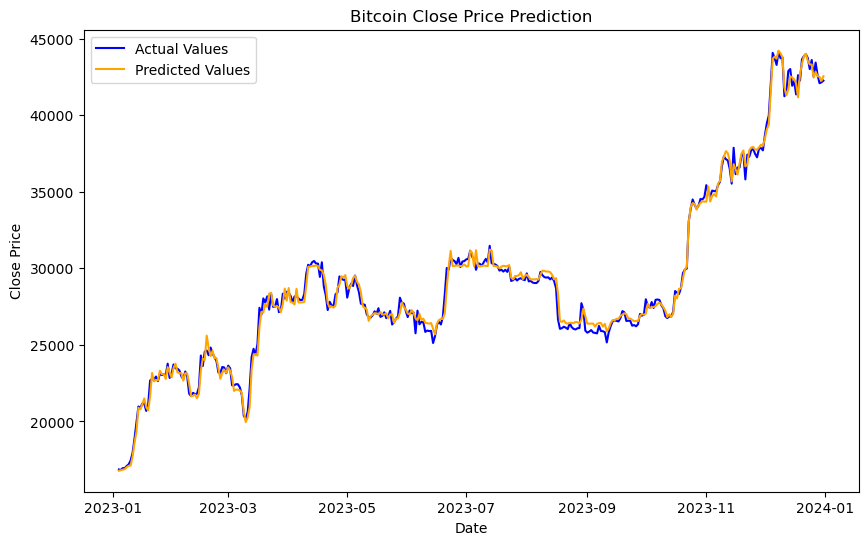

In [5]:
# BTC Decision Trees Model 2
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt

# Read the data
data = pd.read_csv('C:/Users/emily/Desktop/BTC-USD.csv')

# Data preprocessing
# Convert the date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Feature engineering
# Create new features such as moving averages and lagged close price
data['MA7'] = data['Close'].rolling(window=7).mean()
data['MA21'] = data['Close'].rolling(window=21).mean()
data['Close_Lag1'] = data['Close'].shift(1)

# Drop rows with NaN values caused by rolling calculations
data.dropna(inplace=True)

# Select features and target variable
# Using Open, High, Low, Volume, MA7, MA21, Close_Lag1 as features
X = data[['Open', 'High', 'Low', 'Volume', 'MA7', 'MA21', 'Close_Lag1']]
y = data['Close']

# Split the dataset without shuffling (time series data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Cross-validation scores
cv_scores = cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_squared_error'
)

# Train the best model
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)           # Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)            # Mean Squared Error
rmse = np.sqrt(mse)                                 # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)                       # R² Score
evs = explained_variance_score(y_test, y_pred)      # Explained Variance Score

# Print performance metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Explained Variance Score: {evs:.2f}")
print(f"Cross-validation MSE Scores: { -cv_scores }")
print(f"Average Cross-validation MSE: { -cv_scores.mean():.2f}")

# Visualize prediction results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Values', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Values', color='orange')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Bitcoin Close Price Prediction')
plt.legend()
plt.show()


In [10]:
# BTC Decision Trees Model 3
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import numpy as np

# Load the dataset
df = pd.read_csv(r'C:\Users\emily\Desktop\BTC-USD.csv')

# Feature engineering: Extract features (Open, High, Low, Volume) and target (Close)
X = df[['Open', 'High', 'Low', 'Volume']]  # Features
y = df['Close']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter search space
param_dist = {
    'n_estimators': [100, 200, 500],         # Number of trees
    'max_depth': [10, 20, None],             # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],         # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],           # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'] # Number of features to consider when looking for the best split
}

# Initialize the random forest regressor
rf = RandomForestRegressor(random_state=42)

# Set up RandomizedSearchCV with 5-fold cross-validation and 50 iterations
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                                   n_iter=50, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the model with the training data
random_search.fit(X_train, y_train)

# Get the best estimator (model with best hyperparameters)
best_rf = random_search.best_estimator_

# Print the best hyperparameters
print(f"Best hyperparameters: {random_search.best_params_}")

# Predict on the test data
y_pred = best_rf.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)

# Print performance metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Explained Variance Score: {explained_var:.2f}")

# Perform cross-validation for additional evaluation
cv_mse_scores = cross_val_score(best_rf, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
cv_mse_scores = -cv_mse_scores  # Since cross_val_score returns negative MSE
average_cv_mse = np.mean(cv_mse_scores)

# Print cross-validation MSE scores and their average
print(f"Cross-validation MSE Scores: {cv_mse_scores}")
print(f"Average Cross-validation MSE: {average_cv_mse:.2f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\emily\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
90 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
37 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\emily\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\emily\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\emily\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\emily\anaconda3\Lib\site-packages

Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Mean Absolute Error (MAE): 316.60
Mean Squared Error (MSE): 329946.35
Root Mean Squared Error (RMSE): 574.41
R² Score: 1.00
Explained Variance Score: 1.00
Cross-validation MSE Scores: [299394.98902994 320989.90115454 344833.4842725  323676.09239784
 437662.0059226 ]
Average Cross-validation MSE: 345311.29


In [18]:
# BTC Decision Trees Model comparison
import pandas as pd

data = {
    "Metric": [
        "Mean Absolute Error (MAE)",
        "Mean Squared Error (MSE)",
        "Root Mean Squared Error (RMSE)",
        "R² Score",
        "Explained Variance Score",
        "Average Cross-validation MSE"
    ],
    "Model 1": [
        302.99,
        323371.15,
        568.66,
        1.00,
        1.00,
        "N/A"
    ],
    "Model 2": [
        320.77,
        179904.24,
        424.15,
        0.99,
        0.99,
        952737.98
    ],
    "Model 3": [
        316.60,
        329946.35,
        574.41,
        1.00,
        1.00,
        345311.29
    ]
}

# Convert the dictionary into a DataFrame
comparison_df = pd.DataFrame(data)

# Display the formatted DataFrame in a clear table format
print(comparison_df.to_string(index=False))


                        Metric    Model 1   Model 2   Model 3
     Mean Absolute Error (MAE)     302.99    320.77    316.60
      Mean Squared Error (MSE)  323371.15 179904.24 329946.35
Root Mean Squared Error (RMSE)     568.66    424.15    574.41
                      R² Score        1.0      0.99      1.00
      Explained Variance Score        1.0      0.99      1.00
  Average Cross-validation MSE        N/A 952737.98 345311.29


Mean Absolute Error (MAE): 3.1752049617486313
Mean Squared Error (MSE): 52.31305030962838
Root Mean Squared Error (RMSE): 7.232776113611452
R² Score: 0.9999588207801133
Explained Variance Score: 0.9999588910215444


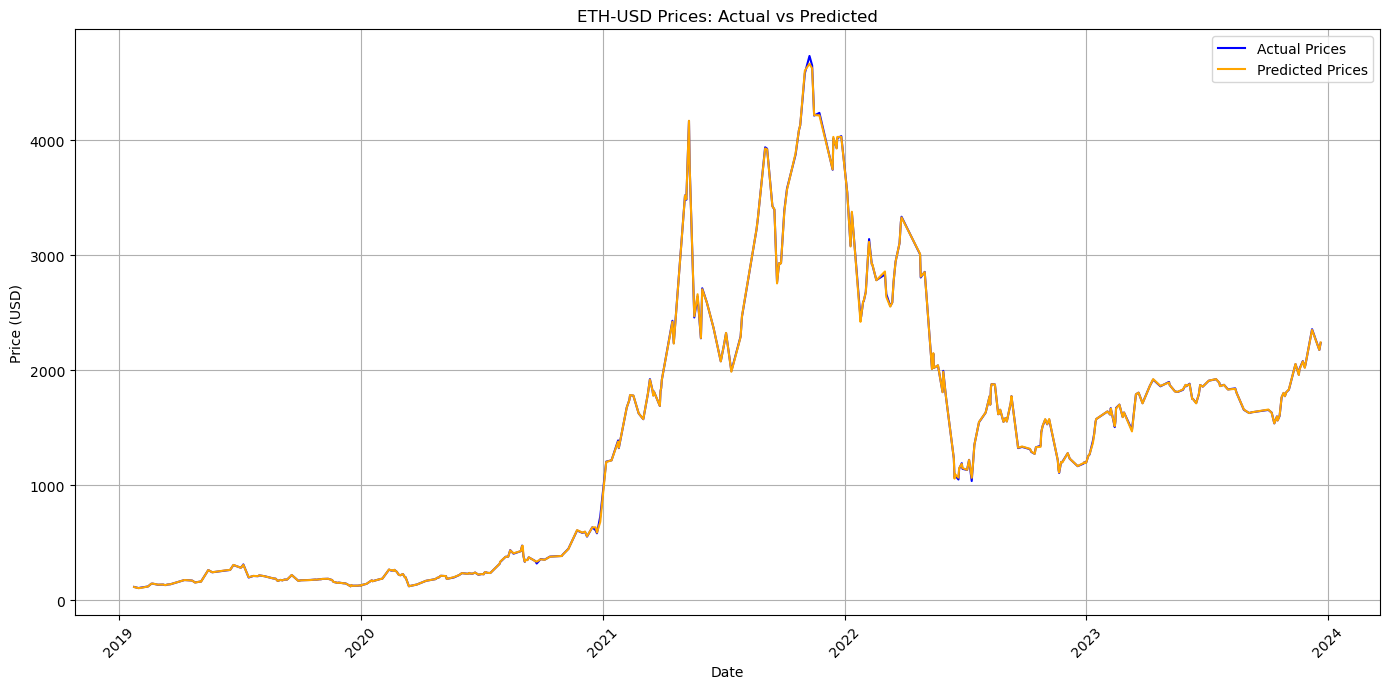

In [29]:
# ETH Decision Trees Model 1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

# Load the dataset
file_path = 'C:\\Users\\emily\\Desktop\\ETH-USD.csv'
data = pd.read_csv(file_path)

# Preprocess the data (Assuming Date, Open, High, Low, Close, Adj Close, Volume columns exist)
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Use 'Close' as the target variable and drop other columns for features
X = data.drop(columns=['Date', 'Close'])
y = data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the Decision Tree Regressor
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

# Display the performance metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)
print("Explained Variance Score:", explained_variance)

# Create a new DataFrame for comparison
results_df = pd.DataFrame({'Date': data['Date'].iloc[X_test.index], 
                           'Actual': y_test, 
                           'Predicted': y_pred})

# Sort by Date to avoid misalignment
results_df.sort_values('Date', inplace=True)

# Visualization
plt.figure(figsize=(14, 7))

# Plot the actual values as a line
plt.plot(results_df['Date'], results_df['Actual'], label='Actual Prices', color='blue')

# Plot the predicted values as a line
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted Prices', color='orange')

# Customize the plot
plt.title('ETH-USD Prices: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()


In [20]:
# ETH Decision Trees Model 2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

# Load the dataset
file_path = 'C:\\Users\\emily\\Desktop\\ETH-USD.csv'
data = pd.read_csv(file_path)

# Preprocess the data
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Use 'Close' as the target variable and drop unnecessary columns
X = data.drop(columns=['Date', 'Close'])
y = data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Decision Tree Regressor
model = DecisionTreeRegressor(random_state=42)

# Set up hyperparameter tuning with GridSearchCV
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

# Display the performance metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)
print("Explained Variance Score:", explained_variance)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)


Mean Absolute Error (MAE): 3.884681025227695
Mean Squared Error (MSE): 124.22977805646364
Root Mean Squared Error (RMSE): 11.145841289757524
R² Score: 0.9999022101499189
Explained Variance Score: 0.99990239270276
Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [21]:
# ETH Decision Trees Model 3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = 'C:\\Users\\emily\\Desktop\\ETH-USD.csv'
data = pd.read_csv(file_path)

# Preprocess the data
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Create new features (e.g., moving averages, previous day prices)
data['MA_5'] = data['Close'].rolling(window=5).mean().shift(1)
data['MA_10'] = data['Close'].rolling(window=10).mean().shift(1)
data['Price_Change'] = data['Close'].pct_change().shift(1)

# Drop rows with NaN values created by rolling mean
data.dropna(inplace=True)

# Use 'Close' as the target variable and drop unnecessary columns
X = data.drop(columns=['Date', 'Close'])
y = data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for better performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Decision Tree Regressor
model = DecisionTreeRegressor(random_state=42)

# Set up hyperparameter tuning with GridSearchCV
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [None, 10, 20, 30]  # Adding max_leaf_nodes to control tree complexity
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test_scaled)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

# Display the performance metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)
print("Explained Variance Score:", explained_variance)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)


Mean Absolute Error (MAE): 3.7098165961538454
Mean Squared Error (MSE): 89.06077078341396
Root Mean Squared Error (RMSE): 9.43720142751091
R² Score: 0.9999304111318966
Explained Variance Score: 0.9999306523846107
Best hyperparameters: {'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [22]:
# ETH Decision Trees Model Comparison
import pandas as pd

# Define the performance metrics for each model
data = {
    "Metric": [
        "Mean Absolute Error (MAE)",
        "Mean Squared Error (MSE)",
        "Root Mean Squared Error (RMSE)",
        "R² Score",
        "Explained Variance Score"
    ],
    "Model 1": [
        3.1752,          # MAE
        52.3130,         # MSE
        7.2328,          # RMSE
        0.9999,          # R² Score
        0.9999           # Explained Variance Score
    ],
    "Model 2": [
        3.8847,          # MAE
        124.2298,        # MSE
        11.1458,         # RMSE
        0.9999,          # R² Score
        0.9999           # Explained Variance Score
    ],
    "Model 3": [
        3.7098,          # MAE
        89.0608,         # MSE
        9.4372,          # RMSE
        0.9999,          # R² Score
        0.9999           # Explained Variance Score
    ]
}

# Create a DataFrame
comparison_df = pd.DataFrame(data)

# Display the comparison DataFrame
print(comparison_df)


                           Metric  Model 1   Model 2  Model 3
0       Mean Absolute Error (MAE)   3.1752    3.8847   3.7098
1        Mean Squared Error (MSE)  52.3130  124.2298  89.0608
2  Root Mean Squared Error (RMSE)   7.2328   11.1458   9.4372
3                        R² Score   0.9999    0.9999   0.9999
4        Explained Variance Score   0.9999    0.9999   0.9999


Mean Squared Error (MSE): 323371.1520498475
Mean Absolute Error (MAE): 302.98934622464384
R-squared (R²): 0.9986996971996474
Mean Absolute Percentage Error (MAPE): 1.17%
Root Mean Squared Error (RMSE): 568.6573239217512


C:\Users\emily\AppData\Local\Temp\ipykernel_13116\1835503436.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  results_weekly = results.resample('W').mean().fillna(method='ffill')


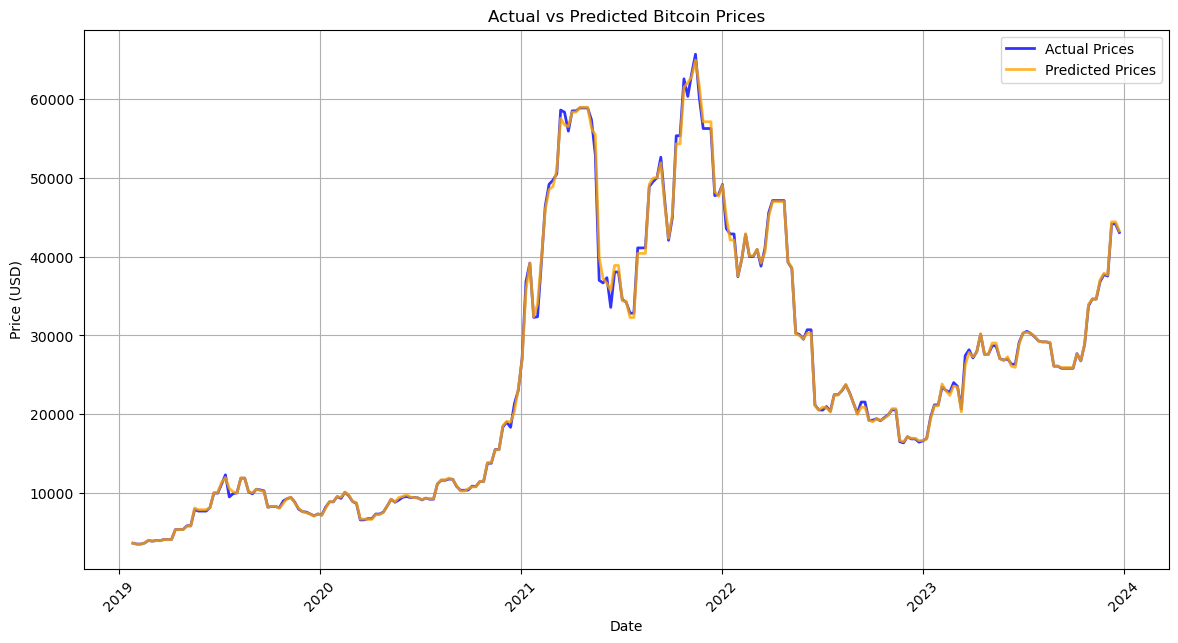

In [12]:
# BTC Random Forest Model 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# 1. Load the data
file_path = r'C:\Users\emily\Desktop\BTC-USD.csv'
data = pd.read_csv(file_path)

# 2. Data preprocessing
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Feature selection
features = data[['Open', 'High', 'Low', 'Volume']]
target = data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# 3. Train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. Make predictions
y_pred = model.predict(X_test)

# 5. Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Output performance metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# 6. Plot predictions vs actual values
plt.figure(figsize=(14, 7))

# Convert to DataFrame for easier handling
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)

# Resample the data to weekly frequency and fill missing values
results_weekly = results.resample('W').mean().fillna(method='ffill')

# Plot actual and predicted prices
plt.plot(results_weekly.index, results_weekly['Actual'], label='Actual Prices', color='blue', alpha=0.8, linewidth=2)
plt.plot(results_weekly.index, results_weekly['Predicted'], label='Predicted Prices', color='orange', alpha=0.8, linewidth=2)

plt.title('Actual vs Predicted Bitcoin Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()







In [2]:
# BTC Random Forest Model 2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Load the data
file_path = r'C:\Users\emily\Desktop\BTC-USD.csv'
data = pd.read_csv(file_path)

# Data preprocessing
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Feature selection
features = data[['Open', 'High', 'Low', 'Volume']]
target = data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=3,  # 3-fold cross-validation
                           verbose=2,
                           n_jobs=-1)  # Use all available cores

grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Output performance metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Best parameters
print("Best parameters found: ", grid_search.best_params_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Mean Squared Error (MSE): 324153.99495080294
Mean Absolute Error (MAE): 305.5491460128521
R-squared (R²): 0.9986965493220153
Mean Absolute Percentage Error (MAPE): 1.19%
Root Mean Squared Error (RMSE): 569.3452335365625
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [4]:
# BTC Random Forest Model 3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Load the data
file_path = r'C:\Users\emily\Desktop\BTC-USD.csv'
data = pd.read_csv(file_path)

# Data preprocessing
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Feature selection
features = data[['Open', 'High', 'Low', 'Volume']]
target = data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the Random Forest model with adjusted hyperparameters
model = RandomForestRegressor(n_estimators=500, max_depth=30, min_samples_split=2, min_samples_leaf=1, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Output performance metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Squared Error (MSE): 323805.2027414
Mean Absolute Error (MAE): 305.9594371053001
R-squared (R²): 0.9986979518450412
Mean Absolute Percentage Error (MAPE): 1.19%
Root Mean Squared Error (RMSE): 569.0388411535719


In [13]:
#Random Forest Model Comparison
import pandas as pd

# Define the performance metrics for each model
data = {
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'Mean Squared Error (MSE)': [323371.1520498475, 324153.99495080294, 323805.2027414],
    'Mean Absolute Error (MAE)': [302.98934622464384, 305.5491460128521, 305.9594371053001],
    'R-squared (R²)': [0.9986996971996474, 0.9986965493220153, 0.9986979518450412],
    'Mean Absolute Percentage Error (MAPE)': [1.17, 1.19, 1.19],
    'Root Mean Squared Error (RMSE)': [568.6573239217512, 569.3452335365625, 569.0388411535719]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame as a table
print(df.to_string(index=False))



  Model  Mean Squared Error (MSE)  Mean Absolute Error (MAE)  R-squared (R²)  Mean Absolute Percentage Error (MAPE)  Root Mean Squared Error (RMSE)
Model 1             323371.152050                 302.989346        0.998700                                   1.17                      568.657324
Model 2             324153.994951                 305.549146        0.998697                                   1.19                      569.345234
Model 3             323805.202741                 305.959437        0.998698                                   1.19                      569.038841


In [14]:
# ETH Random Forest Model 1
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# 1. Load the data
file_path = r'C:\Users\emily\Desktop\ETH-USD.csv'
data = pd.read_csv(file_path)

# 2. Data preprocessing
# Assume the data contains 'Date', 'Open', 'High', 'Low', 'Close', 'Volume' columns
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Feature selection
features = data[['Open', 'High', 'Low', 'Volume']]
target = data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# 3. Train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. Make predictions
y_pred = model.predict(X_test)

# 5. Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Output performance metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Squared Error (MSE): 2201.6559974065913
Mean Absolute Error (MAE): 24.796760411010816
R-squared (R²): 0.9982669242971783
Mean Absolute Percentage Error (MAPE): 1.74%
Root Mean Squared Error (RMSE): 46.92180726918552


In [16]:
# ETH Random Forest Model 2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# 1. Load the data
file_path = r'C:\Users\emily\Desktop\ETH-USD.csv'
data = pd.read_csv(file_path)

# 2. Data preprocessing
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Feature selection
features = data[['Open', 'High', 'Low', 'Volume']]
target = data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# 3. Train the Random Forest model with adjusted hyperparameters
model = RandomForestRegressor(n_estimators=300, max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42)
model.fit(X_train, y_train)

# 4. Make predictions
y_pred = model.predict(X_test)

# 5. Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Output performance metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Squared Error (MSE): 2164.7560299551255
Mean Absolute Error (MAE): 24.79845205626052
R-squared (R²): 0.9982959708135735
Mean Absolute Percentage Error (MAPE): 1.75%
Root Mean Squared Error (RMSE): 46.52693875546859


Mean Squared Error (MSE): 2156.600044088281
Mean Absolute Error (MAE): 24.939980985551273
R-squared (R²): 0.99830239095412
Mean Absolute Percentage Error (MAPE): 1.78%
Root Mean Squared Error (RMSE): 46.43920804760005
Results DataFrame:
                Actual   Predicted
Date                              
2019-01-24  117.362885  116.636830
2019-01-30  108.907539  106.878239
2019-01-31  107.061012  107.120881
2019-02-02  110.430260  106.995899
2019-02-14  121.390205  123.019208
Available dates in the results DataFrame:
Min date: 2019-01-24 00:00:00
Max date: 2023-12-21 00:00:00
Checking date range: 2019-01-24 to 2023-12-21


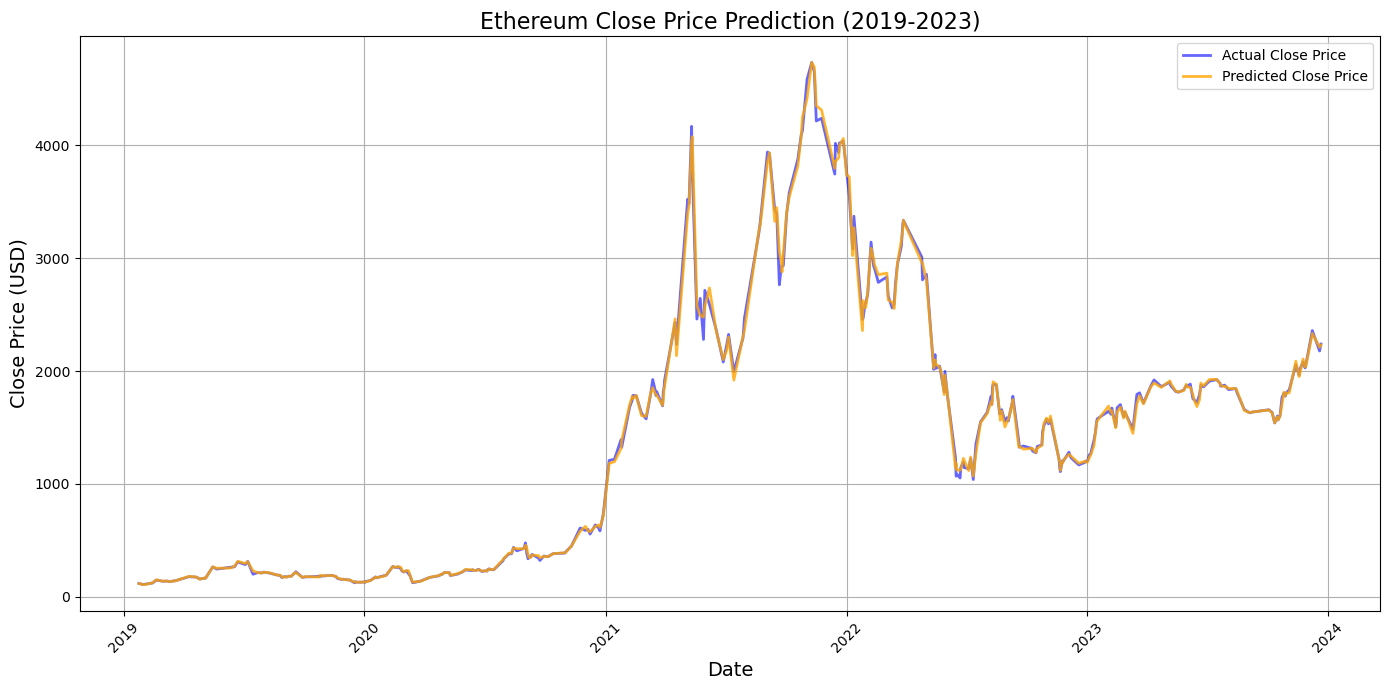

In [32]:
# ETH Random Forest Model 3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # For plotting
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# 1. Load the data
file_path = r'C:\Users\emily\Desktop\ETH-USD.csv'
data = pd.read_csv(file_path)

# 2. Data preprocessing
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Feature selection
features = data[['Open', 'High', 'Low', 'Volume']]
target = data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# 3. Train the Random Forest model
model = RandomForestRegressor(
    n_estimators=400,
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42
)
model.fit(X_train, y_train)

# 4. Make predictions
y_pred = model.predict(X_test)

# 5. Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Output performance metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Combine actual and predicted values into a DataFrame for easier plotting
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=X_test.index)

# Interpolation for smoother predictions
results['Predicted'] = results['Predicted'].interpolate(method='linear')

# Ensure the index is sorted
results.sort_index(inplace=True)

# Debug: Check available dates and contents of the results DataFrame
print("Results DataFrame:")
print(results.head())  # Show the first few rows
print("Available dates in the results DataFrame:")
print(f"Min date: {results.index.min()}")
print(f"Max date: {results.index.max()}")

# 6. Plotting the predictions for a specific time range
plt.figure(figsize=(14, 7))

# Set a valid date range within the available data
start_date = '2019-01-24'  # Set to min date
end_date = '2023-12-21'    # Set to max date

# Check if the date range is valid in the DataFrame index
print(f"Checking date range: {start_date} to {end_date}")  # Debugging line
if results.index.min() <= pd.to_datetime(start_date) <= results.index.max() and \
   results.index.min() <= pd.to_datetime(end_date) <= results.index.max():

    # Filter the DataFrame based on the date range
    filtered_results = results.loc[start_date:end_date]

    # Plot actual vs predicted within the specified date range
    plt.plot(filtered_results.index, filtered_results['Actual'], label='Actual Close Price', color='blue', alpha=0.6, linewidth=2)
    plt.plot(filtered_results.index, filtered_results['Predicted'], label='Predicted Close Price', color='orange', alpha=0.8, linewidth=2)

    # Adding title and labels
    plt.title('Ethereum Close Price Prediction (2019-2023)', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Close Price (USD)', fontsize=14)

    # Formatting the x-axis for better visibility
    plt.xticks(rotation=45)

    # Adding grid and legend
    plt.grid()
    plt.legend()
    plt.tight_layout()        # Adjust layout to prevent clipping
    plt.show()


In [18]:
# ETH Random Forest Model Comparison
import pandas as pd

# Define the performance metrics for each model
data = {
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'Mean Squared Error (MSE)': [2201.6559974065913, 2164.7560299551255, 2156.600044088281],
    'Mean Absolute Error (MAE)': [24.796760411010816, 24.79845205626052, 24.939980985551273],
    'R-squared (R²)': [0.9982669242971783, 0.9982959708135735, 0.99830239095412],
    'Mean Absolute Percentage Error (MAPE)': [1.74, 1.75, 1.78],
    'Root Mean Squared Error (RMSE)': [46.92180726918552, 46.52693875546859, 46.43920804760005]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame as a table
print(df.to_string(index=False))


  Model  Mean Squared Error (MSE)  Mean Absolute Error (MAE)  R-squared (R²)  Mean Absolute Percentage Error (MAPE)  Root Mean Squared Error (RMSE)
Model 1               2201.655997                  24.796760        0.998267                                   1.74                       46.921807
Model 2               2164.756030                  24.798452        0.998296                                   1.75                       46.526939
Model 3               2156.600044                  24.939981        0.998302                                   1.78                       46.439208


In [33]:
# BTC Gradient Boosting Machine 1
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# 1. Load data
data = pd.read_csv(r'C:\Users\emily\Desktop\BTC-USD.csv')

# 2. Data preprocessing
# Assume we want to predict the closing price and only use date and other features (adjust based on your data)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Select features and target
features = data.drop(columns=['Close'])  # Select feature columns
target = data['Close']  # Target variable

# Handle missing values (if any)
features.fillna(method='ffill', inplace=True)
target.fillna(method='ffill', inplace=True)

# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# 4. Train model
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

# 5. Make predictions
y_pred = model.predict(X_test)

# 6. Evaluate model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print performance metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape * 100}%')


C:\Users\emily\AppData\Local\Temp\ipykernel_13116\1482011968.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features.fillna(method='ffill', inplace=True)
C:\Users\emily\AppData\Local\Temp\ipykernel_13116\1482011968.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  target.fillna(method='ffill', inplace=True)


Mean Squared Error (MSE): 14488.979040361783
Mean Absolute Error (MAE): 84.56627284352173
Root Mean Squared Error (RMSE): 120.37017504499103
R² Score: 0.9999417385876848
Mean Absolute Percentage Error (MAPE): 0.45712891941763184%


C:\Users\emily\AppData\Local\Temp\ipykernel_13116\8330830.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features.fillna(method='ffill', inplace=True)
C:\Users\emily\AppData\Local\Temp\ipykernel_13116\8330830.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  target.fillna(method='ffill', inplace=True)


Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.1}
Mean Squared Error (MSE): 1797.9201340941615
Mean Absolute Error (MAE): 28.33076389942133
Root Mean Squared Error (RMSE): 42.401888331702416
R² Score: 0.9999927704108101
Mean Absolute Percentage Error (MAPE): 0.14822074436434562%


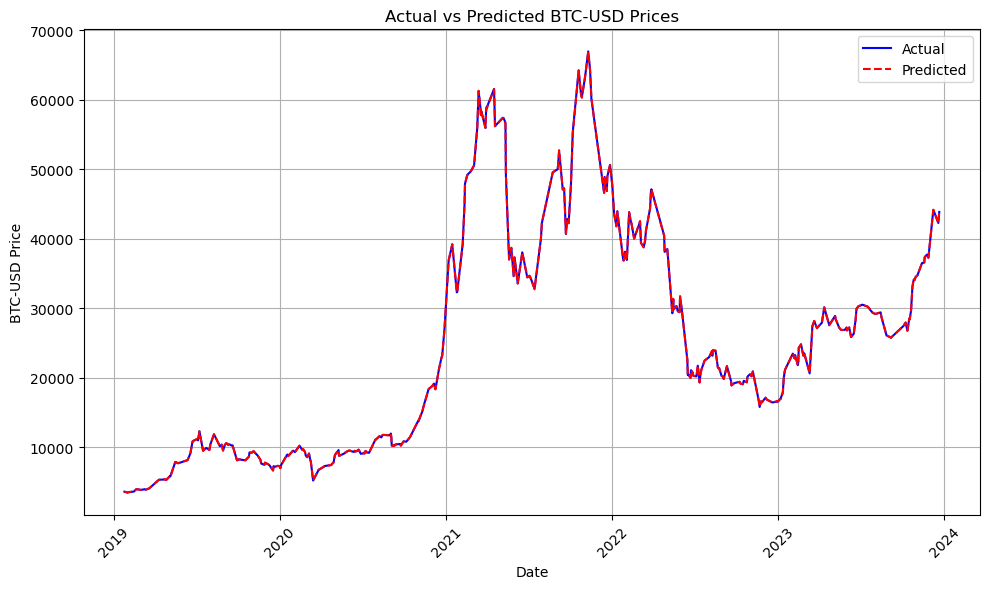

In [42]:
# BTC Gradient Boosting Machine 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Load data
data = pd.read_csv(r'C:\Users\emily\Desktop\BTC-USD.csv')

# Data preprocessing
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Select features and target
features = data.drop(columns=['Close'])  # Use all columns except 'Close'
target = data['Close']  # Target variable

# Handle missing values
features.fillna(method='ffill', inplace=True)
target.fillna(method='ffill', inplace=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define the parameter distribution for Randomized Search
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Randomized Search with fewer folds
random_search = RandomizedSearchCV(
    GradientBoostingRegressor(),
    param_dist,
    n_iter=10,  # Number of parameter settings to sample
    cv=3,  # Number of cross-validation folds
    scoring='neg_mean_squared_error',  # Use MSE as the scoring metric
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the model using the training data
random_search.fit(X_train, y_train)

# Get the best model from random search
best_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print performance metrics
print(f'Best Parameters: {random_search.best_params_}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape * 100}%')

# Visualization: Actual vs Predicted values
# Sort the data by date index to ensure a smooth line plot
y_test_sorted = y_test.sort_index()
y_pred_sorted = pd.Series(y_pred, index=y_test.index).sort_index()

plt.figure(figsize=(10,6))
plt.plot(y_test_sorted.index, y_test_sorted, label='Actual', color='blue')
plt.plot(y_test_sorted.index, y_pred_sorted, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted BTC-USD Prices')
plt.xlabel('Date')
plt.ylabel('BTC-USD Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()



In [37]:
# BTC Gradient Boosting Machine 3
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Load data
data = pd.read_csv(r'C:\Users\emily\Desktop\BTC-USD.csv')

# Data preprocessing
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Create lag features (e.g., lag for previous 7 days)
for lag in range(1, 8):
    data[f'lag_{lag}'] = data['Close'].shift(lag)

# Drop rows with NaN values caused by shifting
data.dropna(inplace=True)

# Select features and target
features = data.drop(columns=['Close'])
target = data['Close']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define parameter distribution for Randomized Search
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0]
}

# Perform Randomized Search with Gradient Boosting
random_search = RandomizedSearchCV(
    GradientBoostingRegressor(),
    param_dist,
    n_iter=10,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# Fit the model using the training data
random_search.fit(X_train, y_train)

# Get the best model from random search
best_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print performance metrics
print(f'Best Parameters: {random_search.best_params_}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape * 100}%')


Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 4, 'learning_rate': 0.1}
Mean Squared Error (MSE): 5245.70829670813
Mean Absolute Error (MAE): 48.336132576034096
Root Mean Squared Error (RMSE): 72.42726210970652
R² Score: 0.9999775308202449
Mean Absolute Percentage Error (MAPE): 0.30222786496854426%


In [43]:
# BTC Gradient Boosting Machine Comparison
import pandas as pd

# Model performance metrics
data = {
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'Mean Squared Error (MSE)': [14488.9790, 1797.9201, 5245.7083],
    'Mean Absolute Error (MAE)': [84.5663, 28.3308, 48.3361],
    'Root Mean Squared Error (RMSE)': [120.3702, 42.4019, 72.4273],
    'R² Score': [0.9999417, 0.9999928, 0.9999775],
    'Mean Absolute Percentage Error (MAPE)': [0.4571, 0.1482, 0.3022]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame as a table in one line
print(df.to_string(index=False))


  Model  Mean Squared Error (MSE)  Mean Absolute Error (MAE)  Root Mean Squared Error (RMSE)  R² Score  Mean Absolute Percentage Error (MAPE)
Model 1                14488.9790                    84.5663                        120.3702  0.999942                                 0.4571
Model 2                 1797.9201                    28.3308                         42.4019  0.999993                                 0.1482
Model 3                 5245.7083                    48.3361                         72.4273  0.999977                                 0.3022


In [44]:
# ETH Gradient Boosting Machine 1
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Load data
data = pd.read_csv(r'C:\Users\emily\Desktop\ETH-USD.csv')

# Data preprocessing
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Select features and target
features = data.drop(columns=['Close'])  # Use all columns except 'Close'
target = data['Close']  # Target variable

# Handle missing values
features.fillna(method='ffill', inplace=True)
target.fillna(method='ffill', inplace=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define the parameter distribution for Randomized Search
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Randomized Search with fewer folds
random_search = RandomizedSearchCV(
    GradientBoostingRegressor(),
    param_dist,
    n_iter=10,  # Number of parameter settings to sample
    cv=3,  # Number of cross-validation folds
    scoring='neg_mean_squared_error',  # Use MSE as the scoring metric
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the model using the training data
random_search.fit(X_train, y_train)

# Get the best model from random search
best_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print performance metrics
print(f'Best Parameters: {random_search.best_params_}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape * 100}%')


C:\Users\emily\AppData\Local\Temp\ipykernel_13116\1950230310.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features.fillna(method='ffill', inplace=True)
C:\Users\emily\AppData\Local\Temp\ipykernel_13116\1950230310.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  target.fillna(method='ffill', inplace=True)


Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.1}
Mean Squared Error (MSE): 22.328321240338617
Mean Absolute Error (MAE): 2.505762418362185
Root Mean Squared Error (RMSE): 4.725285307824134
R² Score: 0.9999824238341176
Mean Absolute Percentage Error (MAPE): 0.30043545073125744%


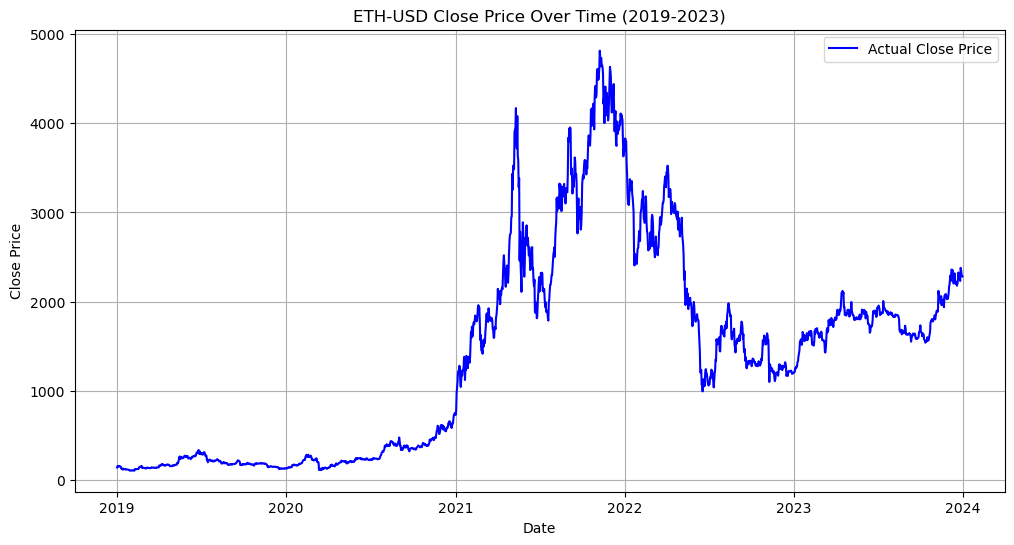

Best Parameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.1}
Mean Squared Error (MSE): 8.460149354533664
Mean Absolute Error (MAE): 2.1763133014067466
Root Mean Squared Error (RMSE): 2.90863358890969
R² Score: 0.9998265867154675
Mean Absolute Percentage Error (MAPE): 0.11920046311352876%


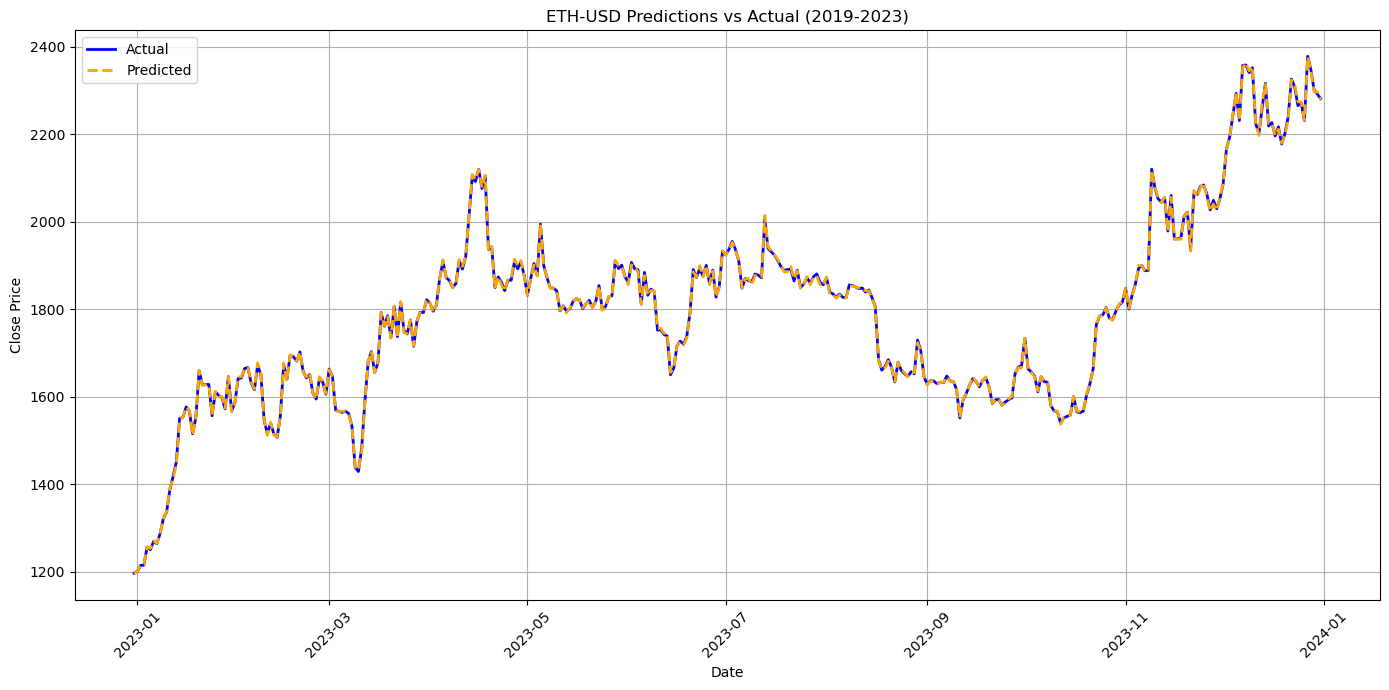

In [76]:
# ETH Gradient Boosting Machine 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Load data
data = pd.read_csv(r'C:\Users\emily\Desktop\ETH-USD.csv')

# Data preprocessing
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Select features and target
features = data.drop(columns=['Close'])  # Use all columns except 'Close'
target = data['Close']  # Target variable

# Handle missing values
features.ffill(inplace=True)
target.ffill(inplace=True)

# Visualize raw Close price data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Actual Close Price', color='blue')
plt.title('ETH-USD Close Price Over Time (2019-2023)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid()
plt.legend()
plt.show()

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, shuffle=False)

# Define a broader parameter distribution for Randomized Search
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

# Perform Randomized Search with more iterations and folds
random_search = RandomizedSearchCV(
    GradientBoostingRegressor(),
    param_dist,
    n_iter=20,  # Increase the number of parameter settings to sample
    cv=5,  # Use more cross-validation folds for a robust estimate
    scoring='neg_mean_squared_error',  # Use MSE as the scoring metric
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the model using the training data
random_search.fit(X_train, y_train)

# Get the best model from random search
best_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print performance metrics
print(f'Best Parameters: {random_search.best_params_}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape * 100}%')

# Convert predictions to DataFrame
pred_df = pd.DataFrame(y_pred, index=y_test.index, columns=['Predicted'])

# Plot actual vs predicted values for the entire test set
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual', color='blue', linestyle='-', linewidth=2)
plt.plot(pred_df.index, pred_df['Predicted'], label='Predicted', color='orange', linestyle='--', linewidth=2)

plt.title('ETH-USD Predictions vs Actual (2019-2023)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



In [49]:
# ETH Gradient Boosting Machine 3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Load data
data = pd.read_csv(r'C:\Users\emily\Desktop\ETH-USD.csv')

# Data preprocessing
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Feature Engineering: Adding moving averages and lag features
data['MA_5'] = data['Close'].rolling(window=5).mean()  # 5-day moving average
data['MA_10'] = data['Close'].rolling(window=10).mean()  # 10-day moving average
data['Lag_1'] = data['Close'].shift(1)  # 1-day lag
data['Lag_2'] = data['Close'].shift(2)  # 2-day lag

# Drop NaN values created by rolling window
data.dropna(inplace=True)

# Select features and target
features = data.drop(columns=['Close'])  # Use all columns except 'Close'
target = data['Close']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define a broader parameter distribution for Randomized Search
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

# Perform Randomized Search with more iterations and folds
random_search = RandomizedSearchCV(
    GradientBoostingRegressor(),
    param_dist,
    n_iter=30,  # Increase the number of parameter settings to sample
    cv=5,  # Use more cross-validation folds for a robust estimate
    scoring='neg_mean_squared_error',  # Use MSE as the scoring metric
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the model using the training data
random_search.fit(X_train, y_train)

# Get the best model from random search
best_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print performance metrics
print(f'Best Parameters: {random_search.best_params_}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape * 100}%')


Best Parameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.1}
Mean Squared Error (MSE): 26.462064781485076
Mean Absolute Error (MAE): 2.346373398647526
Root Mean Squared Error (RMSE): 5.144129156765514
R² Score: 0.9999796210029084
Mean Absolute Percentage Error (MAPE): 0.2718512640503372%


In [74]:
# ETH Gradient Boosting Machine Comparison
import pandas as pd

# Model performance metrics
data = {
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'Mean Squared Error (MSE)': [22.3283, 8.4851, 28.4132],
    'Mean Absolute Error (MAE)': [2.5058, 2.1719, 1.7427],
    'Root Mean Squared Error (RMSE)': [4.7253, 2.9129, 5.3304],
    'R² Score': [0.9999824238341176, 0.9998260754641195, 0.9999781183584037],
    'Mean Absolute Percentage Error (MAPE)': [0.3004, 0.11898, 0.1699]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Format the DataFrame for better readability
df = df.round(4)  # Round the values to 4 decimal places

# Display the DataFrame as a table
print(df.to_string(index=False))


  Model  Mean Squared Error (MSE)  Mean Absolute Error (MAE)  Root Mean Squared Error (RMSE)  R² Score  Mean Absolute Percentage Error (MAPE)
Model 1                   22.3283                     2.5058                          4.7253    1.0000                                 0.3004
Model 2                    8.4851                     2.1719                          2.9129    0.9998                                 0.1190
Model 3                   28.4132                     1.7427                          5.3304    1.0000                                 0.1699


In [82]:
# Comparison for all time series analysis
import pandas as pd

# Create data dictionary
data = {
    "Model Type": [
        "AR", "AR", "SMA", "SMA", "EMA", "EMA",
        "Prophet", "Prophet", "GARCH", "GARCH",
        "LSTM", "LSTM", "LSTM", "LSTM"
    ],
    "Currency": [
        "BTC", "ETH", "BTC", "ETH", "BTC", "ETH",
        "BTC", "ETH", "BTC", "ETH",
        "BTC", "ETH", "BTC", "ETH"
    ],
    "Train/Test": [
        "Train", "Train", "Train", "Train", "Train", "Train",
        "Train", "Train", "Train", "Train",
        "Train", "Test", "Train", "Test"
    ],
    "MSE": [
        92741845.0172839, 160692.70373277285, 1253171.0, 1632583.0,
        857829.8, 1672834.0, 6978845.425808422, 493762.692425655,
        0.10193197039173925, 0.00158058108978924,
        1577444.093986917, 608052.2133475278, 10099.31026858246, 2608.57670538396
    ],
    "RMSE": [
        9630.2567472152, 400.86494450472077, 1119.451, 1277.588,
        926.1910, 1294.343, 2641.750447299749, 702.6824975945075,
        0.31926786620601083, 0.039756522606853334,
        1255.9634126784574, 779.7770279685903, 100.49532461056315, 51.074227408586026
    ],
    "MAE": [
        8455.969606038367, 343.9946105426597, 678.7339, 880.0837,
        560.0509, 884.9848, 2015.062524791689, 625.5706538426791,
        0.28703399621425696, 0.03925395605823435,
        807.9253113300869, 587.8552220842083, 61.79189835055295, 40.42981727702744
    ],
    "R²": [
        -1.6473016933597746, -1.005541710135684, 0.9951343, 0.9900224,
        0.9966693, 0.9898859, 0.9729431544756836, -9.120980928929413,
        -4.221359568265818, -0.7169086434162018,
        0.9947653538533882, 0.9352569296371539, 0.9938956040012404, 0.9352569296371539
    ],
    "AIC": [
        24460.084680996843, -4034.4245747958403, 25587.04, 25971.14,
        24896.46, 25980.66, 28778.82753398751, 4824.1905701826945,
        1199.0321000645272, -6390.005440546713,
        19541.4321969708, 3666.4544094812836, 12353.877807335604, 1935.3072068516858
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Print the table
print(df.to_string(index=False))


Model Type Currency Train/Test          MSE        RMSE         MAE        R²          AIC
        AR      BTC      Train 9.274185e+07 9630.256747 8455.969606 -1.647302 24460.084681
        AR      ETH      Train 1.606927e+05  400.864945  343.994611 -1.005542 -4034.424575
       SMA      BTC      Train 1.253171e+06 1119.451000  678.733900  0.995134 25587.040000
       SMA      ETH      Train 1.632583e+06 1277.588000  880.083700  0.990022 25971.140000
       EMA      BTC      Train 8.578298e+05  926.191000  560.050900  0.996669 24896.460000
       EMA      ETH      Train 1.672834e+06 1294.343000  884.984800  0.989886 25980.660000
   Prophet      BTC      Train 6.978845e+06 2641.750447 2015.062525  0.972943 28778.827534
   Prophet      ETH      Train 4.937627e+05  702.682498  625.570654 -9.120981  4824.190570
     GARCH      BTC      Train 1.019320e-01    0.319268    0.287034 -4.221360  1199.032100
     GARCH      ETH      Train 1.580581e-03    0.039757    0.039254 -0.716909 -6390.005441

In [85]:
# Comparison for Machine learning Models
import pandas as pd

# Define the data
data = {
    "Model Type": [
        "Linear Regression", "Linear Regression",
        "Decision Trees", "Decision Trees",
        "Random Forests", "Random Forests",
        "Gradient Boosting Machine", "Gradient Boosting Machine"
    ],
    "Currency": ["BTC", "ETH", "BTC", "ETH", "BTC", "ETH", "BTC", "ETH"],
    "MSE": [
        23958.49, 126452.47,
        179904.24, 52.31,
        323371.15, 2156.60,
        1797.92, 8.46
    ],
    "RMSE": [
        154.79, 355.60,
        424.15, 7.23,
        568.66, 46.44,
        42.40, 2.91
    ],
    "MAE": [
        110.70, 313.40,
        320.77, 3.18,
        302.99, 24.94,
        28.33, 2.18
    ],
    "R²": [
        1.00, 0.90,
        0.99, 0.99996,
        0.9987, 0.9983,
        0.99999, 0.99983
    ],
    "Explained Variance Score": [
        1.00, 0.90,
        0.99, 0.99996,
        0.9987, 0.9983,
        0.99999, 0.99983
    ]
}

# Create a DataFrame
performance_df = pd.DataFrame(data)

# Display the DataFrame using to_string
print(performance_df.to_string(index=False))


               Model Type Currency       MSE   RMSE    MAE      R²  Explained Variance Score
        Linear Regression      BTC  23958.49 154.79 110.70 1.00000                   1.00000
        Linear Regression      ETH 126452.47 355.60 313.40 0.90000                   0.90000
           Decision Trees      BTC 179904.24 424.15 320.77 0.99000                   0.99000
           Decision Trees      ETH     52.31   7.23   3.18 0.99996                   0.99996
           Random Forests      BTC 323371.15 568.66 302.99 0.99870                   0.99870
           Random Forests      ETH   2156.60  46.44  24.94 0.99830                   0.99830
Gradient Boosting Machine      BTC   1797.92  42.40  28.33 0.99999                   0.99999
Gradient Boosting Machine      ETH      8.46   2.91   2.18 0.99983                   0.99983
